# Notes

In [1]:
path_to_CNN = '/Users/DrV/PyProj/MRI_personality/sub-0001/nibabel_CNN'
path_to_excel = '/Users/DrV/code/lukevano/tables_2/'

# Imports

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Log Regression

## Description of loaded data

Three datasets are all merged in the following way:

Top 208 observations are ds002785, from 209 to 434 are ds002790, and from 435 to 1362 are ds003097

Columns have been concatenated so that the first columns are the participant details, then the targets, followed by the lt then rt cortical parcellations and lastly the volume segmentation of the subcortical structures.

Columns religious and raven have been deleted as not recorded in all datasets.

In [4]:
# Load the dataset
df = pd.read_excel('/Users/DrV/code/lukevano/tables_2/master_combined.xlsx')
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,sub-0001,26.25,F,24.0,right,applied,35,44,37,39,...,9.173525e+05,8.994205e+05,896844,1327933,0.861916,1.104817,12,15,27,1.201948e+06
1,sub-0002,21.00,F,23.0,right,academic,27,53,40,48,...,1.146516e+06,1.126214e+06,1124177,1601336,0.764482,0.946018,12,3,15,1.692713e+06
2,sub-0003,23.00,M,22.0,right,academic,35,40,43,37,...,1.041503e+06,1.029726e+06,1028008,1486426,0.904479,1.121519,7,8,15,1.325368e+06
3,sub-0004,23.50,F,22.0,right,applied,29,47,41,48,...,9.868068e+05,9.746908e+05,973108,1399947,0.847637,1.046196,14,9,23,1.338131e+06
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26,35,40,38,...,1.096504e+06,1.085620e+06,1084371,1552057,0.784204,0.981137,17,12,29,1.581897e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,sub-1358,22.25,male,21.0,right,medium,40,39,47,38,...,1.114540e+06,1.103578e+06,1101665,1607448,0.733615,0.921517,19,23,42,1.744349e+06
1358,sub-1359,25.25,male,30.0,right,medium,28,41,48,34,...,1.162712e+06,1.153654e+06,1150737,1660909,0.752255,0.933091,20,34,54,1.780007e+06
1359,sub-1360,20.75,male,22.0,right,high,27,44,46,41,...,1.130508e+06,1.101670e+06,1098852,1627185,0.697260,0.881901,20,33,53,1.845088e+06
1360,sub-1361,24.25,female,35.0,right,medium,35,32,44,45,...,9.487515e+05,9.420765e+05,939899,1351729,0.808297,1.003723,31,34,65,1.346715e+06


In [5]:
# Keep only the volume and thickness features and view correlations
vol_thick_features = df.iloc[:,11:]
corr = vol_thick_features.corr()
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df

,feature_1,feature_2,correlation
5113,eTIV,eTIV.1,1.0
5179,eTIV,EstimatedTotalIntraCranialVol,1.0
5020,BrainSegVolNotVent,BrainSegVolNotVent.2,1.0
4972,BrainSegVolNotVent,BrainSegVolNotVent.1,1.0
10115,BrainSegVolNotVent.1,BrainSegVolNotVent,1.0
...,...,...,...
19432,SurfaceHoles,Right-non-WM-hypointensities,NaN
19568,EstimatedTotalIntraCranialVol,Left-WM-hypointensities,NaN
19569,EstimatedTotalIntraCranialVol,Right-WM-hypointensities,NaN
19571,EstimatedTotalIntraCranialVol,Left-non-WM-hypointensities,NaN


In [6]:
# View the columns that are identical
corr_df[corr_df.correlation>0.999]

,feature_1,feature_2,correlation
5113,eTIV,eTIV.1,1.000000
5179,eTIV,EstimatedTotalIntraCranialVol,1.000000
5020,BrainSegVolNotVent,BrainSegVolNotVent.2,1.000000
4972,BrainSegVolNotVent,BrainSegVolNotVent.1,1.000000
10115,BrainSegVolNotVent.1,BrainSegVolNotVent,1.000000
16872,BrainSegVolNotVent.2,BrainSegVolNotVent.1,1.000000
16835,BrainSegVolNotVent.2,BrainSegVolNotVent,1.000000
19533,EstimatedTotalIntraCranialVol,eTIV.1,1.000000
19496,EstimatedTotalIntraCranialVol,eTIV,1.000000
10359,eTIV.1,EstimatedTotalIntraCranialVol,1.000000


In [7]:
# Make a list of the columns to remove and consider removing
# Remove idenical columns and hypointensity columns with virtually no values
to_remove = ['eTIV.1', 'EstimatedTotalIntraCranialVol', 'BrainSegVolNotVent.2',
    'BrainSegVolNotVent.1', 'BrainSegVolNotVentSurf', 'SupraTentorialVolNotVentVox',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'BrainSegVolNotVent.2', 
    'BrainSegVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent',
    'BrainSegVol-to-eTIV', 'MaskVol', 'rhCortexVol', 'lhCortexVol', 'Left-WM-hypointensities',
    'Right-WM-hypointensities', 'non-WM-hypointensities', 'Left-non-WM-hypointensities',
    'Right-non-WM-hypointensities']
consider_removal = ['5th-Ventricle', 'SurfaceHoles', 'lhSurfaceHoles', 'rhSurfaceHoles']

In [8]:
vol_thick_features_less = vol_thick_features.drop(columns=to_remove)
corr_less = vol_thick_features_less.corr()
corr_less_df = corr_less.unstack().reset_index() # Unstack correlation matrix 
corr_less_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_less_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_less_df = corr_less_df[corr_less_df['feature_1'] != corr_less_df['feature_2']] # Remove self correlation
corr_less_df[corr_less_df.correlation>0.9]

,feature_1,feature_2,correlation
13912,TotalGrayVol,CortexVol,0.983605
13555,CortexVol,TotalGrayVol,0.983605
14397,SurfaceHoles,lhSurfaceHoles,0.958672
14159,lhSurfaceHoles,SurfaceHoles,0.958672
11235,Right-Cerebellum-Cortex,Left-Cerebellum-Cortex,0.956348
9093,Left-Cerebellum-Cortex,Right-Cerebellum-Cortex,0.956348
14398,SurfaceHoles,rhSurfaceHoles,0.951838
14279,rhSurfaceHoles,SurfaceHoles,0.951838
13835,TotalGrayVol,BrainSegVolNotVent,0.950506
4315,BrainSegVolNotVent,TotalGrayVol,0.950506


In [9]:
df_drop = df.drop(columns=to_remove)

In [10]:
df_drop.corr()['NEO_N'].sort_values(ascending=False)

NEO_N                            1.000000
NEO_O                            0.136066
rh_inferiortemporal_thickness    0.100484
rh_middletemporal_thickness      0.088380
lh_bankssts_thickness            0.085682
                                   ...   
Left-Accumbens-area             -0.103202
Right-Accumbens-area            -0.115273
Brain-Stem                      -0.127931
NEO_E                           -0.323274
NEO_C                           -0.358177
Name: NEO_N, Length: 127, dtype: float64

In [11]:
df_drop.corr()['NEO_E'].sort_values(ascending=False)

NEO_E                                1.000000
NEO_C                                0.199957
Optic-Chiasm                         0.175868
Left-Accumbens-area                  0.171150
NEO_O                                0.159415
                                       ...   
lh_superiorfrontal_thickness        -0.139352
rh_superiorfrontal_thickness        -0.139430
lh_rostralmiddlefrontal_thickness   -0.148245
lh_caudalmiddlefrontal_thickness    -0.155507
NEO_N                               -0.323274
Name: NEO_E, Length: 127, dtype: float64

In [12]:
df_drop.corr()['NEO_O'].sort_values(ascending=False)

NEO_O                            1.000000
NEO_E                            0.159415
NEO_N                            0.136066
Left-Putamen                     0.129670
Right-Putamen                    0.105202
                                   ...   
rh_middletemporal_thickness     -0.077697
rh_inferiorparietal_thickness   -0.078834
BMI                             -0.091675
lh_middletemporal_thickness     -0.092831
NEO_C                           -0.124567
Name: NEO_O, Length: 127, dtype: float64

In [13]:
df_drop.corr()['NEO_A'].sort_values(ascending=False)

NEO_A                   1.000000
MaskVol-to-eTIV         0.274711
NEO_C                   0.266463
Left-Accumbens-area     0.231139
Optic-Chiasm            0.220145
                          ...   
Left-VentralDC         -0.279316
Right-Pallidum         -0.283596
Right-Amygdala         -0.293897
Left-Thalamus-Proper   -0.306821
eTIV                   -0.329859
Name: NEO_A, Length: 127, dtype: float64

In [14]:
df_drop.corr()['NEO_C'].sort_values(ascending=False)

NEO_C                   1.000000
Left-Accumbens-area     0.328654
Optic-Chiasm            0.296591
MaskVol-to-eTIV         0.291598
NEO_A                   0.266463
                          ...   
rhSurfaceHoles         -0.239638
Left-Thalamus-Proper   -0.248308
SurfaceHoles           -0.249677
eTIV                   -0.259911
NEO_N                  -0.358177
Name: NEO_C, Length: 127, dtype: float64

## Preprocessing master_dup_removed v1

In [15]:
# Load the dataset
df_neo_nan = pd.read_excel('/Users/DrV/code/lukevano/tables_2/master_dup_removed v1.xlsx')
df_neo_nan

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,898.8,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0
1358,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,848.9,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0
1359,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,585.8,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0
1360,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,825.9,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0


In [16]:
# Check for null values in main feat/targets
df_neo_nan.isnull().sum().sort_values(ascending=False).head(8)

BMI                     9
handedness              9
age                     9
sex                     8
NEO_C                   1
education_category      1
Brain-Stem              0
Left-Thalamus-Proper    0
dtype: int64

In [17]:
# Remove nan from NEO_C
df = df_neo_nan[df_neo_nan.NEO_C.notnull()].reset_index(drop=True) # reset or have empty indexes
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,898.8,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0
1357,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,848.9,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0
1358,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,585.8,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0
1359,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,825.9,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0


In [18]:
# Discretizing target: 0 = lower, 1 = higher
y_disc = df.iloc[:,6:11]
y = []
for i in range(5):
    y.append(pd.cut(x= y_disc.iloc[:,i], 
                    bins= [y_disc.iloc[:,i].min()-1, y_disc.iloc[:,i].mean(), y_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y = pd.DataFrame(y[0:5]).T
y.head()

,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,1,1,0,0,1
1,0,1,0,1,0
2,1,0,1,0,0
3,0,1,0,1,1
4,0,0,0,0,1


In [19]:
# Feature creation
X = df.iloc[:,11:]
X.head()

,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,2.439,2.985,2.422,1.860,3.808,2.592,2.348,2.531,2.497,2.070,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,2.820,2.684,2.642,2.008,3.573,2.838,2.564,2.706,2.510,2.389,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,2.365,2.832,2.538,1.864,3.479,2.658,2.399,2.804,2.193,2.123,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,2.475,2.861,2.488,2.082,2.997,2.755,2.538,2.647,2.369,2.350,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,2.691,2.566,2.742,2.067,3.222,2.795,2.774,2.616,2.421,2.284,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0


In [20]:
# Check that no null in features and targets
print(X.isnull().sum().sum())
print(y.isnull().sum())

0
NEO_N    0
NEO_E    0
NEO_O    0
NEO_A    0
NEO_C    0
dtype: int64


## Building models and feature selection

Use statsmodels over sklearn as you can determine more about the features. When doing logisitic regression you are sacrificing quality for explainability: you know what is happening behind the model.

The two approaches for building models are either make a model with each feature individually and then start adding the features together or put all the features together and start to remove those that are too highly correlated.

In [21]:
# Add a constant as a feature- needed unless you want to go through origin on Logit
X_int = sm.add_constant(X)
X_int.head()

/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,1.0,2.439,2.985,2.422,1.860,3.808,2.592,2.348,2.531,2.497,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,1.0,2.820,2.684,2.642,2.008,3.573,2.838,2.564,2.706,2.510,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,1.0,2.365,2.832,2.538,1.864,3.479,2.658,2.399,2.804,2.193,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,1.0,2.475,2.861,2.488,2.082,2.997,2.755,2.538,2.647,2.369,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,1.0,2.691,2.566,2.742,2.067,3.222,2.795,2.774,2.616,2.421,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0


Build the models and work out what features to keep for each. If you standardise then you lose some information but it allows you to compare coeffiecients: if the feature is on a larger scale smaller coefficients make have a larger impact on the model. The null hypothesis is that the coef is 0 so if p>0.05 then can't prove not 0.

In [22]:
# Here is the output for a non-standardised model
# Will take longer to converge if not scaled= 41 iterations. Get the same accuracy:
# It will always converge on the global minima as Logit is a convex problem
results_NEO_N = sm.Logit(y['NEO_N'], X_int).fit(maxiter=100)
results_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.638814
         Iterations 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1240
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                 0.07456
Time:                        10:22:28   Log-Likelihood:                -869.43
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                    0.1014
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -8.2171      4.217     -1.949      0.051     -16.482       0.048
lh_bankssts_thickness                     0.6105      0.520      1.175      0.240      -0.408       1.629
lh_caudalanteriorcingulate_thickness      0.1630      0.345      0.473      0.636      -0.513       0.839
lh_caudalmiddlefrontal_thickness          0.3528      0.827      0.427      0.670      -1.268       1.973
lh_cuneus_thickness                      -0.0206      0.637     -0.032      0.974      -1.268       1.227
lh_entorhinal_thickness                  -0.2577      0.271     -0.950      0.342      -0.790       0.274
lh_fusiform_thickness                     0.3293      0.937      0.352      0.725      -1.507       2.165
lh_inferiorparietal_thickness             0.3837      1.195      0.321      0.748      -1.959       2.726
lh_inferiortemporal_thickness            -0.3039      0.886     -0.343      0.732      -2.041       1.433
lh_isthmuscingulate_thickness            -0.3246      0.472     -0.688      0.491      -1.249       0.600
lh_lateraloccipital_thickness             0.4710      1.138      0.414      0.679      -1.759       2.701
lh_lateralorbitofrontal_thickness         1.0654      0.757      1.407      0.160      -0.419       2.550
lh_lingual_thickness                      0.3732      0.792      0.471      0.638      -1.180       1.926
lh_medialorbitofrontal_thickness         -0.0183      0.583     -0.031      0.975      -1.160       1.124
lh_middletemporal_thickness               0.1780      0.834      0.214      0.831      -1.456       1.812
lh_parahippocampal_thickness             -0.4049      0.312     -1.299      0.194      -1.016       0.206
lh_paracentral_thickness                  0.6420      0.670      0.959      0.338      -0.670       1.954
lh_parsopercularis_thickness             -0.0724      0.695     -0.104      0.917      -1.435       1.290
lh_parsorbitalis_thickness               -0.5377      0.453     -1.188      0.235      -1.425       0.350
lh_parstriangularis_thickness             0.4784      0.654      0.732      0.464      -0.803       1.760
lh_pericalcarine_thickness                0.3019      0.683      0.442      0.659      -1.037       1.641
lh_postcentral_thickness                  1.3848      1.101      1.257      0.209      -0.774       3.544
lh_posteriorcingulate_thickness           0.0516      0.561      0.092      0.927      -1.048       1.151
lh_precentral_thickness                  -1.2824      1.131     -1.133      0.257      -3.500       0.935
lh_precuneus_thickness                    1.1499      1.119      1.028      0.304      -1.042       3.342
lh_rostralanteriorcingulate_thickness    -0.0266      0.419     -0.063      0.949      -0.847       0.794
lh_rostralmiddlefrontal_thickness         0.5342      1.316      0.406      0.685      -2.045       3.113
lh_superiorfrontal_thickness             -1.9448      1.391  

In [23]:
# Normalise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.15643719,  0.70132935, -1.65637706, ..., -0.79182748,
        -0.5372538 , -0.70048969],
       [ 1.37933792, -0.69828523, -0.17574971, ..., -0.79182748,
        -1.56699551, -1.21942272],
       [-1.64894995, -0.01010265, -0.87568264, ..., -1.19022941,
        -1.13793646, -1.21942272],
       ...,
       [ 1.2062929 ,  1.33836323,  1.45967051, ..., -0.1543844 ,
         1.00735876,  0.42386521],
       [-1.13647046, -0.58668806, -0.15555933, ...,  0.72209983,
         1.09317057,  0.94279824],
       [ 0.68715784, -0.53553935,  1.46640064, ..., -0.87150787,
        -0.62306561, -0.78697852]])

In [24]:
# Add a constant as a feature to the scaled X and make DF
X_scaled_int = sm.add_constant(X_scaled)
X_scaled_int = pd.DataFrame(X_scaled_int, columns=X_int.columns)
X_scaled_int

,const,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,1.0,-1.156437,0.701329,-1.656377,-0.138889,1.217357,-1.749292,-1.827016,-2.124678,-0.154424,...,-0.974651,-0.055741,-1.441587,-1.080957,-1.648952,-1.628590,1.075986,-0.791827,-0.537254,-0.700490
1,1.0,1.379338,-0.698285,-0.175750,0.730665,0.378808,0.346981,0.135519,-0.849922,-0.083477,...,-0.583834,0.278796,0.903378,0.669794,0.231591,0.744739,-0.326927,-0.791827,-1.566996,-1.219423
2,1.0,-1.648950,-0.010103,-0.875683,-0.115388,0.043388,-1.186877,-1.363640,-0.136058,-1.813477,...,0.000121,-0.558497,-0.411799,0.273359,-1.067439,-0.256373,1.223540,-1.190229,-1.137936,-1.219423
3,1.0,-0.916836,0.124744,-1.212189,1.165442,-1.676529,-0.360298,-0.100712,-1.279697,-0.852972,...,-0.879377,-0.072184,-0.287022,-0.864992,-0.547128,-0.255145,0.558098,-0.632467,-1.052125,-0.873467
4,1.0,0.520768,-1.246971,0.497263,1.077312,-0.873663,-0.019441,2.043540,-1.505511,-0.569187,...,0.383160,-0.139850,0.877001,-0.006968,0.078489,0.646414,-0.016667,-0.393426,-0.794689,-0.614001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,1.0,1.239571,-0.958679,1.459671,-0.450284,-0.638156,0.764531,0.880556,0.861895,-0.536442,...,1.777914,-0.482609,0.248441,0.779304,1.139319,0.459615,-0.543381,-0.234065,0.149241,-0.051823
1357,1.0,-0.064922,-1.377168,-0.875683,-0.009631,0.935462,-0.317691,-1.463583,-0.718804,-2.228240,...,1.454502,-0.694462,0.278788,1.633553,0.908695,0.564712,-0.441130,-0.154384,1.093171,0.467110
1358,1.0,1.206293,1.338363,1.459671,-0.303399,1.677667,0.142466,1.434791,0.301002,0.751507,...,-0.250701,1.044628,1.221462,-0.073182,0.272975,1.163650,-0.893369,-0.154384,1.007359,0.423865
1359,1.0,-1.136470,-0.586688,-0.155559,-0.820432,-1.084192,-1.911199,-0.627689,0.381129,-0.825685,...,1.305434,0.267413,-1.244780,-0.549693,-1.053839,-1.371821,0.182869,0.722100,1.093171,0.942798


In [25]:
# Here is the output for a standardised model
results_NEO_N_scaled = sm.Logit(y['NEO_N'], X_scaled_int).fit()
results_NEO_N_scaled.summary()

Optimization terminated successfully.
         Current function value: 0.638814
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1240
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                 0.07456
Time:                        10:22:28   Log-Likelihood:                -869.43
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                    0.1014
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1685      0.057     -2.935      0.003      -0.281      -0.056
lh_bankssts_thickness                     0.0917      0.078      1.175      0.240      -0.061       0.245
lh_caudalanteriorcingulate_thickness      0.0351      0.074      0.473      0.636      -0.110       0.180
lh_caudalmiddlefrontal_thickness          0.0524      0.123      0.427      0.670      -0.188       0.293
lh_cuneus_thickness                      -0.0035      0.108     -0.032      0.974      -0.216       0.209
lh_entorhinal_thickness                  -0.0722      0.076     -0.950      0.342      -0.221       0.077
lh_fusiform_thickness                     0.0386      0.110      0.352      0.725      -0.177       0.254
lh_inferiorparietal_thickness             0.0422      0.132      0.321      0.748      -0.216       0.300
lh_inferiortemporal_thickness            -0.0417      0.122     -0.343      0.732      -0.280       0.197
lh_isthmuscingulate_thickness            -0.0595      0.086     -0.688      0.491      -0.229       0.110
lh_lateraloccipital_thickness             0.0606      0.146      0.414      0.679      -0.226       0.348
lh_lateralorbitofrontal_thickness         0.1456      0.104      1.407      0.160      -0.057       0.348
lh_lingual_thickness                      0.0594      0.126      0.471      0.638      -0.188       0.306
lh_medialorbitofrontal_thickness         -0.0031      0.098     -0.031      0.975      -0.196       0.190
lh_middletemporal_thickness               0.0255      0.119      0.214      0.831      -0.209       0.260
lh_parahippocampal_thickness             -0.1157      0.089     -1.299      0.194      -0.290       0.059
lh_paracentral_thickness                  0.0959      0.100      0.959      0.338      -0.100       0.292
lh_parsopercularis_thickness             -0.0102      0.098     -0.104      0.917      -0.202       0.182
lh_parsorbitalis_thickness               -0.1041      0.088     -1.188      0.235      -0.276       0.068
lh_parstriangularis_thickness             0.0741      0.101      0.732      0.464      -0.124       0.273
lh_pericalcarine_thickness                0.0501      0.113      0.442      0.659      -0.172       0.272
lh_postcentral_thickness                  0.1524      0.121      1.257      0.209      -0.085       0.390
lh_posteriorcingulate_thickness           0.0081      0.088      0.092      0.927      -0.165       0.181
lh_precentral_thickness                  -0.1584      0.140     -1.133      0.257      -0.432       0.115
lh_precuneus_thickness                    0.1338      0.130      1.028      0.304      -0.121       0.389
lh_rostralanteriorcingulate_thickness    -0.0048      0.075     -0.063      0.949      -0.152       0.142
lh_rostralmiddlefrontal_thickness         0.0654      0.161      0.406      0.685      -0.250       0.381
lh_superiorfrontal_thickness             -0.2831      0.202  

In [26]:
# Select the thickness col with p<0.25
NEO_N_col_thick_25 = ['lh_bankssts_thickness', 'lh_lateralorbitofrontal_thickness', 
                  'lh_parahippocampal_thickness', 'lh_parsorbitalis_thickness',
                  'lh_postcentral_thickness', 'lh_precentral_thickness',
                  'lh_superiorfrontal_thickness', 'lh_superiorparietal_thickness',
                  'lh_supramarginal_thickness', 'rh_caudalmiddlefrontal_thickness',
                  'rh_entorhinal_thickness', 'rh_inferiorparietal_thickness',
                  'rh_lateraloccipital_thickness', 'rh_lateralorbitofrontal_thickness',
                  'rh_middletemporal_thickness', 'rh_parahippocampal_thickness',
                  'rh_precentral_thickness', 'rh_superiorfrontal_thickness',
                  'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
                  'rh_MeanThickness_thickness']

In [27]:
X_NEO_N_25 = X_scaled_int[NEO_N_col_thick_25]
X_NEO_N_25.head()

,lh_bankssts_thickness,lh_lateralorbitofrontal_thickness,lh_parahippocampal_thickness,lh_parsorbitalis_thickness,lh_postcentral_thickness,lh_precentral_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_supramarginal_thickness,rh_caudalmiddlefrontal_thickness,...,rh_inferiorparietal_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_precentral_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_MeanThickness_thickness
0,-1.156437,-0.482144,-1.364174,-1.242120,-1.237658,-1.137706,-2.121035,-1.061538,-0.298648,-1.083619,...,-1.124450,-0.711004,-1.353681,-0.895016,-1.617833,-1.282051,-2.225268,-0.139559,-1.597231,-1.682920
1,1.379338,-1.338379,-1.941701,-1.768977,0.043329,0.336021,-0.808854,0.585000,-0.765768,-0.224257,...,-1.352401,0.391684,-1.582808,-0.446885,-2.414434,0.436686,-1.290516,0.617812,0.013438,-0.615920
2,-1.648950,-1.404243,0.067393,-2.047902,0.570260,-0.530401,0.139213,-0.565896,-0.732402,-1.156897,...,0.322163,-0.744933,-0.516180,-0.648219,-0.349020,-0.450151,-0.185134,0.239126,-0.092281,-0.820413
3,-0.916836,-0.057686,-0.247622,-0.642949,0.524835,-0.578985,-1.585171,0.711011,-0.457135,-1.343426,...,-0.545805,1.256870,-0.389765,-0.323487,-0.205304,-0.034201,-1.513076,0.550490,0.367910,-0.315453
4,0.520768,-0.174778,-0.433130,0.271304,0.652025,0.546554,-0.018798,1.005036,0.827443,0.655090,...,0.865739,1.265352,0.171203,0.254537,-0.570755,0.719218,0.556733,0.651473,-1.043758,0.399640


In [28]:
# Here is the output for a non-standardised model
results_NEO_N_25 = sm.Logit(y['NEO_N'], X_NEO_N_25).fit()
results_NEO_N_25.summary()

Optimization terminated successfully.
         Current function value: 0.677238
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                           20
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                 0.01889
Time:                        10:22:28   Log-Likelihood:                -921.72
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                   0.01759
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
lh_bankssts_thickness                 0.1130      0.067      1.699      0.089      -0.017       0.243
lh_lateralorbitofrontal_thickness     0.1084      0.081      1.335      0.182      -0.051       0.268
lh_parahippocampal_thickness         -0.0762      0.073     -1.039      0.299      -0.220       0.067
lh_parsorbitalis_thickness           -0.0348      0.073     -0.476      0.634      -0.178       0.109
lh_postcentral_thickness              0.2430      0.079      3.066      0.002       0.088       0.398
lh_precentral_thickness              -0.0968      0.103     -0.937      0.349      -0.299       0.106
lh_superiorfrontal_thickness         -0.1067      0.137     -0.781      0.435      -0.374       0.161
lh_superiorparietal_thickness        -0.1752      0.111     -1.582      0.114      -0.392       0.042
lh_supramarginal_thickness           -0.0594      0.091     -0.651      0.515      -0.238       0.119
rh_caudalmiddlefrontal_thickness      0.1967      0.098      2.004      0.045       0.004       0.389
rh_entorhinal_thickness               0.0976      0.058      1.685      0.092      -0.016       0.211
rh_inferiorparietal_thickness         0.2298      0.105      2.190      0.029       0.024       0.435
rh_lateraloccipital_thickness         0.2608      0.089      2.937      0.003       0.087       0.435
rh_lateralorbitofrontal_thickness     0.0947      0.082      1.154      0.248      -0.066       0.256
rh_middletemporal_thickness           0.1125      0.094      1.199      0.230      -0.071       0.296
rh_parahippocampal_thickness          0.1301      0.077      1.693      0.090      -0.020       0.281
rh_precentral_thickness               0.1646      0.108      1.529      0.126      -0.046       0.376
rh_superiorfrontal_thickness          0.3342      0.143      2.344      0.019       0.055       0.614
rh_superiorparietal_thickness         0.1235      0.124      0.999      0.318      -0.119       0.366
rh_superiortemporal_thickness         0.1729      0.096      1.798      0.072      -0.016       0.361
rh_MeanThickness_thickness           -1.1283      0.262     -4.310      0.000      -1.641      -0.615
=====================================================================================================
"""

In [29]:
# Make y pred and y pred proba for the models
y_pred_proba_NEO_N = results_NEO_N.predict(X_int) # remember to add int to features
y_pred_proba_NEO_N_scaled = results_NEO_N_scaled.predict(X_scaled_int)
y_pred_proba_NEO_N_25 = results_NEO_N_25.predict(X_NEO_N_25)

y_pred_NEO_N = results_NEO_N.predict(X_int)>0.5
y_pred_NEO_N_scaled = results_NEO_N_scaled.predict(X_scaled_int)>0.5
y_pred_NEO_N_25 = results_NEO_N_25.predict(X_NEO_N_25)>0.5

In [30]:
# Print classification reports
print(classification_report(y['NEO_N'], y_pred_NEO_N))
print(classification_report(y['NEO_N'], y_pred_NEO_N_scaled))
print(classification_report(y['NEO_N'], y_pred_NEO_N_25))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       732
           1       0.62      0.55      0.59       629

    accuracy                           0.64      1361
   macro avg       0.64      0.63      0.63      1361
weighted avg       0.64      0.64      0.64      1361

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       732
           1       0.62      0.55      0.59       629

    accuracy                           0.64      1361
   macro avg       0.64      0.63      0.63      1361
weighted avg       0.64      0.64      0.64      1361

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       732
           1       0.54      0.58      0.56       629

    accuracy                           0.58      1361
   macro avg       0.58      0.58      0.58      1361
weighted avg       0.58      0.58      0.58      1361



In [31]:
# Extract associated metrics and thresholds then work out AUC
fpr, tpr, thresholds = roc_curve(y['NEO_N'], y_pred_proba_NEO_N)
scores = pd.DataFrame({'threshold':thresholds,
                       'fpr':fpr,
                       'tpr':tpr})
scores

,threshold,fpr,tpr
0,1.850241,0.000000,0.000000
1,0.850241,0.000000,0.001590
2,0.838827,0.000000,0.007949
3,0.830470,0.002732,0.007949
4,0.826343,0.002732,0.011129
...,...,...,...
597,0.169958,0.971311,0.996820
598,0.169613,0.971311,0.998410
599,0.161749,0.972678,0.998410
600,0.161277,0.972678,1.000000


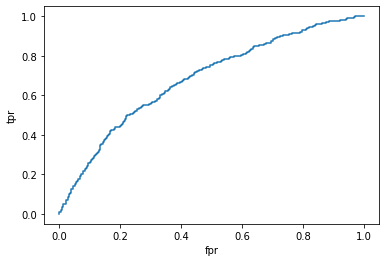

In [32]:
plt.plot(scores['fpr'],scores['tpr']);
plt.ylabel('tpr');
plt.xlabel('fpr');

In [33]:
auc_score = roc_auc_score(y['NEO_N'], y_pred_NEO_N)
auc_score

0.6323920352367798

## Building seperate models M and F models for each target

In [34]:
# Clean sex col- drop nan and convert to single char
sex_df = df
print(sex_df.sex.unique())
sex_df.sex.isnull().sum()
sex_df = sex_df[sex_df.sex.notnull()]
sex_df.sex.replace('female', 'F', inplace=True)
sex_df.sex.replace('male', 'M', inplace=True)
print(sex_df.sex.unique())
sex_df.shape

['F' 'M' nan 'female' 'male']
['F' 'M']


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/pandas/core/generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(1353, 132)

In [35]:
# Make male and female df
f_df = sex_df[sex_df.sex=='F']
m_df = sex_df[sex_df.sex=='M']

In [36]:
# Feature creation
X_f = f_df.iloc[:,11:].reset_index(drop=True)
X_m = m_df.iloc[:,11:].reset_index(drop=True)

In [37]:
# Target creation: 0 = lower, 1 = higher
y_f_disc = f_df.iloc[:,6:11].reset_index(drop=True)
y_f = []
for i in range(5):
    y_f.append(pd.cut(x= y_f_disc.iloc[:,i], 
                    bins= [y_f_disc.iloc[:,i].min()-1, y_f_disc.iloc[:,i].mean(), y_f_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y_f = pd.DataFrame(y_f[0:5]).T.reset_index(drop=True)

y_m_disc = m_df.iloc[:,6:11].reset_index(drop=True)
y_m = []
for i in range(5):
    y_m.append(pd.cut(x= y_m_disc.iloc[:,i], 
                    bins= [y_m_disc.iloc[:,i].min()-1, y_m_disc.iloc[:,i].mean(), y_m_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y_m = pd.DataFrame(y_m[0:5]).T.reset_index(drop=True)

In [38]:
# Normalise features
scaler_f = StandardScaler()
X_f_scaled = scaler_f.fit_transform(X_f)

scaler_m = StandardScaler()
X_m_scaled = scaler_m.fit_transform(X_m)

In [39]:
# Add a constant as a feature to the scaled X
X_f_scaled_int = sm.add_constant(X_f_scaled)
X_f_scaled_int = pd.DataFrame(X_f_scaled_int, columns=pd.Index(['const']).append(X_f.columns))

X_m_scaled_int = sm.add_constant(X_m_scaled)
X_m_scaled_int = pd.DataFrame(X_m_scaled_int, columns=pd.Index(['const']).append(X_f.columns))

In a log reg the coef below show you how the model is made. The const coef means that the value of the const in the feat will be multiplied by the coef- this is why we add a 1 in the const column. The coef in the other columns is the formula for the logit equation.

NEO_N

In [40]:
results_f_NEO_N = sm.Logit(y_f['NEO_N'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.606942
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1232
Time:                        10:22:29   Log-Likelihood:                -441.25
converged:                       True   LL-Null:                       -503.26
Covariance Type:            nonrobust   LLR p-value:                    0.3823
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1069      0.081     -1.314      0.189      -0.266       0.053
lh_bankssts_thickness                     0.0698      0.117      0.595      0.552      -0.160       0.299
lh_caudalanteriorcingulate_thickness     -0.1063      0.114     -0.930      0.353      -0.330       0.118
lh_caudalmiddlefrontal_thickness         -0.0436      0.179     -0.244      0.807      -0.394       0.307
lh_cuneus_thickness                     6.59e-05      0.165      0.000      1.000      -0.323       0.323
lh_entorhinal_thickness                  -0.0282      0.113     -0.251      0.802      -0.249       0.193
lh_fusiform_thickness                     0.2020      0.164      1.235      0.217      -0.119       0.523
lh_inferiorparietal_thickness            -0.2068      0.200     -1.033      0.302      -0.599       0.186
lh_inferiortemporal_thickness            -0.2037      0.173     -1.174      0.240      -0.544       0.136
lh_isthmuscingulate_thickness            -0.0768      0.134     -0.573      0.567      -0.340       0.186
lh_lateraloccipital_thickness             0.0838      0.226      0.372      0.710      -0.358       0.526
lh_lateralorbitofrontal_thickness        -0.0353      0.149     -0.236      0.813      -0.328       0.258
lh_lingual_thickness                      0.0168      0.194      0.087      0.931      -0.364       0.398
lh_medialorbitofrontal_thickness         -0.0527      0.154     -0.343      0.731      -0.354       0.248
lh_middletemporal_thickness              -0.0646      0.176     -0.367      0.713      -0.409       0.280
lh_parahippocampal_thickness             -0.1203      0.131     -0.915      0.360      -0.378       0.137
lh_paracentral_thickness                  0.1091      0.151      0.725      0.469      -0.186       0.404
lh_parsopercularis_thickness             -0.2502      0.146     -1.714      0.087      -0.536       0.036
lh_parsorbitalis_thickness               -0.0525      0.127     -0.412      0.680      -0.302       0.197
lh_parstriangularis_thickness            -0.0116      0.147     -0.079      0.937      -0.300       0.276
lh_pericalcarine_thickness               -0.0063      0.173     -0.036      0.971      -0.346       0.333
lh_postcentral_thickness                 -0.0656      0.184     -0.356      0.722      -0.427       0.295
lh_posteriorcingulate_thickness          -0.0796      0.134     -0.595      0.552      -0.342       0.183
lh_precentral_thickness                  -0.1242      0.208     -0.598      0.550      -0.531       0.283
lh_precuneus_thickness                   -0.0066      0.190     -0.035      0.972      -0.380       0.366
lh_rostralanteriorcingulate_thickness     0.0165      0.113      0.145      0.884      -0.206       0.239
lh_rostralmiddlefrontal_thickness        -0.0678      0.236     -0.287      0.774      -0.531       0.395
lh_superiorfrontal_thickness             -0.5344      0.313  

In [41]:
results_m_NEO_N = sm.Logit(y_m['NEO_N'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.541569
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2186
Time:                        10:22:29   Log-Likelihood:                -339.02
converged:                       True   LL-Null:                       -433.86
Covariance Type:            nonrobust   LLR p-value:                 5.222e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0104      0.095     -0.109      0.913      -0.196       0.176
lh_bankssts_thickness                    -0.0869      0.139     -0.625      0.532      -0.360       0.186
lh_caudalanteriorcingulate_thickness      0.0970      0.124      0.783      0.434      -0.146       0.340
lh_caudalmiddlefrontal_thickness          0.4815      0.215      2.241      0.025       0.060       0.903
lh_cuneus_thickness                      -0.1562      0.182     -0.858      0.391      -0.513       0.201
lh_entorhinal_thickness                  -0.0878      0.133     -0.662      0.508      -0.348       0.172
lh_fusiform_thickness                    -0.1388      0.190     -0.730      0.465      -0.511       0.234
lh_inferiorparietal_thickness             0.1276      0.223      0.571      0.568      -0.310       0.565
lh_inferiortemporal_thickness            -0.0704      0.215     -0.328      0.743      -0.492       0.351
lh_isthmuscingulate_thickness             0.0888      0.143      0.619      0.536      -0.192       0.370
lh_lateraloccipital_thickness            -0.1265      0.246     -0.514      0.607      -0.608       0.355
lh_lateralorbitofrontal_thickness         0.4394      0.184      2.388      0.017       0.079       0.800
lh_lingual_thickness                      0.0112      0.207      0.054      0.957      -0.394       0.416
lh_medialorbitofrontal_thickness          0.0602      0.161      0.373      0.709      -0.256       0.377
lh_middletemporal_thickness               0.1716      0.216      0.793      0.428      -0.253       0.596
lh_parahippocampal_thickness             -0.2811      0.162     -1.731      0.083      -0.599       0.037
lh_paracentral_thickness                  0.0890      0.173      0.515      0.607      -0.250       0.428
lh_parsopercularis_thickness              0.1719      0.168      1.020      0.308      -0.158       0.502
lh_parsorbitalis_thickness               -0.0576      0.158     -0.365      0.715      -0.367       0.252
lh_parstriangularis_thickness            -0.2138      0.176     -1.211      0.226      -0.560       0.132
lh_pericalcarine_thickness                0.4189      0.199      2.108      0.035       0.029       0.808
lh_postcentral_thickness                  0.5065      0.205      2.471      0.013       0.105       0.908
lh_posteriorcingulate_thickness          -0.1752      0.149     -1.179      0.238      -0.466       0.116
lh_precentral_thickness                  -0.5049      0.238     -2.122      0.034      -0.971      -0.039
lh_precuneus_thickness                    0.2426      0.221      1.098      0.272      -0.191       0.676
lh_rostralanteriorcingulate_thickness    -0.1076      0.130     -0.831      0.406      -0.362       0.146
lh_rostralmiddlefrontal_thickness         0.2073      0.273      0.760      0.447      -0.327       0.742
lh_superiorfrontal_thickness             -0.2025      0.342  

In [42]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_N = results_f_NEO_N.predict(X_f_scaled_int)
y_pred_m_proba_NEO_N = results_m_NEO_N.predict(X_m_scaled_int)

y_pred_f_NEO_N = results_f_NEO_N.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_N = results_m_NEO_N.predict(X_m_scaled_int)>0.5

In [43]:
# Print classification reports
print(classification_report(y_f['NEO_N'], y_pred_f_NEO_N))
print(classification_report(y_m['NEO_N'], y_pred_m_NEO_N))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       379
           1       0.64      0.63      0.63       348

    accuracy                           0.65       727
   macro avg       0.65      0.65      0.65       727
weighted avg       0.65      0.65      0.65       727

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       317
           1       0.71      0.71      0.71       309

    accuracy                           0.72       626
   macro avg       0.72      0.72      0.72       626
weighted avg       0.72      0.72      0.72       626



In [44]:
auc_f_NEO_N_score = roc_auc_score(y_f['NEO_N'], y_pred_f_NEO_N)
auc_m_NEO_N_score = roc_auc_score(y_m['NEO_N'], y_pred_m_NEO_N)
print(auc_f_NEO_N_score)
auc_m_NEO_N_score

0.6511843023079489


0.7155268342980816

NEO_E

In [45]:
results_f_NEO_E = sm.Logit(y_f['NEO_E'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_E.summary()

Optimization terminated successfully.
         Current function value: 0.574548
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_E   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1710
Time:                        10:22:29   Log-Likelihood:                -417.70
converged:                       True   LL-Null:                       -503.88
Covariance Type:            nonrobust   LLR p-value:                  0.001234
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0282      0.084      0.334      0.738      -0.137       0.194
lh_bankssts_thickness                     0.0232      0.122      0.190      0.850      -0.216       0.262
lh_caudalanteriorcingulate_thickness      0.0971      0.119      0.814      0.416      -0.137       0.331
lh_caudalmiddlefrontal_thickness         -0.1892      0.186     -1.019      0.308      -0.553       0.175
lh_cuneus_thickness                      -0.1267      0.173     -0.731      0.465      -0.466       0.213
lh_entorhinal_thickness                   0.1740      0.116      1.501      0.133      -0.053       0.401
lh_fusiform_thickness                    -0.0309      0.171     -0.180      0.857      -0.367       0.305
lh_inferiorparietal_thickness             0.1654      0.212      0.781      0.435      -0.250       0.581
lh_inferiortemporal_thickness            -0.0187      0.180     -0.104      0.917      -0.371       0.334
lh_isthmuscingulate_thickness            -0.0294      0.139     -0.211      0.833      -0.303       0.244
lh_lateraloccipital_thickness             0.1732      0.231      0.749      0.454      -0.280       0.626
lh_lateralorbitofrontal_thickness         0.1670      0.157      1.062      0.288      -0.141       0.475
lh_lingual_thickness                      0.0375      0.201      0.187      0.852      -0.356       0.431
lh_medialorbitofrontal_thickness          0.1044      0.159      0.656      0.512      -0.208       0.416
lh_middletemporal_thickness               0.3160      0.182      1.733      0.083      -0.041       0.673
lh_parahippocampal_thickness              0.1020      0.137      0.745      0.456      -0.166       0.370
lh_paracentral_thickness                 -0.1719      0.156     -1.101      0.271      -0.478       0.134
lh_parsopercularis_thickness              0.2219      0.152      1.465      0.143      -0.075       0.519
lh_parsorbitalis_thickness               -0.1049      0.131     -0.802      0.422      -0.361       0.151
lh_parstriangularis_thickness             0.1722      0.152      1.131      0.258      -0.126       0.471
lh_pericalcarine_thickness               -0.1543      0.179     -0.863      0.388      -0.505       0.196
lh_postcentral_thickness                  0.3967      0.194      2.041      0.041       0.016       0.778
lh_posteriorcingulate_thickness          -0.0470      0.142     -0.332      0.740      -0.324       0.231
lh_precentral_thickness                   0.5817      0.214      2.712      0.007       0.161       1.002
lh_precuneus_thickness                    0.5033      0.200      2.521      0.012       0.112       0.895
lh_rostralanteriorcingulate_thickness     0.0880      0.115      0.767      0.443      -0.137       0.313
lh_rostralmiddlefrontal_thickness        -0.0999      0.242     -0.413      0.680      -0.574       0.374
lh_superiorfrontal_thickness              0.5217      0.327  

In [46]:
results_m_NEO_E = sm.Logit(y_m['NEO_E'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_E.summary()

Optimization terminated successfully.
         Current function value: 0.569073
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_E   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1749
Time:                        10:22:29   Log-Likelihood:                -356.24
converged:                       True   LL-Null:                       -431.75
Covariance Type:            nonrobust   LLR p-value:                   0.02912
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2240      0.093      2.404      0.016       0.041       0.407
lh_bankssts_thickness                     0.0381      0.132      0.288      0.773      -0.221       0.297
lh_caudalanteriorcingulate_thickness      0.0627      0.122      0.516      0.606      -0.175       0.301
lh_caudalmiddlefrontal_thickness         -0.0130      0.207     -0.063      0.950      -0.419       0.393
lh_cuneus_thickness                      -0.0007      0.176     -0.004      0.997      -0.346       0.345
lh_entorhinal_thickness                   0.2463      0.129      1.912      0.056      -0.006       0.499
lh_fusiform_thickness                     0.0572      0.181      0.316      0.752      -0.298       0.413
lh_inferiorparietal_thickness            -0.0101      0.214     -0.047      0.962      -0.430       0.410
lh_inferiortemporal_thickness             0.0522      0.205      0.255      0.799      -0.349       0.453
lh_isthmuscingulate_thickness             0.0660      0.138      0.479      0.632      -0.204       0.336
lh_lateraloccipital_thickness             0.4566      0.241      1.893      0.058      -0.016       0.929
lh_lateralorbitofrontal_thickness         0.3769      0.176      2.147      0.032       0.033       0.721
lh_lingual_thickness                     -0.0030      0.203     -0.015      0.988      -0.402       0.396
lh_medialorbitofrontal_thickness         -0.1656      0.154     -1.074      0.283      -0.468       0.136
lh_middletemporal_thickness               0.0176      0.208      0.085      0.933      -0.390       0.425
lh_parahippocampal_thickness              0.3375      0.152      2.222      0.026       0.040       0.635
lh_paracentral_thickness                  0.0360      0.169      0.213      0.832      -0.296       0.368
lh_parsopercularis_thickness             -0.1738      0.161     -1.082      0.279      -0.489       0.141
lh_parsorbitalis_thickness                0.0021      0.154      0.014      0.989      -0.300       0.304
lh_parstriangularis_thickness            -0.1275      0.171     -0.746      0.456      -0.462       0.208
lh_pericalcarine_thickness               -0.0649      0.182     -0.356      0.722      -0.422       0.293
lh_postcentral_thickness                  0.1456      0.197      0.741      0.459      -0.240       0.531
lh_posteriorcingulate_thickness          -0.1511      0.144     -1.052      0.293      -0.433       0.130
lh_precentral_thickness                   0.6443      0.232      2.782      0.005       0.190       1.098
lh_precuneus_thickness                    0.0717      0.218      0.329      0.742      -0.356       0.499
lh_rostralanteriorcingulate_thickness    -0.0937      0.126     -0.743      0.457      -0.341       0.153
lh_rostralmiddlefrontal_thickness        -0.0131      0.270     -0.048      0.961      -0.541       0.515
lh_superiorfrontal_thickness              0.3058      0.322  

In [47]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_E = results_f_NEO_E.predict(X_f_scaled_int) # add constant to feat
y_pred_m_proba_NEO_E = results_m_NEO_E.predict(X_m_scaled_int)
y_pred_f_NEO_E = results_f_NEO_E.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_E = results_m_NEO_E.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_E'], y_pred_f_NEO_E))
print(classification_report(y_m['NEO_E'], y_pred_m_NEO_E))
auc_f_NEO_E_score = roc_auc_score(y_f['NEO_E'], y_pred_f_NEO_E)
auc_m_NEO_E_score = roc_auc_score(y_m['NEO_E'], y_pred_m_NEO_E)
print(auc_f_NEO_E_score)
auc_m_NEO_E_score

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       360
           1       0.69      0.69      0.69       367

    accuracy                           0.69       727
   macro avg       0.69      0.69      0.69       727
weighted avg       0.69      0.69      0.69       727

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       287
           1       0.70      0.73      0.72       339

    accuracy                           0.69       626
   macro avg       0.68      0.68      0.68       626
weighted avg       0.69      0.69      0.69       626

0.6876892219194671


0.6833893496962783

NEO_O

In [48]:
results_f_NEO_O = sm.Logit(y_f['NEO_O'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_O.summary()

Optimization terminated successfully.
         Current function value: 0.572967
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_O   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1732
Time:                        10:22:30   Log-Likelihood:                -416.55
converged:                       True   LL-Null:                       -503.80
Covariance Type:            nonrobust   LLR p-value:                 0.0008582
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0431      0.085      0.510      0.610      -0.123       0.209
lh_bankssts_thickness                     0.0642      0.123      0.521      0.602      -0.177       0.306
lh_caudalanteriorcingulate_thickness      0.0774      0.120      0.647      0.518      -0.157       0.312
lh_caudalmiddlefrontal_thickness         -0.1074      0.190     -0.565      0.572      -0.480       0.265
lh_cuneus_thickness                      -0.2948      0.173     -1.704      0.088      -0.634       0.044
lh_entorhinal_thickness                   0.1255      0.117      1.075      0.282      -0.103       0.354
lh_fusiform_thickness                    -0.3528      0.170     -2.075      0.038      -0.686      -0.020
lh_inferiorparietal_thickness             0.3182      0.207      1.535      0.125      -0.088       0.724
lh_inferiortemporal_thickness            -0.1125      0.182     -0.619      0.536      -0.469       0.244
lh_isthmuscingulate_thickness             0.0097      0.139      0.070      0.944      -0.263       0.283
lh_lateraloccipital_thickness            -0.2102      0.237     -0.888      0.375      -0.674       0.254
lh_lateralorbitofrontal_thickness         0.0150      0.155      0.097      0.923      -0.289       0.319
lh_lingual_thickness                     -0.0437      0.203     -0.215      0.830      -0.442       0.355
lh_medialorbitofrontal_thickness          0.0148      0.161      0.092      0.927      -0.301       0.331
lh_middletemporal_thickness              -0.1484      0.184     -0.806      0.420      -0.509       0.213
lh_parahippocampal_thickness             -0.1879      0.137     -1.368      0.171      -0.457       0.081
lh_paracentral_thickness                 -0.0692      0.156     -0.442      0.658      -0.376       0.237
lh_parsopercularis_thickness              0.1986      0.152      1.303      0.193      -0.100       0.497
lh_parsorbitalis_thickness               -0.2634      0.134     -1.966      0.049      -0.526      -0.001
lh_parstriangularis_thickness            -0.0631      0.153     -0.412      0.680      -0.363       0.237
lh_pericalcarine_thickness                0.0212      0.181      0.117      0.907      -0.334       0.376
lh_postcentral_thickness                 -0.0409      0.194     -0.211      0.833      -0.421       0.340
lh_posteriorcingulate_thickness           0.1920      0.140      1.374      0.169      -0.082       0.466
lh_precentral_thickness                   0.1914      0.211      0.907      0.364      -0.222       0.605
lh_precuneus_thickness                    0.3856      0.197      1.961      0.050       0.000       0.771
lh_rostralanteriorcingulate_thickness    -0.0662      0.119     -0.554      0.579      -0.300       0.168
lh_rostralmiddlefrontal_thickness         0.1225      0.242      0.507      0.612      -0.351       0.596
lh_superiorfrontal_thickness              0.2417      0.328  

In [49]:
results_m_NEO_O = sm.Logit(y_m['NEO_O'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_O.summary()

Optimization terminated successfully.
         Current function value: 0.578433
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_O   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1650
Time:                        10:22:30   Log-Likelihood:                -362.10
converged:                       True   LL-Null:                       -433.65
Covariance Type:            nonrobust   LLR p-value:                   0.07387
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0737      0.091      0.813      0.416      -0.104       0.251
lh_bankssts_thickness                     0.1088      0.131      0.829      0.407      -0.148       0.366
lh_caudalanteriorcingulate_thickness      0.0670      0.120      0.560      0.575      -0.167       0.301
lh_caudalmiddlefrontal_thickness          0.2881      0.206      1.395      0.163      -0.117       0.693
lh_cuneus_thickness                      -0.0322      0.175     -0.184      0.854      -0.376       0.311
lh_entorhinal_thickness                   0.1499      0.126      1.187      0.235      -0.098       0.397
lh_fusiform_thickness                     0.3773      0.184      2.052      0.040       0.017       0.738
lh_inferiorparietal_thickness            -0.0462      0.212     -0.218      0.827      -0.462       0.369
lh_inferiortemporal_thickness             0.2357      0.205      1.148      0.251      -0.167       0.638
lh_isthmuscingulate_thickness            -0.0152      0.139     -0.110      0.913      -0.287       0.257
lh_lateraloccipital_thickness            -0.2329      0.236     -0.988      0.323      -0.695       0.229
lh_lateralorbitofrontal_thickness         0.5080      0.176      2.881      0.004       0.162       0.854
lh_lingual_thickness                      0.0907      0.197      0.460      0.646      -0.296       0.477
lh_medialorbitofrontal_thickness         -0.0460      0.156     -0.294      0.769      -0.353       0.261
lh_middletemporal_thickness              -0.3316      0.203     -1.632      0.103      -0.730       0.067
lh_parahippocampal_thickness             -0.1229      0.152     -0.806      0.420      -0.422       0.176
lh_paracentral_thickness                  0.2701      0.165      1.641      0.101      -0.053       0.593
lh_parsopercularis_thickness             -0.1393      0.158     -0.880      0.379      -0.450       0.171
lh_parsorbitalis_thickness                0.1453      0.153      0.949      0.343      -0.155       0.445
lh_parstriangularis_thickness             0.1421      0.168      0.844      0.399      -0.188       0.472
lh_pericalcarine_thickness                0.2091      0.185      1.129      0.259      -0.154       0.572
lh_postcentral_thickness                  0.0953      0.194      0.490      0.624      -0.286       0.476
lh_posteriorcingulate_thickness           0.0853      0.144      0.592      0.554      -0.197       0.368
lh_precentral_thickness                  -0.0711      0.226     -0.314      0.753      -0.514       0.372
lh_precuneus_thickness                    0.0665      0.211      0.315      0.753      -0.347       0.480
lh_rostralanteriorcingulate_thickness    -0.1043      0.126     -0.826      0.409      -0.352       0.143
lh_rostralmiddlefrontal_thickness         0.3013      0.270      1.116      0.264      -0.228       0.830
lh_superiorfrontal_thickness             -0.1906      0.325  

In [50]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_O = results_f_NEO_O.predict(X_f_scaled_int)
y_pred_m_proba_NEO_O = results_m_NEO_O.predict(X_m_scaled_int)
y_pred_f_NEO_O = results_f_NEO_O.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_O = results_m_NEO_O.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_O'], y_pred_f_NEO_O))
print(classification_report(y_m['NEO_O'], y_pred_m_NEO_O))
auc_f_NEO_O_score = roc_auc_score(y_f['NEO_O'], y_pred_f_NEO_O)
auc_m_NEO_O_score = roc_auc_score(y_m['NEO_O'], y_pred_m_NEO_O)
print(auc_f_NEO_O_score)
auc_m_NEO_O_score

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       357
           1       0.70      0.72      0.71       370

    accuracy                           0.70       727
   macro avg       0.70      0.70      0.70       727
weighted avg       0.70      0.70      0.70       727

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       304
           1       0.68      0.70      0.69       322

    accuracy                           0.68       626
   macro avg       0.68      0.68      0.68       626
weighted avg       0.68      0.68      0.68       626

0.698345824816413


0.6797871036286368

NEO_A

In [51]:
results_f_NEO_A = sm.Logit(y_f['NEO_A'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_A.summary()

Optimization terminated successfully.
         Current function value: 0.581231
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_A   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1527
Time:                        10:22:30   Log-Likelihood:                -422.56
converged:                       True   LL-Null:                       -498.70
Covariance Type:            nonrobust   LLR p-value:                   0.02475
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.3144      0.085      3.709      0.000       0.148       0.481
lh_bankssts_thickness                    -0.0869      0.121     -0.720      0.472      -0.324       0.150
lh_caudalanteriorcingulate_thickness     -0.0965      0.120     -0.807      0.420      -0.331       0.138
lh_caudalmiddlefrontal_thickness         -0.0222      0.187     -0.119      0.905      -0.388       0.344
lh_cuneus_thickness                      -0.0347      0.171     -0.203      0.839      -0.369       0.300
lh_entorhinal_thickness                  -0.1510      0.116     -1.300      0.194      -0.379       0.077
lh_fusiform_thickness                    -0.0490      0.170     -0.287      0.774      -0.383       0.285
lh_inferiorparietal_thickness             0.3178      0.205      1.547      0.122      -0.085       0.720
lh_inferiortemporal_thickness            -0.1858      0.180     -1.033      0.302      -0.538       0.167
lh_isthmuscingulate_thickness            -0.0977      0.138     -0.711      0.477      -0.367       0.172
lh_lateraloccipital_thickness            -0.2084      0.229     -0.910      0.363      -0.657       0.240
lh_lateralorbitofrontal_thickness         0.0232      0.154      0.150      0.881      -0.279       0.326
lh_lingual_thickness                      0.0730      0.201      0.363      0.717      -0.321       0.467
lh_medialorbitofrontal_thickness         -0.2000      0.158     -1.268      0.205      -0.509       0.109
lh_middletemporal_thickness               0.0224      0.182      0.123      0.902      -0.333       0.378
lh_parahippocampal_thickness              0.0335      0.136      0.246      0.806      -0.234       0.301
lh_paracentral_thickness                 -0.1705      0.154     -1.105      0.269      -0.473       0.132
lh_parsopercularis_thickness             -0.2821      0.150     -1.886      0.059      -0.575       0.011
lh_parsorbitalis_thickness               -0.0726      0.131     -0.555      0.579      -0.329       0.184
lh_parstriangularis_thickness            -0.0600      0.153     -0.392      0.695      -0.360       0.240
lh_pericalcarine_thickness                0.2381      0.177      1.345      0.179      -0.109       0.585
lh_postcentral_thickness                 -0.1317      0.190     -0.695      0.487      -0.503       0.240
lh_posteriorcingulate_thickness           0.0023      0.139      0.016      0.987      -0.270       0.275
lh_precentral_thickness                   0.3215      0.212      1.519      0.129      -0.093       0.736
lh_precuneus_thickness                    0.0084      0.195      0.043      0.966      -0.373       0.390
lh_rostralanteriorcingulate_thickness     0.0687      0.116      0.595      0.552      -0.158       0.295
lh_rostralmiddlefrontal_thickness         0.3050      0.241      1.264      0.206      -0.168       0.778
lh_superiorfrontal_thickness             -0.4532      0.322  

In [52]:
results_m_NEO_A = sm.Logit(y_m['NEO_A'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_A.summary()

Optimization terminated successfully.
         Current function value: 0.562276
         Iterations 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_A   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1847
Time:                        10:22:30   Log-Likelihood:                -351.98
converged:                       True   LL-Null:                       -431.75
Covariance Type:            nonrobust   LLR p-value:                  0.009206
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2482      0.094      2.641      0.008       0.064       0.432
lh_bankssts_thickness                     0.0682      0.133      0.512      0.609      -0.193       0.329
lh_caudalanteriorcingulate_thickness      0.1929      0.126      1.525      0.127      -0.055       0.441
lh_caudalmiddlefrontal_thickness          0.1660      0.209      0.792      0.428      -0.245       0.577
lh_cuneus_thickness                      -0.0070      0.179     -0.039      0.969      -0.358       0.344
lh_entorhinal_thickness                   0.0057      0.127      0.045      0.964      -0.243       0.255
lh_fusiform_thickness                    -0.2899      0.186     -1.556      0.120      -0.655       0.075
lh_inferiorparietal_thickness             0.0610      0.218      0.280      0.780      -0.366       0.488
lh_inferiortemporal_thickness             0.5693      0.213      2.671      0.008       0.152       0.987
lh_isthmuscingulate_thickness            -0.0477      0.139     -0.344      0.731      -0.319       0.224
lh_lateraloccipital_thickness             0.1223      0.242      0.506      0.613      -0.351       0.596
lh_lateralorbitofrontal_thickness         0.2227      0.176      1.269      0.205      -0.121       0.567
lh_lingual_thickness                      0.1867      0.197      0.948      0.343      -0.199       0.573
lh_medialorbitofrontal_thickness         -0.0210      0.159     -0.132      0.895      -0.333       0.291
lh_middletemporal_thickness              -0.2934      0.211     -1.388      0.165      -0.708       0.121
lh_parahippocampal_thickness             -0.1504      0.153     -0.980      0.327      -0.451       0.150
lh_paracentral_thickness                 -0.0935      0.169     -0.552      0.581      -0.426       0.239
lh_parsopercularis_thickness              0.0191      0.162      0.118      0.906      -0.299       0.337
lh_parsorbitalis_thickness                0.1924      0.156      1.233      0.218      -0.114       0.498
lh_parstriangularis_thickness             0.1485      0.173      0.858      0.391      -0.191       0.488
lh_pericalcarine_thickness               -0.4758      0.191     -2.486      0.013      -0.851      -0.101
lh_postcentral_thickness                  0.0416      0.199      0.209      0.835      -0.349       0.432
lh_posteriorcingulate_thickness           0.0932      0.144      0.647      0.518      -0.189       0.376
lh_precentral_thickness                  -0.1881      0.229     -0.822      0.411      -0.636       0.260
lh_precuneus_thickness                    0.3789      0.219      1.730      0.084      -0.050       0.808
lh_rostralanteriorcingulate_thickness    -0.1072      0.130     -0.822      0.411      -0.363       0.148
lh_rostralmiddlefrontal_thickness         0.3472      0.275      1.263      0.206      -0.192       0.886
lh_superiorfrontal_thickness              0.0251      0.333  

In [53]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_A = results_f_NEO_A.predict(X_f_scaled_int)
y_pred_m_proba_NEO_A = results_m_NEO_A.predict(X_m_scaled_int)
y_pred_f_NEO_A = results_f_NEO_A.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_A = results_m_NEO_A.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_A'], y_pred_f_NEO_A))
print(classification_report(y_m['NEO_A'], y_pred_m_NEO_A))
auc_f_NEO_A_score = roc_auc_score(y_f['NEO_A'], y_pred_f_NEO_A)
auc_m_NEO_A_score = roc_auc_score(y_m['NEO_A'], y_pred_m_NEO_A)
print(auc_f_NEO_A_score)
auc_m_NEO_A_score

              precision    recall  f1-score   support

           0       0.67      0.62      0.65       320
           1       0.72      0.76      0.74       407

    accuracy                           0.70       727
   macro avg       0.70      0.69      0.69       727
weighted avg       0.70      0.70      0.70       727

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       287
           1       0.74      0.75      0.75       339

    accuracy                           0.72       626
   macro avg       0.72      0.72      0.72       626
weighted avg       0.72      0.72      0.72       626

0.6917728808353808


0.7193117696031576

NEO_C

In [54]:
results_f_NEO_C = sm.Logit(y_f['NEO_C'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_C.summary()

         Current function value: 0.540476
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_C   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2202
Time:                        10:22:30   Log-Likelihood:                -392.93
converged:                      False   LL-Null:                       -503.86
Covariance Type:            nonrobust   LLR p-value:                 4.562e-08
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2337   2015.447      0.000      1.000   -3949.969    3950.436
lh_bankssts_thickness                     0.0521      0.128      0.409      0.683      -0.198       0.302
lh_caudalanteriorcingulate_thickness      0.1814      0.125      1.454      0.146      -0.063       0.426
lh_caudalmiddlefrontal_thickness         -0.4314      0.194     -2.219      0.027      -0.812      -0.050
lh_cuneus_thickness                       0.0579      0.180      0.321      0.748      -0.296       0.412
lh_entorhinal_thickness                   0.3278      0.123      2.674      0.008       0.087       0.568
lh_fusiform_thickness                    -0.0882      0.178     -0.495      0.621      -0.438       0.261
lh_inferiorparietal_thickness             0.1635      0.213      0.766      0.444      -0.255       0.582
lh_inferiortemporal_thickness             0.1628      0.192      0.846      0.397      -0.214       0.540
lh_isthmuscingulate_thickness            -0.0814      0.143     -0.567      0.571      -0.363       0.200
lh_lateraloccipital_thickness            -0.1770      0.241     -0.735      0.463      -0.649       0.295
lh_lateralorbitofrontal_thickness        -0.2718      0.163     -1.670      0.095      -0.591       0.047
lh_lingual_thickness                     -0.3641      0.210     -1.734      0.083      -0.776       0.048
lh_medialorbitofrontal_thickness          0.0500      0.164      0.305      0.761      -0.271       0.371
lh_middletemporal_thickness              -0.2158      0.189     -1.139      0.255      -0.587       0.155
lh_parahippocampal_thickness              0.0773      0.142      0.545      0.586      -0.201       0.355
lh_paracentral_thickness                  0.0572      0.162      0.353      0.724      -0.260       0.374
lh_parsopercularis_thickness             -0.0728      0.156     -0.465      0.642      -0.379       0.234
lh_parsorbitalis_thickness                0.0833      0.136      0.614      0.539      -0.183       0.349
lh_parstriangularis_thickness             0.0474      0.156      0.304      0.761      -0.259       0.353
lh_pericalcarine_thickness               -0.0096      0.184     -0.052      0.959      -0.371       0.352
lh_postcentral_thickness                  0.1749      0.202      0.864      0.388      -0.222       0.571
lh_posteriorcingulate_thickness           0.0411      0.146      0.281      0.779      -0.245       0.328
lh_precentral_thickness                  -0.0710      0.222     -0.320      0.749      -0.506       0.364
lh_precuneus_thickness                    0.3537      0.205      1.724      0.085      -0.048       0.756
lh_rostralanteriorcingulate_thickness     0.1109      0.121      0.918      0.359      -0.126       0.348
lh_rostralmiddlefrontal_thickness         0.2085      0.250      0.834      0.404      -0.281       0.698
lh_superiorfrontal_thickness              0.1493      0.339  

In [55]:
results_m_NEO_C = sm.Logit(y_m['NEO_C'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_C.summary()

Optimization terminated successfully.
         Current function value: 0.539127
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_C   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2221
Time:                        10:22:31   Log-Likelihood:                -337.49
converged:                       True   LL-Null:                       -433.86
Covariance Type:            nonrobust   LLR p-value:                 2.843e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0423      0.096      0.442      0.659      -0.145       0.230
lh_bankssts_thickness                    -0.3562      0.138     -2.583      0.010      -0.627      -0.086
lh_caudalanteriorcingulate_thickness      0.0169      0.125      0.135      0.893      -0.229       0.263
lh_caudalmiddlefrontal_thickness          0.0601      0.218      0.276      0.783      -0.367       0.488
lh_cuneus_thickness                      -0.0551      0.186     -0.296      0.768      -0.420       0.310
lh_entorhinal_thickness                   0.2456      0.132      1.864      0.062      -0.013       0.504
lh_fusiform_thickness                     0.2549      0.190      1.339      0.181      -0.118       0.628
lh_inferiorparietal_thickness            -0.0332      0.222     -0.149      0.881      -0.468       0.402
lh_inferiortemporal_thickness            -0.0388      0.215     -0.180      0.857      -0.461       0.383
lh_isthmuscingulate_thickness            -0.0189      0.146     -0.130      0.897      -0.304       0.267
lh_lateraloccipital_thickness            -0.2865      0.249     -1.151      0.250      -0.774       0.201
lh_lateralorbitofrontal_thickness        -0.1418      0.183     -0.777      0.437      -0.500       0.216
lh_lingual_thickness                      0.3376      0.207      1.633      0.102      -0.068       0.743
lh_medialorbitofrontal_thickness         -0.1216      0.164     -0.742      0.458      -0.443       0.200
lh_middletemporal_thickness              -0.0718      0.215     -0.333      0.739      -0.494       0.351
lh_parahippocampal_thickness              0.1091      0.159      0.687      0.492      -0.202       0.420
lh_paracentral_thickness                 -0.0110      0.173     -0.064      0.949      -0.350       0.328
lh_parsopercularis_thickness              0.0517      0.171      0.302      0.763      -0.284       0.387
lh_parsorbitalis_thickness               -0.0051      0.163     -0.031      0.975      -0.325       0.314
lh_parstriangularis_thickness            -0.3047      0.177     -1.722      0.085      -0.652       0.042
lh_pericalcarine_thickness               -0.3103      0.196     -1.581      0.114      -0.695       0.074
lh_postcentral_thickness                  0.0357      0.205      0.174      0.862      -0.367       0.438
lh_posteriorcingulate_thickness           0.3067      0.153      2.004      0.045       0.007       0.607
lh_precentral_thickness                  -0.1973      0.231     -0.854      0.393      -0.650       0.256
lh_precuneus_thickness                   -0.4432      0.219     -2.028      0.043      -0.872      -0.015
lh_rostralanteriorcingulate_thickness    -0.0735      0.134     -0.548      0.584      -0.336       0.189
lh_rostralmiddlefrontal_thickness         0.4865      0.284      1.716      0.086      -0.069       1.042
lh_superiorfrontal_thickness             -0.2738      0.339  

In [56]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_C = results_f_NEO_C.predict(X_f_scaled_int)
y_pred_m_proba_NEO_C = results_m_NEO_C.predict(X_m_scaled_int)
y_pred_f_NEO_C = results_f_NEO_C.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_C = results_m_NEO_C.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_C'], y_pred_f_NEO_C))
print(classification_report(y_m['NEO_C'], y_pred_m_NEO_C))
auc_f_NEO_C_score = roc_auc_score(y_f['NEO_C'], y_pred_f_NEO_C)
auc_m_NEO_C_score = roc_auc_score(y_m['NEO_C'], y_pred_m_NEO_C)
print(auc_f_NEO_C_score)
auc_m_NEO_C_score

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       368
           1       0.74      0.68      0.71       359

    accuracy                           0.72       727
   macro avg       0.72      0.72      0.72       727
weighted avg       0.72      0.72      0.72       727

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       309
           1       0.74      0.72      0.73       317

    accuracy                           0.73       626
   macro avg       0.73      0.73      0.73       626
weighted avg       0.73      0.73      0.73       626

0.7216604093496427


0.733367022959991

## Feature selection

Show the most important features for each target

In [57]:
NEO_N_f_best_feats = pd.DataFrame([results_f_NEO_N.params, results_f_NEO_N.pvalues], index=['coef', 'p-value']).T
NEO_N_f_best_feats[NEO_N_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_inferiorparietal_thickness,0.680723,0.004122
rh_superiortemporal_thickness,0.659949,0.003842
rh_caudalmiddlefrontal_thickness,0.488085,0.011560
rh_rostralmiddlefrontal_thickness,0.458638,0.049064
lh_frontalpole_thickness,-0.214385,0.039067
Right-vessel,-0.226084,0.032537
CC_Anterior,-0.398078,0.002878
rh_MeanThickness_thickness,-3.206932,0.032554


In [58]:
NEO_N_m_best_feats = pd.DataFrame([results_m_NEO_N.params, results_m_NEO_N.pvalues], index=['coef', 'p-value']).T
NEO_N_m_best_feats[NEO_N_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Putamen,1.226167,0.002156
Right-Thalamus-Proper,0.998181,0.027834
Right-VentralDC,0.949991,0.011799
Left-Caudate,0.815707,0.015307
Left-Hippocampus,0.771910,0.012652
rh_superiorfrontal_thickness,0.763971,0.017087
rh_superiorparietal_thickness,0.636964,0.034512
rh_lateraloccipital_thickness,0.561852,0.017138
rh_superiortemporal_thickness,0.540967,0.023359
lh_postcentral_thickness,0.506518,0.013475


In [59]:
NEO_E_f_best_feats = pd.DataFrame([results_f_NEO_E.params, results_f_NEO_E.pvalues], index=['coef', 'p-value']).T
NEO_E_f_best_feats[NEO_E_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
lh_precentral_thickness,0.581720,0.006684
lh_precuneus_thickness,0.503308,0.011708
Right-choroid-plexus,0.459772,0.006218
lh_postcentral_thickness,0.396695,0.041240
CC_Anterior,-0.276763,0.045280
WM-hypointensities,-0.304309,0.034821
Left-choroid-plexus,-0.366739,0.026199
rh_lateraloccipital_thickness,-0.522912,0.014149
rh_postcentral_thickness,-0.533191,0.006815
rh_inferiorparietal_thickness,-0.565461,0.022222


In [60]:
NEO_E_m_best_feats = pd.DataFrame([results_m_NEO_E.params, results_m_NEO_E.pvalues], index=['coef', 'p-value']).T
NEO_E_m_best_feats[NEO_E_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
SubCortGrayVol,5.918317,0.018465
eTIV,2.169573,0.015745
MaskVol-to-eTIV,1.290700,0.022001
lh_precentral_thickness,0.644339,0.005407
lh_supramarginal_thickness,0.537399,0.008574
Optic-Chiasm,0.467495,0.011669
rh_superiortemporal_thickness,0.462090,0.042694
rh_parstriangularis_thickness,0.454026,0.013940
lh_lateralorbitofrontal_thickness,0.376931,0.031813
lh_parahippocampal_thickness,0.337516,0.026303


In [61]:
NEO_O_f_best_feats = pd.DataFrame([results_f_NEO_O.params, results_f_NEO_O.pvalues], index=['coef', 'p-value']).T
NEO_O_f_best_feats[NEO_O_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Pallidum,0.570696,0.034797
rh_transversetemporal_thickness,0.418839,0.001402
lh_insula_thickness,0.416475,0.005060
lh_precuneus_thickness,0.385624,0.049852
CSF,0.346108,0.017420
lh_parsorbitalis_thickness,-0.263386,0.049347
lh_transversetemporal_thickness,-0.279152,0.028465
Left-Inf-Lat-Vent,-0.295894,0.016548
lh_fusiform_thickness,-0.352775,0.037998
Left-Pallidum,-0.917862,0.000267


In [62]:
NEO_O_m_best_feats = pd.DataFrame([results_m_NEO_O.params, results_m_NEO_O.pvalues], index=['coef', 'p-value']).T
NEO_O_m_best_feats[NEO_O_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
eTIV,3.607364,0.000061
MaskVol-to-eTIV,2.423706,0.000017
rh_superiorparietal_thickness,0.641404,0.025766
lh_lateralorbitofrontal_thickness,0.507976,0.003970
lh_fusiform_thickness,0.377256,0.040213
lh_frontalpole_thickness,-0.305868,0.008875
Right-Accumbens-area,-0.481687,0.004991


In [63]:
NEO_A_f_best_feats = pd.DataFrame([results_f_NEO_A.params, results_f_NEO_A.pvalues], index=['coef', 'p-value']).T
NEO_A_f_best_feats[NEO_A_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Accumbens-area,0.579988,0.032717
Left-Pallidum,0.488993,0.043357
rh_caudalanteriorcingulate_thickness,0.370591,0.006390
const,0.314393,0.000208
rh_rostralanteriorcingulate_thickness,-0.244393,0.039918
CSF,-0.305265,0.032109


In [64]:
NEO_A_m_best_feats = pd.DataFrame([results_m_NEO_A.params, results_m_NEO_A.pvalues], index=['coef', 'p-value']).T
NEO_A_m_best_feats[NEO_A_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_pericalcarine_thickness,0.725548,0.000297
lh_inferiortemporal_thickness,0.569302,0.007569
Left-choroid-plexus,0.385850,0.023732
CC_Anterior,0.384347,0.008878
WM-hypointensities,0.369640,0.015974
const,0.248212,0.008262
lh_pericalcarine_thickness,-0.475762,0.012904


In [65]:
NEO_C_f_best_feats = pd.DataFrame([results_f_NEO_C.params, results_f_NEO_C.pvalues], index=['coef', 'p-value']).T
NEO_C_f_best_feats[NEO_C_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
WM-hypointensities,0.352077,0.021554
CC_Mid_Anterior,0.329098,0.030900
lh_entorhinal_thickness,0.327801,0.007506
Right-vessel,0.230417,0.043192
lh_caudalmiddlefrontal_thickness,-0.431411,0.026502
CC_Posterior,-0.540271,0.001294


In [66]:
NEO_C_m_best_feats = pd.DataFrame([results_m_NEO_C.params, results_m_NEO_C.pvalues], index=['coef', 'p-value']).T
NEO_C_m_best_feats[NEO_C_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_precentral_thickness,0.616298,0.012280
Optic-Chiasm,0.444027,0.020065
CC_Posterior,0.401906,0.022895
WM-hypointensities,0.395242,0.023259
rh_parsopercularis_thickness,0.373941,0.017301
lh_posteriorcingulate_thickness,0.306737,0.045080
lh_bankssts_thickness,-0.356225,0.009795
rh_paracentral_thickness,-0.375273,0.046273
lh_supramarginal_thickness,-0.411994,0.047921
lh_precuneus_thickness,-0.443185,0.042600


In order to do feature permutation need to make an sklearn model as this function will not work with statsmodel.

NEO_N

In [67]:
# # Use this to get an idea how sklearn models are created
# # need to remove const from coef and put this in int- then use X without const
# sk_lr = LogisticRegression()
# sk_lr.fit(X_f_scaled_int, y_f['NEO_N'])
# sk_lr.coef_
# sk_lr.intercept_
# sk_lr.classes_

In [68]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_NEO_N.params[1:]])
sk_lr.intercept_ = np.array([results_f_NEO_N.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_NEO_N_score = permutation_importance(sk_lr, X_f_scaled, y_f['NEO_N'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_NEO_N = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_NEO_N_score.importances_mean)).T) # Unstack results
importance_f_NEO_N.columns=['feature','score decrease']
importance_f_NEO_N.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_NEO_N

,feature,score decrease
116,TotalGrayVol,0.137276
35,BrainSegVolNotVent,0.1326
114,CerebralWhiteMatterVol,0.122146
71,rh_MeanThickness_thickness,0.11293
36,eTIV,0.098487
...,...,...
118,lhSurfaceHoles,-0.016644
50,rh_middletemporal_thickness,-0.017744
45,rh_isthmuscingulate_thickness,-0.018707
79,Left-Pallidum,-0.019257


In [69]:
# The model is just using size of the largest areas!
importance_f_NEO_N.head(10)

,feature,score decrease
116,TotalGrayVol,0.137276
35,BrainSegVolNotVent,0.1326
114,CerebralWhiteMatterVol,0.122146
71,rh_MeanThickness_thickness,0.11293
36,eTIV,0.098487
34,lh_MeanThickness_thickness,0.08597
113,CortexVol,0.079642
43,rh_inferiorparietal_thickness,0.055296
75,Left-Cerebellum-Cortex,0.05392
117,MaskVol-to-eTIV,0.052682


In [70]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_m_NEO_N.params[1:]])
sk_lr.intercept_ = np.array([results_m_NEO_N.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_m_NEO_N_score = permutation_importance(sk_lr, X_m_scaled, y_m['NEO_N'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_m_NEO_N = pd.DataFrame(np.vstack((X.columns,\
        permutation_m_NEO_N_score.importances_mean)).T) # Unstack results
importance_m_NEO_N.columns=['feature','score decrease']
importance_m_NEO_N.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_m_NEO_N

,feature,score decrease
116,TotalGrayVol,0.227476
114,CerebralWhiteMatterVol,0.217412
35,BrainSegVolNotVent,0.184345
113,CortexVol,0.161342
115,SubCortGrayVol,0.146645
...,...,...
4,lh_entorhinal_thickness,-0.001917
8,lh_isthmuscingulate_thickness,-0.002396
110,CC_Central,-0.002875
6,lh_inferiorparietal_thickness,-0.003195


In [71]:
# The model is just using size of the largest areas!
importance_m_NEO_N.head(10)

,feature,score decrease
116,TotalGrayVol,0.227476
114,CerebralWhiteMatterVol,0.217412
35,BrainSegVolNotVent,0.184345
113,CortexVol,0.161342
115,SubCortGrayVol,0.146645
71,rh_MeanThickness_thickness,0.140256
96,Right-Putamen,0.107029
92,Right-Cerebellum-White-Matter,0.094888
94,Right-Thalamus-Proper,0.090415
93,Right-Cerebellum-Cortex,0.08754


NEO_E

In [72]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_NEO_E.params[1:]])
sk_lr.intercept_ = np.array([results_f_NEO_E.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_NEO_E_score = permutation_importance(sk_lr, X_f_scaled, y_f['NEO_E'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_NEO_E = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_NEO_E_score.importances_mean)).T) # Unstack results
importance_f_NEO_E.columns=['feature','score decrease']
importance_f_NEO_E.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_NEO_E

,feature,score decrease
116,TotalGrayVol,0.185144
114,CerebralWhiteMatterVol,0.183906
35,BrainSegVolNotVent,0.163274
34,lh_MeanThickness_thickness,0.15392
113,CortexVol,0.139477
...,...,...
91,Right-Inf-Lat-Vent,-0.006327
67,rh_frontalpole_thickness,-0.00674
120,SurfaceHoles,-0.007015
98,Right-Hippocampus,-0.007015


In [73]:
# The model is just using size of the largest areas!
importance_f_NEO_E.head(10)

,feature,score decrease
116,TotalGrayVol,0.185144
114,CerebralWhiteMatterVol,0.183906
35,BrainSegVolNotVent,0.163274
34,lh_MeanThickness_thickness,0.15392
113,CortexVol,0.139477
36,eTIV,0.132462
115,SubCortGrayVol,0.132325
71,rh_MeanThickness_thickness,0.114443
63,rh_superiorfrontal_thickness,0.076891
117,MaskVol-to-eTIV,0.075103


In [74]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_m_NEO_E.params[1:]])
sk_lr.intercept_ = np.array([results_m_NEO_E.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_m_NEO_E_score = permutation_importance(sk_lr, X_m_scaled, y_m['NEO_E'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_m_NEO_E = pd.DataFrame(np.vstack((X.columns,\
        permutation_m_NEO_E_score.importances_mean)).T) # Unstack results
importance_m_NEO_E.columns=['feature','score decrease']
importance_m_NEO_E.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_m_NEO_E

,feature,score decrease
114,CerebralWhiteMatterVol,0.185304
115,SubCortGrayVol,0.173802
113,CortexVol,0.170767
35,BrainSegVolNotVent,0.143131
36,eTIV,0.130351
...,...,...
20,lh_postcentral_thickness,-0.004313
80,3rd-Ventricle,-0.004313
69,rh_transversetemporal_thickness,-0.004952
105,WM-hypointensities,-0.004952


In [75]:
# The model is just using size of the largest areas!
importance_m_NEO_E.head(10)

,feature,score decrease
114,CerebralWhiteMatterVol,0.185304
115,SubCortGrayVol,0.173802
113,CortexVol,0.170767
35,BrainSegVolNotVent,0.143131
36,eTIV,0.130351
34,lh_MeanThickness_thickness,0.128594
116,TotalGrayVol,0.094569
71,rh_MeanThickness_thickness,0.084185
117,MaskVol-to-eTIV,0.080032
94,Right-Thalamus-Proper,0.075399


In [76]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_NEO_O.params[1:]])
sk_lr.intercept_ = np.array([results_f_NEO_O.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_NEO_O_score = permutation_importance(sk_lr, X_f_scaled, y_f['NEO_O'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_NEO_O = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_NEO_O_score.importances_mean)).T) # Unstack results
importance_f_NEO_O.columns=['feature','score decrease']
importance_f_NEO_O.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_NEO_O

,feature,score decrease
114,CerebralWhiteMatterVol,0.197249
113,CortexVol,0.191884
35,BrainSegVolNotVent,0.172352
116,TotalGrayVol,0.140165
36,eTIV,0.11967
...,...,...
45,rh_isthmuscingulate_thickness,0.000138
49,rh_medialorbitofrontal_thickness,0.000138
10,lh_lateralorbitofrontal_thickness,-0.00055
24,lh_rostralanteriorcingulate_thickness,-0.00055


In [77]:
# The model is just using size of the largest areas!
importance_f_NEO_O.head(10)

,feature,score decrease
114,CerebralWhiteMatterVol,0.197249
113,CortexVol,0.191884
35,BrainSegVolNotVent,0.172352
116,TotalGrayVol,0.140165
36,eTIV,0.11967
71,rh_MeanThickness_thickness,0.10564
75,Left-Cerebellum-Cortex,0.098212
117,MaskVol-to-eTIV,0.089546
79,Left-Pallidum,0.076479
93,Right-Cerebellum-Cortex,0.073453


In [78]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_m_NEO_O.params[1:]])
sk_lr.intercept_ = np.array([results_m_NEO_O.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_m_NEO_O_score = permutation_importance(sk_lr, X_m_scaled, y_m['NEO_O'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_m_NEO_O = pd.DataFrame(np.vstack((X.columns,\
        permutation_m_NEO_O_score.importances_mean)).T) # Unstack results
importance_m_NEO_O.columns=['feature','score decrease']
importance_m_NEO_O.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_m_NEO_O

,feature,score decrease
116,TotalGrayVol,0.157348
114,CerebralWhiteMatterVol,0.155112
35,BrainSegVolNotVent,0.147604
36,eTIV,0.143131
113,CortexVol,0.110703
...,...,...
40,rh_cuneus_thickness,-0.005112
44,rh_inferiortemporal_thickness,-0.005431
85,CSF,-0.005911
81,4th-Ventricle,-0.00655


In [79]:
# The model is just using size of the largest areas!
importance_m_NEO_O.head(10)

,feature,score decrease
116,TotalGrayVol,0.157348
114,CerebralWhiteMatterVol,0.155112
35,BrainSegVolNotVent,0.147604
36,eTIV,0.143131
113,CortexVol,0.110703
117,MaskVol-to-eTIV,0.10639
71,rh_MeanThickness_thickness,0.071086
34,lh_MeanThickness_thickness,0.069808
75,Left-Cerebellum-Cortex,0.059904
115,SubCortGrayVol,0.057348


In [80]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_NEO_A.params[1:]])
sk_lr.intercept_ = np.array([results_f_NEO_A.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_NEO_A_score = permutation_importance(sk_lr, X_f_scaled, y_f['NEO_A'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_NEO_A = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_NEO_A_score.importances_mean)).T) # Unstack results
importance_f_NEO_A.columns=['feature','score decrease']
importance_f_NEO_A.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_NEO_A

,feature,score decrease
35,BrainSegVolNotVent,0.211004
114,CerebralWhiteMatterVol,0.170151
116,TotalGrayVol,0.161348
36,eTIV,0.156534
115,SubCortGrayVol,0.144017
...,...,...
73,Left-Inf-Lat-Vent,-0.001651
65,rh_superiortemporal_thickness,-0.001788
23,lh_precuneus_thickness,-0.001788
69,rh_transversetemporal_thickness,-0.002063


In [81]:
# The model is just using size of the largest areas!
importance_f_NEO_A.head(10)

,feature,score decrease
35,BrainSegVolNotVent,0.211004
114,CerebralWhiteMatterVol,0.170151
116,TotalGrayVol,0.161348
36,eTIV,0.156534
115,SubCortGrayVol,0.144017
113,CortexVol,0.11458
86,Left-Accumbens-area,0.069326
71,rh_MeanThickness_thickness,0.062724
117,MaskVol-to-eTIV,0.054608
26,lh_superiorfrontal_thickness,0.041265


In [82]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_m_NEO_A.params[1:]])
sk_lr.intercept_ = np.array([results_m_NEO_A.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_m_NEO_A_score = permutation_importance(sk_lr, X_m_scaled, y_m['NEO_A'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_m_NEO_A = pd.DataFrame(np.vstack((X.columns,\
        permutation_m_NEO_A_score.importances_mean)).T) # Unstack results
importance_m_NEO_A.columns=['feature','score decrease']
importance_m_NEO_A.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_m_NEO_A

,feature,score decrease
35,BrainSegVolNotVent,0.243291
113,CortexVol,0.192173
116,TotalGrayVol,0.185463
114,CerebralWhiteMatterVol,0.182748
115,SubCortGrayVol,0.165974
...,...,...
97,Right-Pallidum,-0.000479
54,rh_parsorbitalis_thickness,-0.000479
88,Left-vessel,-0.000479
106,non-WM-hypointensities,-0.001118


In [83]:
# The model is just using size of the largest areas!
importance_m_NEO_A.head(10)

,feature,score decrease
35,BrainSegVolNotVent,0.243291
113,CortexVol,0.192173
116,TotalGrayVol,0.185463
114,CerebralWhiteMatterVol,0.182748
115,SubCortGrayVol,0.165974
34,lh_MeanThickness_thickness,0.094409
56,rh_pericalcarine_thickness,0.091853
75,Left-Cerebellum-Cortex,0.07492
74,Left-Cerebellum-White-Matter,0.05623
86,Left-Accumbens-area,0.052716


In [84]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_NEO_C.params[1:]])
sk_lr.intercept_ = np.array([results_f_NEO_C.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_NEO_C_score = permutation_importance(sk_lr, X_f_scaled, y_f['NEO_C'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_NEO_C = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_NEO_C_score.importances_mean)).T) # Unstack results
importance_f_NEO_C.columns=['feature','score decrease']
importance_f_NEO_C.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_NEO_C

,feature,score decrease
35,BrainSegVolNotVent,0.237964
113,CortexVol,0.2
114,CerebralWhiteMatterVol,0.16685
116,TotalGrayVol,0.146355
115,SubCortGrayVol,0.133012
...,...,...
96,Right-Putamen,-0.003301
21,lh_posteriorcingulate_thickness,-0.003301
1,lh_caudalanteriorcingulate_thickness,-0.003439
94,Right-Thalamus-Proper,-0.003576


In [85]:
# The model is just using size of the largest areas!
importance_f_NEO_C.head(10)

,feature,score decrease
35,BrainSegVolNotVent,0.237964
113,CortexVol,0.2
114,CerebralWhiteMatterVol,0.16685
116,TotalGrayVol,0.146355
115,SubCortGrayVol,0.133012
93,Right-Cerebellum-Cortex,0.090509
75,Left-Cerebellum-Cortex,0.083081
36,eTIV,0.081018
76,Left-Thalamus-Proper,0.05337
92,Right-Cerebellum-White-Matter,0.051719


In [86]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_m_NEO_C.params[1:]])
sk_lr.intercept_ = np.array([results_m_NEO_C.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_m_NEO_C_score = permutation_importance(sk_lr, X_m_scaled, y_m['NEO_C'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_m_NEO_C = pd.DataFrame(np.vstack((X.columns,\
        permutation_m_NEO_C_score.importances_mean)).T) # Unstack results
importance_m_NEO_C.columns=['feature','score decrease']
importance_m_NEO_C.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_m_NEO_C

,feature,score decrease
116,TotalGrayVol,0.240256
35,BrainSegVolNotVent,0.240256
113,CortexVol,0.203514
114,CerebralWhiteMatterVol,0.20016
93,Right-Cerebellum-Cortex,0.124121
...,...,...
43,rh_inferiorparietal_thickness,-0.006709
3,lh_cuneus_thickness,-0.006709
95,Right-Caudate,-0.007508
80,3rd-Ventricle,-0.008147


In [87]:
# The model is just using size of the largest areas!
importance_m_NEO_C.head(10)

,feature,score decrease
116,TotalGrayVol,0.240256
35,BrainSegVolNotVent,0.240256
113,CortexVol,0.203514
114,CerebralWhiteMatterVol,0.20016
93,Right-Cerebellum-Cortex,0.124121
75,Left-Cerebellum-Cortex,0.109425
115,SubCortGrayVol,0.064377
34,lh_MeanThickness_thickness,0.055431
59,rh_precentral_thickness,0.03722
60,rh_precuneus_thickness,0.035942


# Linear Regression

Female model

In [88]:
results_lin_f_NEO_N = sm.OLS(y_f_disc['NEO_N'], X_f_scaled_int).fit(maxiter=100)
results_lin_f_NEO_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  NEO_N   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.078
Date:                Sat, 11 Sep 2021   Prob (F-statistic):              0.285
Time:                        10:22:39   Log-Likelihood:                -2338.2
No. Observations:                 727   AIC:                             4918.
Df Residuals:                     606   BIC:                             5474.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    33.2600      0.245    135.706      0.000      32.779      33.741
lh_bankssts_thickness                     0.2110      0.353      0.598      0.550      -0.482       0.904
lh_caudalanteriorcingulate_thickness     -0.6287      0.347     -1.810      0.071      -1.311       0.054
lh_caudalmiddlefrontal_thickness         -0.3741      0.542     -0.690      0.491      -1.439       0.691
lh_cuneus_thickness                      -0.2350      0.500     -0.470      0.639      -1.217       0.747
lh_entorhinal_thickness                  -0.0308      0.339     -0.091      0.928      -0.697       0.636
lh_fusiform_thickness                     0.2974      0.494      0.602      0.548      -0.673       1.268
lh_inferiorparietal_thickness            -0.5513      0.603     -0.914      0.361      -1.735       0.633
lh_inferiortemporal_thickness            -0.6230      0.524     -1.188      0.235      -1.653       0.407
lh_isthmuscingulate_thickness            -0.4975      0.403     -1.236      0.217      -1.288       0.293
lh_lateraloccipital_thickness            -0.2762      0.679     -0.407      0.684      -1.610       1.058
lh_lateralorbitofrontal_thickness        -0.3171      0.453     -0.701      0.484      -1.206       0.572
lh_lingual_thickness                      0.2036      0.585      0.348      0.728      -0.945       1.352
lh_medialorbitofrontal_thickness         -0.2715      0.456     -0.595      0.552      -1.167       0.624
lh_middletemporal_thickness              -0.5880      0.529     -1.111      0.267      -1.627       0.451
lh_parahippocampal_thickness             -0.4655      0.397     -1.173      0.241      -1.245       0.314
lh_paracentral_thickness                  0.1969      0.457      0.431      0.666      -0.700       1.094
lh_parsopercularis_thickness             -0.3811      0.436     -0.873      0.383      -1.238       0.476
lh_parsorbitalis_thickness               -0.1760      0.384     -0.459      0.647      -0.930       0.578
lh_parstriangularis_thickness            -0.3702      0.444     -0.834      0.404      -1.242       0.501
lh_pericalcarine_thickness               -0.2307      0.518     -0.445      0.656      -1.248       0.787
lh_postcentral_thickness                 -0.6016      0.558     -1.079      0.281      -1.697       0.494
lh_posteriorcingulate_thickness           0.0278      0.407      0.068      0.946      -0.771       0.826
lh_precentral_thickness                  -0.5549      0.626     -0.886      0.376      -1.785       0.675
lh_precuneus_thickness                    0.1523      0.571      0.267      0.790      -0.969       1.274
lh_rostralanteriorcingulate_thickness    -0.2007      0.337     -0.596      0.551      -0.862       0.460
lh_rostra

In [89]:
# Make y pred
y_pred_lin_f_NEO_N = results_lin_f_NEO_N.predict(X_f_scaled_int)

In [90]:
# Female regression metrics
mse_f = mean_squared_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
rmse_f = math.sqrt(mse_f)
mae_f = mean_absolute_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
rsquared_f = r2_score(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
max_error_f = max_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
print('MSE =', round(mse_f, 2))
print('RMSE =', round(rmse_f, 2))
print('MAE =', round(mae_f, 2))
print('R2 =', round(rsquared_f, 2))
print('Max Error =', round(max_error_f, 2))

MSE = 36.4
RMSE = 6.03
MAE = 4.89
R2 = 0.18
Max Error = 16.66


# SVM Classification

In [91]:
# # equivalent but with SGD solver
# from sklearn.linear_model import SGDClassifier
# svc_bis = SGDClassifier(loss='hinge', penalty='l2', alpha=1/10)
# # Plot your instantiated classifier 
# from utils.plots import plot_decision_regions
# plot_decision_regions(X, y, classifier=svm_10) # svm_10 is the model
# # Do train/test split
# X_f_train, y_f_train, X_f_test, y_f_test = train_test_split(X_f,y_f,test_size=0.3)
# X_m_train, y_m_train, X_m_test, y_m_test = train_test_split(X_m,y_m,test_size=0.3)

In [92]:
# SVM Classification
svc_1 = SVC(kernel='rbf', C=1) # Linear kernel

In [93]:
cv_results = cross_validate(svc_1, X_f_scaled_int, y_f['NEO_N'], cv=5, scoring=['accuracy', 
                                                                                'precision', 'recall', 'f1'])

In [94]:
cv_results

{'fit_time': array([0.03889418, 0.03569984, 0.03398991, 0.0339191 , 0.03466201]),
 'score_time': array([0.0341599 , 0.02778292, 0.02877522, 0.02669287, 0.026438  ]),
 'test_accuracy': array([0.58219178, 0.51369863, 0.55862069, 0.48965517, 0.55862069]),
 'test_precision': array([0.68      , 0.49425287, 0.55357143, 0.45762712, 0.54098361]),
 'test_recall': array([0.24285714, 0.61428571, 0.44285714, 0.39130435, 0.47826087]),
 'test_f1': array([0.35789474, 0.5477707 , 0.49206349, 0.421875  , 0.50769231])}

# Logistic Regression with created targets

Use KMeans and Gaussian clustering to generate new targets for the model- This will take into account the overlap of personality types.

In [216]:
y_sex = sex_df.iloc[:, 6:11]
clusters = KMeans(n_clusters=5, random_state=0)
scaler = StandardScaler()
y_scaled = pd.DataFrame(scaler.fit_transform(y_sex), columns=y_disc.columns)
clusters.fit_transform(y_scaled)

cluster_names = ['Leader', 'Task Orientated', 'Maverick', 'Anxious', 'Workaholic']

centers = pd.DataFrame(scaler.inverse_transform(clusters.cluster_centers_),
                       columns=y_disc.columns, index=cluster_names)
print('KNN centers')
print('')
print(centers) # The centers may be different from what others use- They often change position too
print('')
print('KNN normalised')
centers2 = pd.DataFrame(clusters.cluster_centers_,columns=y_disc.columns,index=cluster_names)
centers2

KNN centers

                     NEO_N      NEO_E      NEO_O      NEO_A      NEO_C
Leader           27.891697  46.198556  45.653430  44.963899  44.624549
Task Orientated  27.303887  45.095406  35.424028  42.915194  43.826855
Maverick         34.264808  44.578397  44.763066  35.383275  34.822300
Anxious          39.294118  38.723982  44.248869  45.416290  35.303167
Workaholic       33.080702  36.533333  36.392982  39.757895  38.582456

KNN normalised


,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
Leader,-0.628408,0.665268,0.719670,0.602292,0.751134
Task Orientated,-0.716684,0.473713,-0.913176,0.248072,0.632283
Maverick,0.328691,0.383938,0.577548,-1.054190,-0.709333
Anxious,1.083981,-0.632645,0.495470,0.680510,-0.637687
Workaholic,0.150865,-1.013037,-0.758509,-0.297822,-0.149096


0: Leader (Calm extrovert open agreeable organised)\
1: Task Orientated (Calm slightly extrovert close-minded organised)\
2: Maverick (Slightly neurotic slightly extrovert open-ish disagreeable disorganised)\
3: Anxious (Anxious introvert open-ish agreeable disorganised)\
4: Workaholic (Introvert closeminded)

In [238]:
# Luke's personality
luke = pd.DataFrame({'NEO_N':-1.28, 'NEO_E':1.3, 'NEO_O':-0.62, 'NEO_A':0.65, 'NEO_C':0.62}, index=['Luke'])
luke

,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
Luke,-1.28,1.3,-0.62,0.65,0.62


In [239]:
clusters.predict(luke)

array([1], dtype=int32)

In [ ]:
# Maria's personality
maria = pd.DataFrame({'NEO_N':-1.28, 'NEO_E':1.3, 'NEO_O':-0.62, 'NEO_A':0.65, 'NEO_C':0.62}, index=['Maria'])
maria

In [ ]:
clusters.predict(maria)

In [96]:
# Add the KNN labels to the master df
target_df = sex_df
knn_label = clusters.labels_
target_df['knn_label'] = knn_label
target_df.knn_label.value_counts()

/var/folders/z9/ztvpbc5d553cjkjf8w2pgjmr0000gn/T/ipykernel_27595/2175695068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['knn_label'] = knn_label


2    287
1    285
4    283
0    277
3    221
Name: knn_label, dtype: int64

In [97]:
# Gaussian clustering
gaussian_clusters = gm = GaussianMixture(n_components=5, random_state=0)
gaussian_clusters.fit(y_scaled)
gaussian_centers = pd.DataFrame(scaler.inverse_transform(gaussian_clusters.means_),columns=y_disc.columns)
gaussian_label = gaussian_clusters.predict(y_scaled)
target_df['gaussian_label'] = gaussian_label
target_df.gaussian_label.value_counts()

/var/folders/z9/ztvpbc5d553cjkjf8w2pgjmr0000gn/T/ipykernel_27595/1187216565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['gaussian_label'] = gaussian_label


0    347
1    320
4    310
3    203
2    173
Name: gaussian_label, dtype: int64

In [98]:
print('Gaussian centers')
print('')
print(gaussian_centers) # The centers may be different from what others use- They often change position too
print('')
print('Gaussian normalised')
centers2 = pd.DataFrame(gaussian_clusters.means_,columns=y_disc.columns)
centers2

Gaussian centers

       NEO_N      NEO_E      NEO_O      NEO_A      NEO_C
0  26.640030  46.713310  41.044237  43.403626  42.958358
1  32.293796  40.050073  36.354974  38.854969  38.299327
2  32.639875  41.279622  40.709361  45.186578  44.851235
3  38.490768  37.724838  43.246496  44.886380  34.696266
4  33.021990  43.603130  44.523468  37.801314  37.392002

Gaussian normalised


,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,-0.816380,0.754652,-0.016062,0.332522,0.502883
1,0.032689,-0.402377,-0.764576,-0.453937,-0.191281
2,0.084662,-0.188874,-0.069516,0.640793,0.784908
3,0.963336,-0.806140,0.335469,0.588889,-0.728111
4,0.142047,0.214589,0.539303,-0.636113,-0.326466


0: Leadership (Calm extrovert slightly agreeable organised)\
1: Isolatedness (Introvert close-minded disagreeable slightly-disorganised)\
2: Efficiency (Agreeable organised)\
3: Anxiety (Anxious introvert open-ish agreeable disorganised)\
4: Criminality (Slightly neurotic slightly extrovert open-ish disagreeable disorganised)

In [99]:
target_df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,knn_label,gaussian_label
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0,1,4
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0,0,0
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0,2,4
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0,0,0
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,sub-1358,22.25,M,21.0,right,medium,40.0,39.0,47.0,38.0,...,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0,3,4
1357,sub-1359,25.25,M,30.0,right,medium,28.0,41.0,48.0,34.0,...,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0,2,4
1358,sub-1360,20.75,M,22.0,right,high,27.0,44.0,46.0,41.0,...,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0,0,0
1359,sub-1361,24.25,F,35.0,right,medium,35.0,32.0,44.0,45.0,...,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0,3,2


In [100]:
# Make male and female df
f_target_df = target_df[sex_df.sex=='F'].reset_index(drop=True)
m_target_df = target_df[sex_df.sex=='M'].reset_index(drop=True)
y_f_knn = f_target_df.knn_label
y_m_knn = m_target_df.knn_label
y_f_gaussian = f_target_df.gaussian_label
y_m_gaussian = m_target_df.gaussian_label

In [101]:
y_f_knn.value_counts(normalize=True)

1    0.222834
0    0.210454
3    0.206327
4    0.195323
2    0.165062
Name: knn_label, dtype: float64

In [102]:
y_m_knn.value_counts(normalize=True)

2    0.266773
4    0.225240
0    0.198083
1    0.196486
3    0.113419
Name: knn_label, dtype: float64

### KNN clustering

In [103]:
results_f_knn_0 = sm.Logit(y_f_knn==0, X_f_scaled_int).fit(maxiter=100)
results_f_knn_0.summary()

Optimization terminated successfully.
         Current function value: 0.383582
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2545
Time:                        10:22:40   Log-Likelihood:                -278.86
converged:                       True   LL-Null:                       -374.08
Covariance Type:            nonrobust   LLR p-value:                 4.492e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.9411      0.144    -13.512      0.000      -2.223      -1.660
lh_bankssts_thickness                     0.0670      0.157      0.427      0.669      -0.241       0.375
lh_caudalanteriorcingulate_thickness      0.1519      0.151      1.007      0.314      -0.144       0.447
lh_caudalmiddlefrontal_thickness         -0.0491      0.239     -0.205      0.837      -0.518       0.420
lh_cuneus_thickness                       0.0208      0.232      0.090      0.929      -0.434       0.476
lh_entorhinal_thickness                   0.0090      0.153      0.059      0.953      -0.290       0.308
lh_fusiform_thickness                    -0.4399      0.226     -1.945      0.052      -0.883       0.003
lh_inferiorparietal_thickness             0.2692      0.279      0.965      0.335      -0.278       0.816
lh_inferiortemporal_thickness             0.0279      0.240      0.116      0.907      -0.442       0.498
lh_isthmuscingulate_thickness            -0.2137      0.183     -1.166      0.244      -0.573       0.146
lh_lateraloccipital_thickness            -0.4063      0.321     -1.266      0.206      -1.035       0.223
lh_lateralorbitofrontal_thickness        -0.0124      0.206     -0.060      0.952      -0.416       0.392
lh_lingual_thickness                      0.2702      0.270      1.000      0.317      -0.259       0.800
lh_medialorbitofrontal_thickness         -0.4551      0.209     -2.180      0.029      -0.864      -0.046
lh_middletemporal_thickness               0.0202      0.242      0.084      0.933      -0.453       0.494
lh_parahippocampal_thickness             -0.1448      0.180     -0.803      0.422      -0.498       0.208
lh_paracentral_thickness                  0.0679      0.218      0.311      0.756      -0.360       0.496
lh_parsopercularis_thickness              0.3506      0.199      1.764      0.078      -0.039       0.740
lh_parsorbitalis_thickness               -0.2783      0.171     -1.623      0.105      -0.614       0.058
lh_parstriangularis_thickness            -0.1408      0.204     -0.689      0.491      -0.541       0.260
lh_pericalcarine_thickness                0.2368      0.248      0.956      0.339      -0.249       0.722
lh_postcentral_thickness                  0.2484      0.274      0.906      0.365      -0.289       0.785
lh_posteriorcingulate_thickness           0.1282      0.191      0.673      0.501      -0.245       0.502
lh_precentral_thickness                   0.3583      0.302      1.188      0.235      -0.233       0.949
lh_precuneus_thickness                    0.2180      0.261      0.835      0.404      -0.294       0.730
lh_rostralanteriorcingulate_thickness     0.0183      0.154      0.119      0.905      -0.283       0.319
lh_rostralmiddlefrontal_thickness         0.0763      0.318      0.240      0.810      -0.546       0.699
lh_superiorfrontal_thickness              0.3437      0.431  

In [104]:
results_f_knn_1 = sm.Logit(y_f_knn==1, X_f_scaled_int).fit(maxiter=100)
results_f_knn_1.summary()

Optimization terminated successfully.
         Current function value: 0.432032
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1856
Time:                        10:22:40   Log-Likelihood:                -314.09
converged:                       True   LL-Null:                       -385.65
Covariance Type:            nonrobust   LLR p-value:                   0.07366
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.6292      0.120    -13.526      0.000      -1.865      -1.393
lh_bankssts_thickness                    -0.0469      0.146     -0.321      0.748      -0.333       0.240
lh_caudalanteriorcingulate_thickness      0.0122      0.142      0.086      0.931      -0.267       0.291
lh_caudalmiddlefrontal_thickness          0.1693      0.227      0.746      0.456      -0.276       0.614
lh_cuneus_thickness                       0.2923      0.205      1.426      0.154      -0.109       0.694
lh_entorhinal_thickness                   0.0627      0.139      0.449      0.653      -0.211       0.336
lh_fusiform_thickness                     0.3579      0.213      1.678      0.093      -0.060       0.776
lh_inferiorparietal_thickness             0.0588      0.254      0.232      0.817      -0.438       0.556
lh_inferiortemporal_thickness             0.3029      0.222      1.367      0.172      -0.131       0.737
lh_isthmuscingulate_thickness             0.1447      0.168      0.860      0.390      -0.185       0.474
lh_lateraloccipital_thickness             0.1377      0.282      0.488      0.625      -0.415       0.691
lh_lateralorbitofrontal_thickness         0.1803      0.186      0.971      0.332      -0.184       0.544
lh_lingual_thickness                     -0.2574      0.239     -1.077      0.281      -0.726       0.211
lh_medialorbitofrontal_thickness          0.3212      0.197      1.630      0.103      -0.065       0.707
lh_middletemporal_thickness               0.2613      0.222      1.177      0.239      -0.174       0.696
lh_parahippocampal_thickness              0.1411      0.160      0.880      0.379      -0.173       0.455
lh_paracentral_thickness                  0.1964      0.196      1.004      0.315      -0.187       0.580
lh_parsopercularis_thickness              0.0656      0.181      0.362      0.717      -0.289       0.420
lh_parsorbitalis_thickness                0.0788      0.158      0.500      0.617      -0.230       0.388
lh_parstriangularis_thickness             0.1879      0.177      1.059      0.289      -0.160       0.536
lh_pericalcarine_thickness                0.1055      0.221      0.477      0.633      -0.328       0.539
lh_postcentral_thickness                  0.4824      0.239      2.019      0.043       0.014       0.951
lh_posteriorcingulate_thickness           0.2045      0.168      1.215      0.224      -0.125       0.534
lh_precentral_thickness                   0.2501      0.279      0.895      0.371      -0.297       0.797
lh_precuneus_thickness                   -0.1016      0.238     -0.427      0.669      -0.567       0.364
lh_rostralanteriorcingulate_thickness     0.0516      0.143      0.362      0.718      -0.228       0.331
lh_rostralmiddlefrontal_thickness         0.6276      0.296      2.118      0.034       0.047       1.208
lh_superiorfrontal_thickness              0.1400      0.399  

In [105]:
results_f_knn_2 = sm.Logit(y_f_knn==2, X_f_scaled_int).fit(maxiter=100)
results_f_knn_2.summary()

         Current function value: 0.339148
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2429
Time:                        10:22:40   Log-Likelihood:                -246.56
converged:                      False   LL-Null:                       -325.67
Covariance Type:            nonrobust   LLR p-value:                   0.01108
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.6477   9470.774     -0.000      1.000   -1.86e+04    1.86e+04
lh_bankssts_thickness                     0.1127      0.182      0.618      0.537      -0.245       0.470
lh_caudalanteriorcingulate_thickness     -0.1095      0.174     -0.630      0.528      -0.450       0.231
lh_caudalmiddlefrontal_thickness          0.1289      0.273      0.471      0.638      -0.407       0.665
lh_cuneus_thickness                      -0.0352      0.252     -0.140      0.889      -0.529       0.458
lh_entorhinal_thickness                  -0.0692      0.172     -0.401      0.688      -0.407       0.269
lh_fusiform_thickness                    -0.0908      0.245     -0.370      0.711      -0.572       0.390
lh_inferiorparietal_thickness            -0.0907      0.298     -0.304      0.761      -0.675       0.493
lh_inferiortemporal_thickness             0.0559      0.253      0.221      0.825      -0.439       0.551
lh_isthmuscingulate_thickness            -0.0344      0.198     -0.174      0.862      -0.423       0.354
lh_lateraloccipital_thickness            -0.2196      0.337     -0.652      0.514      -0.880       0.441
lh_lateralorbitofrontal_thickness        -0.1053      0.232     -0.455      0.649      -0.559       0.349
lh_lingual_thickness                     -0.2148      0.277     -0.775      0.438      -0.758       0.328
lh_medialorbitofrontal_thickness         -0.0548      0.229     -0.239      0.811      -0.504       0.394
lh_middletemporal_thickness               0.1014      0.275      0.369      0.712      -0.437       0.640
lh_parahippocampal_thickness              0.2660      0.190      1.396      0.163      -0.107       0.639
lh_paracentral_thickness                 -0.1210      0.211     -0.573      0.567      -0.535       0.293
lh_parsopercularis_thickness              0.4080      0.222      1.838      0.066      -0.027       0.843
lh_parsorbitalis_thickness               -0.0257      0.187     -0.137      0.891      -0.393       0.341
lh_parstriangularis_thickness            -0.0725      0.220     -0.329      0.742      -0.504       0.359
lh_pericalcarine_thickness               -0.2897      0.256     -1.131      0.258      -0.792       0.213
lh_postcentral_thickness                 -0.3062      0.274     -1.116      0.265      -0.844       0.232
lh_posteriorcingulate_thickness          -0.0782      0.195     -0.401      0.688      -0.461       0.304
lh_precentral_thickness                  -0.5046      0.292     -1.729      0.084      -1.077       0.068
lh_precuneus_thickness                   -0.1312      0.279     -0.470      0.639      -0.679       0.416
lh_rostralanteriorcingulate_thickness    -0.1763      0.178     -0.990      0.322      -0.526       0.173
lh_rostralmiddlefrontal_thickness        -0.6756      0.354     -1.909      0.056      -1.369       0.018
lh_superiorfrontal_thickness              0.0880      0.470  

In [106]:
results_f_knn_3 = sm.Logit(y_f_knn==3, X_f_scaled_int).fit(maxiter=100)
results_f_knn_3.summary()

Optimization terminated successfully.
         Current function value: 0.412000
         Iterations 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1906
Time:                        10:22:40   Log-Likelihood:                -299.52
converged:                       True   LL-Null:                       -370.08
Covariance Type:            nonrobust   LLR p-value:                   0.09135
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.1793   3.01e+06  -7.23e-07      1.000   -5.91e+06    5.91e+06
lh_bankssts_thickness                     0.0648      0.151      0.431      0.667      -0.230       0.360
lh_caudalanteriorcingulate_thickness     -0.0443      0.152     -0.291      0.771      -0.342       0.253
lh_caudalmiddlefrontal_thickness         -0.0278      0.232     -0.120      0.904      -0.482       0.426
lh_cuneus_thickness                      -0.4360      0.227     -1.921      0.055      -0.881       0.009
lh_entorhinal_thickness                   0.0750      0.144      0.522      0.602      -0.207       0.356
lh_fusiform_thickness                     0.0748      0.205      0.364      0.716      -0.328       0.477
lh_inferiorparietal_thickness             0.0621      0.262      0.237      0.812      -0.450       0.575
lh_inferiortemporal_thickness             0.0422      0.223      0.190      0.850      -0.394       0.478
lh_isthmuscingulate_thickness            -0.0648      0.175     -0.370      0.711      -0.408       0.279
lh_lateraloccipital_thickness             0.2235      0.289      0.775      0.439      -0.342       0.789
lh_lateralorbitofrontal_thickness         0.2282      0.193      1.181      0.238      -0.151       0.607
lh_lingual_thickness                      0.1858      0.255      0.728      0.467      -0.315       0.686
lh_medialorbitofrontal_thickness          0.2437      0.196      1.246      0.213      -0.140       0.627
lh_middletemporal_thickness               0.0903      0.220      0.411      0.681      -0.340       0.521
lh_parahippocampal_thickness             -0.1241      0.176     -0.707      0.479      -0.468       0.220
lh_paracentral_thickness                  0.1223      0.196      0.623      0.533      -0.262       0.507
lh_parsopercularis_thickness             -0.0892      0.188     -0.474      0.635      -0.458       0.280
lh_parsorbitalis_thickness               -0.1271      0.170     -0.749      0.454      -0.460       0.205
lh_parstriangularis_thickness            -0.0193      0.193     -0.100      0.920      -0.398       0.359
lh_pericalcarine_thickness                0.2310      0.218      1.061      0.289      -0.196       0.658
lh_postcentral_thickness                 -0.0394      0.234     -0.168      0.866      -0.499       0.420
lh_posteriorcingulate_thickness           0.0095      0.171      0.056      0.956      -0.325       0.344
lh_precentral_thickness                   0.2971      0.271      1.098      0.272      -0.233       0.827
lh_precuneus_thickness                    0.6404      0.246      2.604      0.009       0.158       1.122
lh_rostralanteriorcingulate_thickness     0.0857      0.142      0.605      0.545      -0.192       0.363
lh_rostralmiddlefrontal_thickness         0.4395      0.308      1.427      0.154      -0.164       1.043
lh_superiorfrontal_thickness             -0.4250      0.392  

In [107]:
results_f_knn_4 = sm.Logit(y_f_knn==4, X_f_scaled_int).fit(maxiter=100)
results_f_knn_4.summary()

Optimization terminated successfully.
         Current function value: 0.349255
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2928
Time:                        10:22:41   Log-Likelihood:                -253.91
converged:                       True   LL-Null:                       -359.03
Covariance Type:            nonrobust   LLR p-value:                 6.777e-07
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.1835      0.164    -13.307      0.000      -2.505      -1.862
lh_bankssts_thickness                    -0.0945      0.169     -0.558      0.577      -0.426       0.237
lh_caudalanteriorcingulate_thickness     -0.0377      0.172     -0.219      0.827      -0.376       0.300
lh_caudalmiddlefrontal_thickness         -0.1662      0.255     -0.652      0.515      -0.666       0.334
lh_cuneus_thickness                       0.2260      0.236      0.959      0.338      -0.236       0.688
lh_entorhinal_thickness                  -0.1619      0.169     -0.956      0.339      -0.494       0.170
lh_fusiform_thickness                     0.1792      0.246      0.728      0.467      -0.303       0.662
lh_inferiorparietal_thickness            -0.3499      0.283     -1.238      0.216      -0.904       0.204
lh_inferiortemporal_thickness            -0.4375      0.247     -1.775      0.076      -0.921       0.046
lh_isthmuscingulate_thickness             0.2131      0.192      1.111      0.267      -0.163       0.589
lh_lateraloccipital_thickness            -0.0964      0.315     -0.307      0.759      -0.713       0.520
lh_lateralorbitofrontal_thickness        -0.4491      0.225     -1.992      0.046      -0.891      -0.007
lh_lingual_thickness                      0.0639      0.289      0.221      0.825      -0.502       0.630
lh_medialorbitofrontal_thickness         -0.2327      0.229     -1.018      0.309      -0.681       0.215
lh_middletemporal_thickness              -0.4167      0.259     -1.608      0.108      -0.924       0.091
lh_parahippocampal_thickness             -0.0352      0.194     -0.181      0.856      -0.416       0.346
lh_paracentral_thickness                 -0.1354      0.216     -0.628      0.530      -0.558       0.287
lh_parsopercularis_thickness             -0.6445      0.215     -2.996      0.003      -1.066      -0.223
lh_parsorbitalis_thickness                0.2872      0.188      1.527      0.127      -0.082       0.656
lh_parstriangularis_thickness            -0.1240      0.221     -0.561      0.575      -0.557       0.309
lh_pericalcarine_thickness               -0.3857      0.249     -1.552      0.121      -0.873       0.101
lh_postcentral_thickness                 -0.3675      0.265     -1.387      0.165      -0.887       0.152
lh_posteriorcingulate_thickness          -0.3468      0.199     -1.747      0.081      -0.736       0.042
lh_precentral_thickness                  -0.6106      0.281     -2.176      0.030      -1.160      -0.061
lh_precuneus_thickness                   -0.6862      0.287     -2.388      0.017      -1.249      -0.123
lh_rostralanteriorcingulate_thickness    -0.0226      0.165     -0.137      0.891      -0.346       0.300
lh_rostralmiddlefrontal_thickness        -0.4783      0.342     -1.398      0.162      -1.149       0.192
lh_superiorfrontal_thickness             -0.1077      0.433  

In [108]:
results_m_knn_0 = sm.Logit(y_m_knn==0, X_m_scaled_int).fit(maxiter=100)
results_m_knn_0.summary()

         Current function value: 0.337552
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.3218
Time:                        10:22:41   Log-Likelihood:                -211.31
converged:                      False   LL-Null:                       -311.58
Covariance Type:            nonrobust   LLR p-value:                 5.647e-06
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.6280   2018.809     -0.001      0.999   -3959.421    3954.165
lh_bankssts_thickness                    -0.1273      0.198     -0.642      0.521      -0.516       0.261
lh_caudalanteriorcingulate_thickness     -0.0246      0.167     -0.147      0.883      -0.352       0.303
lh_caudalmiddlefrontal_thickness          0.5884      0.303      1.944      0.052      -0.005       1.182
lh_cuneus_thickness                       0.0371      0.251      0.148      0.883      -0.455       0.529
lh_entorhinal_thickness                   0.2543      0.184      1.383      0.167      -0.106       0.615
lh_fusiform_thickness                     0.2138      0.261      0.818      0.413      -0.298       0.726
lh_inferiorparietal_thickness            -0.0802      0.314     -0.255      0.798      -0.696       0.535
lh_inferiortemporal_thickness             0.7301      0.316      2.308      0.021       0.110       1.350
lh_isthmuscingulate_thickness             0.1070      0.204      0.525      0.600      -0.292       0.506
lh_lateraloccipital_thickness            -0.6139      0.358     -1.713      0.087      -1.316       0.089
lh_lateralorbitofrontal_thickness        -0.0464      0.243     -0.191      0.848      -0.523       0.430
lh_lingual_thickness                      0.3830      0.283      1.351      0.177      -0.172       0.939
lh_medialorbitofrontal_thickness          0.3113      0.223      1.396      0.163      -0.126       0.748
lh_middletemporal_thickness              -0.7010      0.305     -2.297      0.022      -1.299      -0.103
lh_parahippocampal_thickness              0.3254      0.223      1.457      0.145      -0.112       0.763
lh_paracentral_thickness                  0.0106      0.234      0.045      0.964      -0.449       0.470
lh_parsopercularis_thickness             -0.0887      0.232     -0.382      0.703      -0.544       0.367
lh_parsorbitalis_thickness                0.0961      0.223      0.431      0.666      -0.340       0.533
lh_parstriangularis_thickness            -0.2137      0.243     -0.880      0.379      -0.690       0.262
lh_pericalcarine_thickness                0.0792      0.271      0.292      0.770      -0.453       0.611
lh_postcentral_thickness                 -0.0088      0.289     -0.031      0.976      -0.575       0.557
lh_posteriorcingulate_thickness           0.1592      0.212      0.749      0.454      -0.257       0.576
lh_precentral_thickness                   0.3179      0.342      0.928      0.353      -0.353       0.989
lh_precuneus_thickness                   -0.2416      0.311     -0.776      0.438      -0.851       0.368
lh_rostralanteriorcingulate_thickness    -0.0502      0.167     -0.300      0.764      -0.378       0.277
lh_rostralmiddlefrontal_thickness         1.2133      0.408      2.970      0.003       0.413       2.014
lh_superiorfrontal_thickness             -0.2898      0.501  

In [109]:
results_m_knn_1 = sm.Logit(y_m_knn==1, X_m_scaled_int).fit(maxiter=100)
results_m_knn_1.summary()

Optimization terminated successfully.
         Current function value: 0.380366
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2323
Time:                        10:22:41   Log-Likelihood:                -238.11
converged:                       True   LL-Null:                       -310.18
Covariance Type:            nonrobust   LLR p-value:                   0.06594
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.9492      0.151    -12.903      0.000      -2.245      -1.653
lh_bankssts_thickness                    -0.1872      0.177     -1.059      0.290      -0.534       0.159
lh_caudalanteriorcingulate_thickness     -0.1483      0.157     -0.946      0.344      -0.456       0.159
lh_caudalmiddlefrontal_thickness         -0.4179      0.273     -1.531      0.126      -0.953       0.117
lh_cuneus_thickness                       0.1333      0.233      0.572      0.567      -0.324       0.590
lh_entorhinal_thickness                   0.1451      0.170      0.855      0.393      -0.188       0.478
lh_fusiform_thickness                    -0.4941      0.241     -2.046      0.041      -0.967      -0.021
lh_inferiorparietal_thickness             0.0470      0.281      0.167      0.867      -0.504       0.597
lh_inferiortemporal_thickness             0.1930      0.269      0.719      0.472      -0.333       0.719
lh_isthmuscingulate_thickness             0.0498      0.181      0.276      0.783      -0.304       0.404
lh_lateraloccipital_thickness             0.5883      0.312      1.888      0.059      -0.023       1.199
lh_lateralorbitofrontal_thickness        -0.0069      0.227     -0.030      0.976      -0.452       0.438
lh_lingual_thickness                      0.1187      0.270      0.439      0.660      -0.411       0.648
lh_medialorbitofrontal_thickness         -0.1453      0.216     -0.674      0.500      -0.568       0.277
lh_middletemporal_thickness               0.0569      0.279      0.204      0.838      -0.489       0.603
lh_parahippocampal_thickness              0.2850      0.197      1.444      0.149      -0.102       0.672
lh_paracentral_thickness                 -0.3130      0.221     -1.419      0.156      -0.745       0.119
lh_parsopercularis_thickness              0.0779      0.212      0.368      0.713      -0.338       0.494
lh_parsorbitalis_thickness                0.0745      0.212      0.352      0.725      -0.341       0.490
lh_parstriangularis_thickness            -0.0841      0.226     -0.371      0.710      -0.528       0.360
lh_pericalcarine_thickness               -0.4643      0.243     -1.912      0.056      -0.940       0.012
lh_postcentral_thickness                  0.0006      0.258      0.002      0.998      -0.506       0.507
lh_posteriorcingulate_thickness          -0.0040      0.199     -0.020      0.984      -0.394       0.386
lh_precentral_thickness                   0.2114      0.304      0.695      0.487      -0.385       0.808
lh_precuneus_thickness                    0.4386      0.281      1.564      0.118      -0.111       0.988
lh_rostralanteriorcingulate_thickness     0.1766      0.173      1.022      0.307      -0.162       0.515
lh_rostralmiddlefrontal_thickness         0.1032      0.346      0.299      0.765      -0.574       0.781
lh_superiorfrontal_thickness             -0.0331      0.433  

In [110]:
results_m_knn_2 = sm.Logit(y_m_knn==2, X_m_scaled_int).fit(maxiter=100)
results_m_knn_2.summary()

Optimization terminated successfully.
         Current function value: 0.443767
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2349
Time:                        10:22:41   Log-Likelihood:                -277.80
converged:                       True   LL-Null:                       -363.09
Covariance Type:            nonrobust   LLR p-value:                  0.001661
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4814      0.134    -11.075      0.000      -1.744      -1.219
lh_bankssts_thickness                     0.2105      0.160      1.314      0.189      -0.103       0.525
lh_caudalanteriorcingulate_thickness     -0.0454      0.153     -0.297      0.767      -0.345       0.254
lh_caudalmiddlefrontal_thickness         -0.1070      0.244     -0.438      0.661      -0.586       0.372
lh_cuneus_thickness                       0.1007      0.209      0.482      0.630      -0.309       0.510
lh_entorhinal_thickness                  -0.1080      0.152     -0.710      0.478      -0.406       0.190
lh_fusiform_thickness                     0.2929      0.216      1.358      0.175      -0.130       0.716
lh_inferiorparietal_thickness            -0.3712      0.254     -1.461      0.144      -0.869       0.127
lh_inferiortemporal_thickness            -0.6158      0.258     -2.389      0.017      -1.121      -0.111
lh_isthmuscingulate_thickness            -0.3100      0.173     -1.795      0.073      -0.648       0.028
lh_lateraloccipital_thickness             0.0528      0.282      0.187      0.851      -0.499       0.605
lh_lateralorbitofrontal_thickness         0.0895      0.205      0.436      0.663      -0.313       0.492
lh_lingual_thickness                     -0.5268      0.240     -2.197      0.028      -0.997      -0.057
lh_medialorbitofrontal_thickness         -0.2019      0.192     -1.051      0.293      -0.578       0.175
lh_middletemporal_thickness              -0.0021      0.248     -0.008      0.993      -0.489       0.485
lh_parahippocampal_thickness              0.0595      0.181      0.329      0.742      -0.295       0.414
lh_paracentral_thickness                 -0.0163      0.201     -0.081      0.935      -0.410       0.378
lh_parsopercularis_thickness             -0.3272      0.196     -1.673      0.094      -0.710       0.056
lh_parsorbitalis_thickness               -0.0263      0.183     -0.144      0.886      -0.385       0.332
lh_parstriangularis_thickness             0.1013      0.196      0.518      0.604      -0.282       0.484
lh_pericalcarine_thickness                0.6430      0.229      2.811      0.005       0.195       1.091
lh_postcentral_thickness                  0.1940      0.231      0.840      0.401      -0.259       0.647
lh_posteriorcingulate_thickness          -0.0380      0.169     -0.226      0.822      -0.368       0.292
lh_precentral_thickness                   0.0536      0.257      0.209      0.835      -0.450       0.557
lh_precuneus_thickness                   -0.0500      0.252     -0.199      0.842      -0.543       0.443
lh_rostralanteriorcingulate_thickness    -0.0946      0.154     -0.615      0.539      -0.396       0.207
lh_rostralmiddlefrontal_thickness        -0.6255      0.328     -1.909      0.056      -1.268       0.017
lh_superiorfrontal_thickness              0.4166      0.389  

In [111]:
results_m_knn_3 = sm.Logit(y_m_knn==3, X_m_scaled_int).fit(maxiter=100)
results_m_knn_3.summary()

         Current function value: 0.238292
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.3261
Time:                        10:22:41   Log-Likelihood:                -149.17
converged:                      False   LL-Null:                       -221.36
Covariance Type:            nonrobust   LLR p-value:                   0.06425
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9279   2902.624     -0.001      0.999   -5692.966    5685.110
lh_bankssts_thickness                     0.0209      0.255      0.082      0.935      -0.480       0.521
lh_caudalanteriorcingulate_thickness      0.2711      0.214      1.267      0.205      -0.148       0.691
lh_caudalmiddlefrontal_thickness          0.4546      0.388      1.172      0.241      -0.306       1.215
lh_cuneus_thickness                      -0.7364      0.355     -2.076      0.038      -1.432      -0.041
lh_entorhinal_thickness                   0.2658      0.231      1.149      0.251      -0.188       0.719
lh_fusiform_thickness                    -0.3170      0.334     -0.950      0.342      -0.971       0.337
lh_inferiorparietal_thickness             0.1511      0.412      0.367      0.714      -0.655       0.958
lh_inferiortemporal_thickness             0.1354      0.368      0.368      0.713      -0.586       0.857
lh_isthmuscingulate_thickness             0.4771      0.263      1.812      0.070      -0.039       0.993
lh_lateraloccipital_thickness            -0.2847      0.470     -0.606      0.544      -1.205       0.636
lh_lateralorbitofrontal_thickness         0.5110      0.323      1.584      0.113      -0.121       1.143
lh_lingual_thickness                     -0.1561      0.380     -0.411      0.681      -0.901       0.589
lh_medialorbitofrontal_thickness          0.3708      0.288      1.287      0.198      -0.194       0.936
lh_middletemporal_thickness               0.0419      0.370      0.113      0.910      -0.684       0.768
lh_parahippocampal_thickness              0.0240      0.277      0.087      0.931      -0.519       0.567
lh_paracentral_thickness                  0.4861      0.296      1.645      0.100      -0.093       1.065
lh_parsopercularis_thickness              0.0233      0.302      0.077      0.938      -0.568       0.614
lh_parsorbitalis_thickness               -0.2132      0.288     -0.740      0.459      -0.778       0.351
lh_parstriangularis_thickness             0.5302      0.326      1.627      0.104      -0.109       1.169
lh_pericalcarine_thickness                0.1348      0.352      0.382      0.702      -0.556       0.826
lh_postcentral_thickness                  0.2936      0.357      0.823      0.410      -0.406       0.993
lh_posteriorcingulate_thickness          -0.3931      0.269     -1.463      0.143      -0.920       0.133
lh_precentral_thickness                  -0.5646      0.449     -1.257      0.209      -1.445       0.315
lh_precuneus_thickness                    0.3642      0.410      0.888      0.375      -0.440       1.168
lh_rostralanteriorcingulate_thickness    -0.0878      0.235     -0.374      0.708      -0.548       0.372
lh_rostralmiddlefrontal_thickness         0.3004      0.483      0.622      0.534      -0.647       1.248
lh_superiorfrontal_thickness             -0.7195      0.619  

In [112]:
results_m_knn_4 = sm.Logit(y_m_knn==4, X_m_scaled_int).fit(maxiter=100)
results_m_knn_4.summary()

Optimization terminated successfully.
         Current function value: 0.398375
         Iterations 80


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              knn_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2532
Time:                        10:22:42   Log-Likelihood:                -249.38
converged:                       True   LL-Null:                       -333.95
Covariance Type:            nonrobust   LLR p-value:                  0.002112
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.0168   1.46e+06  -2.07e-06      1.000   -2.86e+06    2.86e+06
lh_bankssts_thickness                    -0.0140      0.168     -0.084      0.933      -0.343       0.315
lh_caudalanteriorcingulate_thickness     -0.0598      0.157     -0.380      0.704      -0.368       0.248
lh_caudalmiddlefrontal_thickness         -0.1017      0.255     -0.398      0.690      -0.602       0.399
lh_cuneus_thickness                      -0.0110      0.221     -0.050      0.960      -0.443       0.421
lh_entorhinal_thickness                  -0.4653      0.167     -2.792      0.005      -0.792      -0.139
lh_fusiform_thickness                     0.0708      0.234      0.302      0.762      -0.388       0.530
lh_inferiorparietal_thickness             0.3313      0.279      1.190      0.234      -0.215       0.877
lh_inferiortemporal_thickness            -0.1766      0.259     -0.682      0.495      -0.684       0.331
lh_isthmuscingulate_thickness            -0.1291      0.179     -0.723      0.470      -0.479       0.221
lh_lateraloccipital_thickness            -0.3130      0.310     -1.011      0.312      -0.920       0.294
lh_lateralorbitofrontal_thickness        -0.4054      0.230     -1.764      0.078      -0.856       0.045
lh_lingual_thickness                     -0.0549      0.261     -0.211      0.833      -0.566       0.456
lh_medialorbitofrontal_thickness         -0.1216      0.199     -0.611      0.541      -0.512       0.269
lh_middletemporal_thickness               0.3580      0.262      1.368      0.171      -0.155       0.871
lh_parahippocampal_thickness             -0.3158      0.194     -1.626      0.104      -0.696       0.065
lh_paracentral_thickness                  0.0363      0.213      0.170      0.865      -0.382       0.454
lh_parsopercularis_thickness              0.2156      0.199      1.083      0.279      -0.174       0.606
lh_parsorbitalis_thickness               -0.0889      0.199     -0.447      0.655      -0.479       0.301
lh_parstriangularis_thickness            -0.0141      0.213     -0.066      0.947      -0.431       0.403
lh_pericalcarine_thickness               -0.3233      0.244     -1.326      0.185      -0.801       0.155
lh_postcentral_thickness                 -0.3183      0.254     -1.255      0.209      -0.815       0.179
lh_posteriorcingulate_thickness           0.0822      0.174      0.473      0.637      -0.259       0.423
lh_precentral_thickness                  -0.3454      0.293     -1.178      0.239      -0.920       0.229
lh_precuneus_thickness                   -0.4992      0.281     -1.778      0.075      -1.050       0.051
lh_rostralanteriorcingulate_thickness     0.1180      0.169      0.698      0.485      -0.213       0.449
lh_rostralmiddlefrontal_thickness        -0.6171      0.348     -1.771      0.077      -1.300       0.066
lh_superiorfrontal_thickness             -0.0998      0.403  

In [113]:
# Make y pred proba for the models

y_pred_f_knn_0_proba = results_f_knn_0.predict(X_f_scaled_int) # add constant to feat
y_pred_m_knn_0_proba = results_m_knn_0.predict(X_m_scaled_int)
y_pred_f_knn_1_proba = results_f_knn_1.predict(X_f_scaled_int) # add constant to feat
y_pred_m_knn_1_proba = results_m_knn_1.predict(X_m_scaled_int)
y_pred_f_knn_2_proba = results_f_knn_2.predict(X_f_scaled_int) # add constant to feat
y_pred_m_knn_2_proba = results_m_knn_2.predict(X_m_scaled_int)
y_pred_f_knn_3_proba = results_f_knn_3.predict(X_f_scaled_int) # add constant to feat
y_pred_m_knn_3_proba = results_m_knn_3.predict(X_m_scaled_int)
y_pred_f_knn_4_proba = results_f_knn_4.predict(X_f_scaled_int) # add constant to feat
y_pred_m_knn_4_proba = results_m_knn_4.predict(X_m_scaled_int)

In [114]:
f_knn_proba = pd.DataFrame({'Leader': y_pred_f_knn_0_proba,
                            'Task orientatied': y_pred_f_knn_1_proba,
                            'Maverick': y_pred_f_knn_2_proba,
                            'Anxious': y_pred_f_knn_3_proba,
                            'Workaholic': y_pred_f_knn_4_proba})
f_knn_proba

,Leader,Task orientatied,Maverick,Anxious,Workaholic
0,0.405257,0.408514,4.603873e-02,6.816120e-02,0.073745
1,0.465673,0.044863,3.841212e-01,3.016459e-01,0.006349
2,0.322267,0.326084,8.513023e-03,5.800115e-01,0.003012
3,0.166501,0.169689,2.622219e-02,6.620699e-02,0.330045
4,0.244728,0.333636,7.956028e-22,1.148048e-27,0.265351
...,...,...,...,...,...
722,0.038449,0.087177,1.127620e-01,1.325372e-01,0.539573
723,0.046217,0.082938,1.606322e-01,3.191533e-01,0.088262
724,0.005903,0.229000,1.212549e-01,1.895233e-01,0.296797
725,0.026449,0.629995,1.281009e-02,2.006973e-02,0.627577


In [115]:
m_knn_proba = pd.DataFrame({0: y_pred_m_knn_0_proba,
                            1: y_pred_m_knn_1_proba,
                            2: y_pred_m_knn_2_proba,
                            3: y_pred_m_knn_3_proba,
                            4: y_pred_m_knn_4_proba})
m_knn_proba

,0,1,2,3,4
0,0.151420,0.455006,0.099148,0.160847,0.028348
1,0.169275,0.101644,0.159855,0.313187,0.062707
2,0.689881,0.046676,0.357072,0.023652,0.010344
3,0.537222,0.167376,0.077612,0.604095,0.007280
4,0.071622,0.873527,0.024664,0.024594,0.028242
...,...,...,...,...,...
621,0.140962,0.076971,0.704493,0.004131,0.028444
622,0.028089,0.222413,0.259463,0.178409,0.085350
623,0.056953,0.159601,0.415413,0.007238,0.191017
624,0.207791,0.348998,0.066377,0.049787,0.126718


KNN OvM 

In [116]:
print(classification_report(y_f_knn, np.argmax(f_knn_proba.values, axis = 1)))
print(classification_report(y_m_knn, np.argmax(m_knn_proba.values, axis = 1)))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       153
           1       0.53      0.56      0.54       162
           2       0.54      0.52      0.53       120
           3       0.51      0.46      0.49       150
           4       0.54      0.58      0.56       142

    accuracy                           0.54       727
   macro avg       0.54      0.54      0.54       727
weighted avg       0.54      0.54      0.54       727

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       124
           1       0.50      0.52      0.51       123
           2       0.59      0.68      0.63       167
           3       0.57      0.45      0.50        71
           4       0.61      0.59      0.60       141

    accuracy                           0.58       626
   macro avg       0.58      0.57      0.57       626
weighted avg       0.59      0.58      0.58       626



### Gaussian clustering

In [117]:
results_f_gaussian_0 = sm.Logit(y_f_gaussian==0, X_f_scaled_int).fit(maxiter=100)
results_f_gaussian_0.summary()

Optimization terminated successfully.
         Current function value: 0.457475
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1892
Time:                        10:22:42   Log-Likelihood:                -332.58
converged:                       True   LL-Null:                       -410.19
Covariance Type:            nonrobust   LLR p-value:                   0.01684
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4266      0.112    -12.740      0.000      -1.646      -1.207
lh_bankssts_thickness                     0.1519      0.143      1.066      0.286      -0.127       0.431
lh_caudalanteriorcingulate_thickness      0.2039      0.141      1.442      0.149      -0.073       0.481
lh_caudalmiddlefrontal_thickness         -0.3152      0.220     -1.430      0.153      -0.747       0.117
lh_cuneus_thickness                       0.2168      0.200      1.087      0.277      -0.174       0.608
lh_entorhinal_thickness                   0.0013      0.137      0.010      0.992      -0.268       0.271
lh_fusiform_thickness                     0.0271      0.200      0.135      0.892      -0.365       0.419
lh_inferiorparietal_thickness             0.4070      0.239      1.701      0.089      -0.062       0.876
lh_inferiortemporal_thickness             0.0423      0.214      0.197      0.844      -0.378       0.462
lh_isthmuscingulate_thickness             0.2457      0.164      1.494      0.135      -0.077       0.568
lh_lateraloccipital_thickness            -0.0547      0.284     -0.193      0.847      -0.611       0.501
lh_lateralorbitofrontal_thickness         0.0899      0.179      0.502      0.615      -0.261       0.441
lh_lingual_thickness                     -0.1170      0.239     -0.489      0.625      -0.586       0.352
lh_medialorbitofrontal_thickness          0.3306      0.188      1.762      0.078      -0.037       0.699
lh_middletemporal_thickness              -0.1422      0.214     -0.665      0.506      -0.562       0.277
lh_parahippocampal_thickness             -0.0432      0.157     -0.275      0.784      -0.352       0.265
lh_paracentral_thickness                 -0.1994      0.189     -1.054      0.292      -0.570       0.171
lh_parsopercularis_thickness              0.3956      0.177      2.235      0.025       0.049       0.743
lh_parsorbitalis_thickness               -0.0930      0.150     -0.619      0.536      -0.387       0.201
lh_parstriangularis_thickness             0.3586      0.177      2.026      0.043       0.012       0.705
lh_pericalcarine_thickness                0.1946      0.211      0.921      0.357      -0.219       0.609
lh_postcentral_thickness                  0.5560      0.234      2.377      0.017       0.098       1.014
lh_posteriorcingulate_thickness           0.0974      0.162      0.603      0.547      -0.219       0.414
lh_precentral_thickness                   0.7043      0.270      2.612      0.009       0.176       1.233
lh_precuneus_thickness                    0.3243      0.229      1.415      0.157      -0.125       0.774
lh_rostralanteriorcingulate_thickness    -0.0465      0.139     -0.334      0.739      -0.319       0.227
lh_rostralmiddlefrontal_thickness         0.4500      0.283      1.588      0.112      -0.105       1.005
lh_superiorfrontal_thickness              0.6352      0.377  

In [118]:
results_m_gaussian_0 = sm.Logit(y_m_gaussian==0, X_m_scaled_int).fit(maxiter=100)
results_m_gaussian_0.summary()

Optimization terminated successfully.
         Current function value: 0.429506
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2532
Time:                        10:22:42   Log-Likelihood:                -268.87
converged:                       True   LL-Null:                       -360.02
Covariance Type:            nonrobust   LLR p-value:                 0.0002132
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5064      0.133    -11.313      0.000      -1.767      -1.245
lh_bankssts_thickness                    -0.2114      0.162     -1.302      0.193      -0.530       0.107
lh_caudalanteriorcingulate_thickness     -0.2012      0.148     -1.364      0.173      -0.490       0.088
lh_caudalmiddlefrontal_thickness         -0.0411      0.252     -0.163      0.870      -0.534       0.452
lh_cuneus_thickness                      -0.2586      0.213     -1.212      0.225      -0.677       0.159
lh_entorhinal_thickness                   0.0923      0.155      0.597      0.551      -0.211       0.395
lh_fusiform_thickness                     0.0244      0.218      0.112      0.911      -0.402       0.451
lh_inferiorparietal_thickness            -0.0658      0.268     -0.246      0.806      -0.590       0.459
lh_inferiortemporal_thickness             0.3238      0.250      1.297      0.195      -0.166       0.813
lh_isthmuscingulate_thickness             0.1549      0.165      0.938      0.348      -0.169       0.478
lh_lateraloccipital_thickness             0.0616      0.292      0.211      0.833      -0.510       0.633
lh_lateralorbitofrontal_thickness        -0.0836      0.216     -0.386      0.699      -0.508       0.341
lh_lingual_thickness                     -0.1136      0.241     -0.472      0.637      -0.585       0.358
lh_medialorbitofrontal_thickness          0.0574      0.195      0.295      0.768      -0.324       0.439
lh_middletemporal_thickness              -0.2469      0.256     -0.963      0.336      -0.749       0.256
lh_parahippocampal_thickness              0.4797      0.190      2.523      0.012       0.107       0.852
lh_paracentral_thickness                  0.0705      0.199      0.354      0.723      -0.319       0.460
lh_parsopercularis_thickness             -0.1704      0.197     -0.865      0.387      -0.557       0.216
lh_parsorbitalis_thickness               -0.0337      0.194     -0.173      0.863      -0.415       0.347
lh_parstriangularis_thickness             0.1400      0.211      0.663      0.507      -0.274       0.554
lh_pericalcarine_thickness               -0.3417      0.240     -1.427      0.154      -0.811       0.128
lh_postcentral_thickness                 -0.1928      0.241     -0.801      0.423      -0.664       0.279
lh_posteriorcingulate_thickness           0.0281      0.181      0.155      0.877      -0.327       0.384
lh_precentral_thickness                   0.1713      0.279      0.613      0.540      -0.376       0.719
lh_precuneus_thickness                    0.0903      0.260      0.347      0.728      -0.419       0.600
lh_rostralanteriorcingulate_thickness    -0.2599      0.152     -1.706      0.088      -0.558       0.039
lh_rostralmiddlefrontal_thickness         0.5902      0.326      1.808      0.071      -0.050       1.230
lh_superiorfrontal_thickness             -0.2271      0.406  

In [119]:
results_f_gaussian_1 = sm.Logit(y_f_gaussian==1, X_f_scaled_int).fit(maxiter=100)
results_f_gaussian_1.summary()

         Current function value: 0.364678
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2913
Time:                        10:22:42   Log-Likelihood:                -265.12
converged:                      False   LL-Null:                       -374.08
Covariance Type:            nonrobust   LLR p-value:                 1.161e-07
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2513     68.743     -0.033      0.974    -136.986     132.483
lh_bankssts_thickness                    -0.0587      0.168     -0.349      0.727      -0.388       0.270
lh_caudalanteriorcingulate_thickness     -0.0447      0.170     -0.262      0.793      -0.379       0.289
lh_caudalmiddlefrontal_thickness          0.1115      0.252      0.442      0.659      -0.383       0.606
lh_cuneus_thickness                       0.3062      0.234      1.308      0.191      -0.153       0.765
lh_entorhinal_thickness                   0.0412      0.164      0.252      0.801      -0.279       0.362
lh_fusiform_thickness                     0.2701      0.239      1.131      0.258      -0.198       0.738
lh_inferiorparietal_thickness            -0.5774      0.278     -2.078      0.038      -1.122      -0.033
lh_inferiortemporal_thickness            -0.0353      0.238     -0.148      0.882      -0.502       0.431
lh_isthmuscingulate_thickness             0.0794      0.185      0.430      0.667      -0.282       0.441
lh_lateraloccipital_thickness            -0.0407      0.299     -0.136      0.892      -0.626       0.545
lh_lateralorbitofrontal_thickness        -0.0662      0.213     -0.310      0.756      -0.484       0.352
lh_lingual_thickness                     -0.1882      0.268     -0.702      0.483      -0.713       0.337
lh_medialorbitofrontal_thickness         -0.3543      0.227     -1.564      0.118      -0.799       0.090
lh_middletemporal_thickness               0.0532      0.246      0.216      0.829      -0.430       0.536
lh_parahippocampal_thickness              0.5237      0.187      2.794      0.005       0.156       0.891
lh_paracentral_thickness                  0.0900      0.201      0.447      0.655      -0.305       0.485
lh_parsopercularis_thickness             -0.1098      0.203     -0.541      0.589      -0.508       0.288
lh_parsorbitalis_thickness                0.2464      0.183      1.347      0.178      -0.112       0.605
lh_parstriangularis_thickness            -0.1341      0.207     -0.646      0.518      -0.541       0.273
lh_pericalcarine_thickness               -0.3689      0.239     -1.543      0.123      -0.837       0.100
lh_postcentral_thickness                 -0.2184      0.263     -0.831      0.406      -0.734       0.297
lh_posteriorcingulate_thickness          -0.4350      0.191     -2.277      0.023      -0.809      -0.061
lh_precentral_thickness                  -0.5633      0.277     -2.033      0.042      -1.106      -0.020
lh_precuneus_thickness                   -0.7375      0.273     -2.704      0.007      -1.272      -0.203
lh_rostralanteriorcingulate_thickness     0.2358      0.159      1.481      0.139      -0.076       0.548
lh_rostralmiddlefrontal_thickness        -0.4267      0.328     -1.303      0.193      -1.069       0.215
lh_superiorfrontal_thickness              0.4818      0.444  

In [120]:
results_m_gaussian_1 = sm.Logit(y_m_gaussian==1, X_m_scaled_int).fit(maxiter=100)
results_m_gaussian_1.summary()

Optimization terminated successfully.
         Current function value: 0.437308
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2460
Time:                        10:22:42   Log-Likelihood:                -273.76
converged:                       True   LL-Null:                       -363.09
Covariance Type:            nonrobust   LLR p-value:                 0.0004128
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.4841      0.133    -11.139      0.000      -1.745      -1.223
lh_bankssts_thickness                     0.1768      0.155      1.138      0.255      -0.128       0.481
lh_caudalanteriorcingulate_thickness      0.1731      0.145      1.196      0.232      -0.111       0.457
lh_caudalmiddlefrontal_thickness          0.0799      0.240      0.333      0.739      -0.391       0.551
lh_cuneus_thickness                       0.1759      0.214      0.823      0.411      -0.243       0.595
lh_entorhinal_thickness                  -0.2532      0.159     -1.592      0.111      -0.565       0.059
lh_fusiform_thickness                    -0.2303      0.218     -1.058      0.290      -0.657       0.196
lh_inferiorparietal_thickness            -0.0789      0.256     -0.309      0.758      -0.580       0.422
lh_inferiortemporal_thickness            -0.0057      0.239     -0.024      0.981      -0.475       0.464
lh_isthmuscingulate_thickness            -0.0978      0.167     -0.585      0.558      -0.426       0.230
lh_lateraloccipital_thickness             0.1761      0.294      0.599      0.549      -0.400       0.752
lh_lateralorbitofrontal_thickness        -0.5862      0.216     -2.711      0.007      -1.010      -0.162
lh_lingual_thickness                      0.3041      0.235      1.295      0.195      -0.156       0.765
lh_medialorbitofrontal_thickness          0.1509      0.189      0.800      0.424      -0.219       0.521
lh_middletemporal_thickness               0.5717      0.244      2.347      0.019       0.094       1.049
lh_parahippocampal_thickness              0.0120      0.184      0.066      0.948      -0.348       0.372
lh_paracentral_thickness                 -0.4043      0.206     -1.964      0.050      -0.808      -0.001
lh_parsopercularis_thickness             -0.1361      0.190     -0.717      0.474      -0.508       0.236
lh_parsorbitalis_thickness               -0.0186      0.188     -0.099      0.921      -0.388       0.351
lh_parstriangularis_thickness            -0.2122      0.198     -1.070      0.284      -0.601       0.176
lh_pericalcarine_thickness               -0.0022      0.219     -0.010      0.992      -0.431       0.427
lh_postcentral_thickness                 -0.2488      0.237     -1.049      0.294      -0.714       0.216
lh_posteriorcingulate_thickness          -0.0194      0.166     -0.117      0.907      -0.345       0.306
lh_precentral_thickness                   0.3517      0.266      1.322      0.186      -0.170       0.873
lh_precuneus_thickness                   -0.1333      0.256     -0.520      0.603      -0.636       0.369
lh_rostralanteriorcingulate_thickness     0.2840      0.158      1.798      0.072      -0.026       0.594
lh_rostralmiddlefrontal_thickness        -0.4427      0.320     -1.385      0.166      -1.069       0.184
lh_superiorfrontal_thickness              0.6904      0.388  

In [121]:
results_f_gaussian_2 = sm.Logit(y_f_gaussian==2, X_f_scaled_int).fit(maxiter=100)
results_f_gaussian_2.summary()

Optimization terminated successfully.
         Current function value: 0.349009
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2568
Time:                        10:22:43   Log-Likelihood:                -253.73
converged:                       True   LL-Null:                       -341.40
Covariance Type:            nonrobust   LLR p-value:                 0.0007447
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2403      0.165    -13.538      0.000      -2.565      -1.916
lh_bankssts_thickness                    -0.1045      0.164     -0.637      0.524      -0.426       0.217
lh_caudalanteriorcingulate_thickness     -0.0754      0.163     -0.462      0.644      -0.395       0.244
lh_caudalmiddlefrontal_thickness         -0.0894      0.254     -0.352      0.725      -0.587       0.408
lh_cuneus_thickness                       0.0637      0.235      0.272      0.786      -0.396       0.524
lh_entorhinal_thickness                   0.0914      0.158      0.579      0.563      -0.218       0.401
lh_fusiform_thickness                    -0.2992      0.232     -1.291      0.197      -0.753       0.155
lh_inferiorparietal_thickness             0.0248      0.299      0.083      0.934      -0.561       0.610
lh_inferiortemporal_thickness             0.0189      0.267      0.071      0.944      -0.505       0.543
lh_isthmuscingulate_thickness            -0.4367      0.197     -2.216      0.027      -0.823      -0.051
lh_lateraloccipital_thickness            -0.5856      0.332     -1.764      0.078      -1.236       0.065
lh_lateralorbitofrontal_thickness        -0.2696      0.225     -1.197      0.231      -0.711       0.172
lh_lingual_thickness                      0.0786      0.285      0.275      0.783      -0.481       0.638
lh_medialorbitofrontal_thickness         -0.3162      0.221     -1.431      0.152      -0.749       0.117
lh_middletemporal_thickness              -0.0712      0.243     -0.293      0.770      -0.548       0.406
lh_parahippocampal_thickness             -0.1011      0.189     -0.534      0.593      -0.472       0.270
lh_paracentral_thickness                  0.0688      0.222      0.310      0.757      -0.367       0.504
lh_parsopercularis_thickness             -0.4129      0.207     -1.994      0.046      -0.819      -0.007
lh_parsorbitalis_thickness               -0.1560      0.177     -0.879      0.380      -0.504       0.192
lh_parstriangularis_thickness            -0.0998      0.210     -0.475      0.635      -0.512       0.312
lh_pericalcarine_thickness                0.0475      0.253      0.188      0.851      -0.448       0.543
lh_postcentral_thickness                 -0.2587      0.280     -0.923      0.356      -0.808       0.291
lh_posteriorcingulate_thickness           0.1666      0.195      0.855      0.392      -0.215       0.548
lh_precentral_thickness                  -0.2563      0.295     -0.869      0.385      -0.834       0.322
lh_precuneus_thickness                   -0.1516      0.280     -0.542      0.588      -0.700       0.397
lh_rostralanteriorcingulate_thickness     0.0049      0.155      0.032      0.975      -0.300       0.309
lh_rostralmiddlefrontal_thickness        -0.1239      0.334     -0.371      0.711      -0.779       0.531
lh_superiorfrontal_thickness             -0.9795      0.464  

In [122]:
results_m_gaussian_2 = sm.Logit(y_m_gaussian==2, X_m_scaled_int).fit(maxiter=100)
results_m_gaussian_2.summary()

         Current function value: 0.100031
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.6003
Time:                        10:22:43   Log-Likelihood:                -62.620
converged:                      False   LL-Null:                       -156.65
Covariance Type:            nonrobust   LLR p-value:                 7.161e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -12.6121   7865.046     -0.002      0.999   -1.54e+04    1.54e+04
lh_bankssts_thickness                    -2.6292      1.151     -2.284      0.022      -4.885      -0.373
lh_caudalanteriorcingulate_thickness      0.7219      0.574      1.258      0.208      -0.402       1.846
lh_caudalmiddlefrontal_thickness          1.0264      1.161      0.884      0.377      -1.249       3.302
lh_cuneus_thickness                       0.2577      0.944      0.273      0.785      -1.593       2.108
lh_entorhinal_thickness                  -0.3717      0.722     -0.515      0.607      -1.786       1.043
lh_fusiform_thickness                    -1.7612      1.103     -1.596      0.110      -3.924       0.401
lh_inferiorparietal_thickness             0.2845      1.119      0.254      0.799      -1.909       2.478
lh_inferiortemporal_thickness            -4.6661      1.988     -2.347      0.019      -8.563      -0.770
lh_isthmuscingulate_thickness            -1.1219      0.824     -1.361      0.173      -2.737       0.494
lh_lateraloccipital_thickness            -2.5323      1.570     -1.613      0.107      -5.610       0.546
lh_lateralorbitofrontal_thickness        -0.8588      0.772     -1.112      0.266      -2.373       0.655
lh_lingual_thickness                      2.3192      1.224      1.895      0.058      -0.080       4.718
lh_medialorbitofrontal_thickness          0.1416      0.747      0.190      0.850      -1.322       1.605
lh_middletemporal_thickness              -2.4790      1.200     -2.066      0.039      -4.831      -0.127
lh_parahippocampal_thickness             -2.6395      1.140     -2.315      0.021      -4.874      -0.405
lh_paracentral_thickness                 -1.1282      1.004     -1.123      0.261      -3.097       0.840
lh_parsopercularis_thickness              0.8355      0.789      1.059      0.290      -0.711       2.381
lh_parsorbitalis_thickness               -0.2873      0.794     -0.362      0.717      -1.843       1.269
lh_parstriangularis_thickness             2.7296      1.233      2.214      0.027       0.313       5.146
lh_pericalcarine_thickness               -1.2906      1.151     -1.121      0.262      -3.547       0.966
lh_postcentral_thickness                 -2.0731      1.298     -1.597      0.110      -4.617       0.470
lh_posteriorcingulate_thickness           1.6164      0.929      1.740      0.082      -0.204       3.437
lh_precentral_thickness                  -1.2772      1.063     -1.202      0.229      -3.360       0.806
lh_precuneus_thickness                   -1.3327      1.215     -1.097      0.273      -3.713       1.048
lh_rostralanteriorcingulate_thickness     0.9159      0.569      1.610      0.108      -0.199       2.031
lh_rostralmiddlefrontal_thickness        -0.6449      1.170     -0.551      0.582      -2.939       1.649
lh_superiorfrontal_thickness             -4.3200      2.071  

In [123]:
results_f_gaussian_3 = sm.Logit(y_f_gaussian==3, X_f_scaled_int).fit(maxiter=100)
results_f_gaussian_3.summary()

Optimization terminated successfully.
         Current function value: 0.368541
         Iterations 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2255
Time:                        10:22:43   Log-Likelihood:                -267.93
converged:                       True   LL-Null:                       -345.93
Covariance Type:            nonrobust   LLR p-value:                   0.01512
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.7615        nan        nan        nan         nan         nan
lh_bankssts_thickness                    -0.0002      0.163     -0.001      0.999      -0.319       0.318
lh_caudalanteriorcingulate_thickness     -0.1432      0.164     -0.871      0.384      -0.465       0.179
lh_caudalmiddlefrontal_thickness          0.0189      0.249      0.076      0.940      -0.470       0.508
lh_cuneus_thickness                      -0.3544      0.247     -1.437      0.151      -0.838       0.129
lh_entorhinal_thickness                   0.1289      0.155      0.830      0.406      -0.175       0.433
lh_fusiform_thickness                     0.3554      0.223      1.591      0.112      -0.082       0.793
lh_inferiorparietal_thickness             0.0263      0.291      0.090      0.928      -0.543       0.596
lh_inferiortemporal_thickness            -0.1942      0.247     -0.787      0.431      -0.678       0.289
lh_isthmuscingulate_thickness            -0.2183      0.187     -1.167      0.243      -0.585       0.148
lh_lateraloccipital_thickness             0.1219      0.307      0.397      0.691      -0.480       0.723
lh_lateralorbitofrontal_thickness         0.3430      0.211      1.625      0.104      -0.071       0.757
lh_lingual_thickness                      0.1876      0.280      0.670      0.503      -0.361       0.736
lh_medialorbitofrontal_thickness          0.2289      0.210      1.089      0.276      -0.183       0.641
lh_middletemporal_thickness               0.0410      0.235      0.174      0.862      -0.421       0.503
lh_parahippocampal_thickness             -0.3215      0.192     -1.672      0.095      -0.698       0.055
lh_paracentral_thickness                  0.2580      0.216      1.196      0.232      -0.165       0.681
lh_parsopercularis_thickness             -0.0268      0.200     -0.134      0.893      -0.419       0.365
lh_parsorbitalis_thickness               -0.3076      0.186     -1.657      0.097      -0.671       0.056
lh_parstriangularis_thickness            -0.2097      0.212     -0.992      0.321      -0.624       0.205
lh_pericalcarine_thickness                0.1236      0.238      0.519      0.603      -0.343       0.590
lh_postcentral_thickness                 -0.0418      0.259     -0.161      0.872      -0.550       0.467
lh_posteriorcingulate_thickness           0.1429      0.185      0.774      0.439      -0.219       0.505
lh_precentral_thickness                   0.0078      0.297      0.026      0.979      -0.575       0.590
lh_precuneus_thickness                    0.4688      0.262      1.787      0.074      -0.045       0.983
lh_rostralanteriorcingulate_thickness     0.1105      0.152      0.726      0.468      -0.188       0.409
lh_rostralmiddlefrontal_thickness         0.2965      0.341      0.871      0.384      -0.371       0.964
lh_superiorfrontal_thickness             -0.6020      0.423  

In [124]:
results_m_gaussian_3 = sm.Logit(y_m_gaussian==3, X_m_scaled_int).fit(maxiter=100)
results_m_gaussian_3.summary()

Optimization terminated successfully.
         Current function value: 0.205251
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.4141
Time:                        10:22:43   Log-Likelihood:                -128.49
converged:                       True   LL-Null:                       -219.29
Covariance Type:            nonrobust   LLR p-value:                 0.0002425
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -4.1053      0.409    -10.040      0.000      -4.907      -3.304
lh_bankssts_thickness                    -0.2195      0.280     -0.783      0.434      -0.769       0.330
lh_caudalanteriorcingulate_thickness      0.0887      0.250      0.355      0.723      -0.401       0.579
lh_caudalmiddlefrontal_thickness          0.2165      0.449      0.482      0.629      -0.663       1.096
lh_cuneus_thickness                      -0.1106      0.405     -0.273      0.785      -0.905       0.683
lh_entorhinal_thickness                   0.1291      0.255      0.507      0.612      -0.370       0.628
lh_fusiform_thickness                    -0.0928      0.382     -0.243      0.808      -0.842       0.656
lh_inferiorparietal_thickness             0.6187      0.477      1.298      0.194      -0.316       1.553
lh_inferiortemporal_thickness             0.6871      0.440      1.561      0.119      -0.176       1.550
lh_isthmuscingulate_thickness             0.5272      0.304      1.732      0.083      -0.070       1.124
lh_lateraloccipital_thickness             0.4901      0.532      0.921      0.357      -0.553       1.533
lh_lateralorbitofrontal_thickness         0.1629      0.384      0.424      0.671      -0.589       0.915
lh_lingual_thickness                     -0.8281      0.439     -1.885      0.059      -1.689       0.033
lh_medialorbitofrontal_thickness          0.8550      0.324      2.639      0.008       0.220       1.490
lh_middletemporal_thickness              -0.6798      0.413     -1.644      0.100      -1.490       0.131
lh_parahippocampal_thickness             -0.4849      0.334     -1.453      0.146      -1.139       0.169
lh_paracentral_thickness                  0.4062      0.361      1.124      0.261      -0.302       1.114
lh_parsopercularis_thickness              0.3952      0.382      1.036      0.300      -0.353       1.143
lh_parsorbitalis_thickness                0.0308      0.333      0.092      0.926      -0.622       0.683
lh_parstriangularis_thickness             0.6694      0.379      1.765      0.078      -0.074       1.413
lh_pericalcarine_thickness               -0.0255      0.412     -0.062      0.951      -0.834       0.782
lh_postcentral_thickness                  0.7952      0.421      1.889      0.059      -0.030       1.620
lh_posteriorcingulate_thickness          -0.1125      0.310     -0.363      0.717      -0.720       0.495
lh_precentral_thickness                  -0.1681      0.501     -0.336      0.737      -1.149       0.813
lh_precuneus_thickness                    0.3730      0.459      0.812      0.417      -0.527       1.273
lh_rostralanteriorcingulate_thickness     0.4486      0.272      1.650      0.099      -0.084       0.982
lh_rostralmiddlefrontal_thickness         0.1526      0.585      0.261      0.794      -0.994       1.299
lh_superiorfrontal_thickness             -1.0821      0.701  

In [125]:
results_f_gaussian_4 = sm.Logit(y_f_gaussian==4, X_f_scaled_int).fit(maxiter=100)
results_f_gaussian_4.summary()

Optimization terminated successfully.
         Current function value: 0.354267
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2388
Time:                        10:22:43   Log-Likelihood:                -257.55
converged:                       True   LL-Null:                       -338.33
Covariance Type:            nonrobust   LLR p-value:                  0.006848
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2303      0.162    -13.780      0.000      -2.547      -1.913
lh_bankssts_thickness                     0.0360      0.174      0.207      0.836      -0.304       0.376
lh_caudalanteriorcingulate_thickness     -0.0673      0.165     -0.408      0.683      -0.390       0.256
lh_caudalmiddlefrontal_thickness          0.3192      0.259      1.234      0.217      -0.188       0.826
lh_cuneus_thickness                      -0.2046      0.253     -0.809      0.418      -0.700       0.291
lh_entorhinal_thickness                  -0.2468      0.168     -1.468      0.142      -0.576       0.083
lh_fusiform_thickness                    -0.3340      0.235     -1.423      0.155      -0.794       0.126
lh_inferiorparietal_thickness             0.0518      0.292      0.178      0.859      -0.520       0.623
lh_inferiortemporal_thickness             0.0517      0.241      0.214      0.830      -0.421       0.524
lh_isthmuscingulate_thickness             0.0669      0.195      0.344      0.731      -0.315       0.448
lh_lateraloccipital_thickness             0.2169      0.333      0.651      0.515      -0.436       0.870
lh_lateralorbitofrontal_thickness        -0.1411      0.219     -0.645      0.519      -0.570       0.288
lh_lingual_thickness                      0.1949      0.272      0.717      0.474      -0.338       0.728
lh_medialorbitofrontal_thickness          0.0230      0.221      0.104      0.917      -0.410       0.456
lh_middletemporal_thickness               0.1664      0.267      0.623      0.533      -0.357       0.690
lh_parahippocampal_thickness             -0.1142      0.194     -0.589      0.556      -0.494       0.266
lh_paracentral_thickness                 -0.0205      0.207     -0.099      0.921      -0.426       0.385
lh_parsopercularis_thickness              0.0991      0.215      0.461      0.645      -0.322       0.521
lh_parsorbitalis_thickness                0.1476      0.179      0.822      0.411      -0.204       0.499
lh_parstriangularis_thickness             0.1130      0.217      0.521      0.602      -0.312       0.538
lh_pericalcarine_thickness               -0.2214      0.249     -0.890      0.373      -0.709       0.266
lh_postcentral_thickness                 -0.0824      0.262     -0.314      0.753      -0.596       0.432
lh_posteriorcingulate_thickness           0.1786      0.188      0.948      0.343      -0.190       0.548
lh_precentral_thickness                  -0.2312      0.292     -0.792      0.429      -0.804       0.341
lh_precuneus_thickness                   -0.0143      0.270     -0.053      0.958      -0.544       0.515
lh_rostralanteriorcingulate_thickness    -0.5045      0.182     -2.765      0.006      -0.862      -0.147
lh_rostralmiddlefrontal_thickness        -0.4410      0.352     -1.254      0.210      -1.130       0.248
lh_superiorfrontal_thickness              0.2166      0.464  

In [126]:
results_m_gaussian_4 = sm.Logit(y_m_gaussian==4, X_m_scaled_int).fit(maxiter=100)
results_m_gaussian_4.summary()

Optimization terminated successfully.
         Current function value: 0.485419
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gaussian_label   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.1947
Time:                        10:22:43   Log-Likelihood:                -303.87
converged:                       True   LL-Null:                       -377.36
Covariance Type:            nonrobust   LLR p-value:                   0.04769
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.1820      0.113    -10.486      0.000      -1.403      -0.961
lh_bankssts_thickness                     0.1988      0.152      1.309      0.191      -0.099       0.497
lh_caudalanteriorcingulate_thickness     -0.1439      0.141     -1.021      0.307      -0.420       0.132
lh_caudalmiddlefrontal_thickness         -0.3078      0.233     -1.319      0.187      -0.765       0.150
lh_cuneus_thickness                       0.0338      0.195      0.173      0.862      -0.349       0.417
lh_entorhinal_thickness                  -0.0975      0.142     -0.688      0.491      -0.375       0.180
lh_fusiform_thickness                     0.0800      0.208      0.385      0.700      -0.327       0.487
lh_inferiorparietal_thickness            -0.2748      0.245     -1.121      0.262      -0.755       0.206
lh_inferiortemporal_thickness            -0.4652      0.238     -1.958      0.050      -0.931       0.000
lh_isthmuscingulate_thickness            -0.1394      0.156     -0.894      0.371      -0.445       0.166
lh_lateraloccipital_thickness            -0.3884      0.267     -1.456      0.145      -0.911       0.135
lh_lateralorbitofrontal_thickness         0.3660      0.194      1.883      0.060      -0.015       0.747
lh_lingual_thickness                     -0.0602      0.222     -0.271      0.786      -0.496       0.375
lh_medialorbitofrontal_thickness         -0.3699      0.179     -2.064      0.039      -0.721      -0.019
lh_middletemporal_thickness               0.0355      0.230      0.155      0.877      -0.415       0.486
lh_parahippocampal_thickness             -0.0173      0.169     -0.102      0.919      -0.349       0.314
lh_paracentral_thickness                  0.2389      0.184      1.301      0.193      -0.121       0.599
lh_parsopercularis_thickness             -0.0881      0.180     -0.488      0.625      -0.441       0.265
lh_parsorbitalis_thickness               -0.1885      0.169     -1.116      0.264      -0.520       0.143
lh_parstriangularis_thickness            -0.1665      0.190     -0.876      0.381      -0.539       0.206
lh_pericalcarine_thickness                0.2190      0.208      1.051      0.293      -0.189       0.627
lh_postcentral_thickness                  0.0666      0.222      0.300      0.764      -0.368       0.501
lh_posteriorcingulate_thickness           0.0639      0.160      0.398      0.691      -0.251       0.378
lh_precentral_thickness                  -0.3549      0.258     -1.373      0.170      -0.861       0.152
lh_precuneus_thickness                   -0.2184      0.241     -0.907      0.364      -0.691       0.254
lh_rostralanteriorcingulate_thickness    -0.1236      0.141     -0.875      0.381      -0.400       0.153
lh_rostralmiddlefrontal_thickness        -0.4288      0.305     -1.407      0.159      -1.026       0.168
lh_superiorfrontal_thickness              0.0036      0.369  

In [127]:
# Make y pred proba for the models

y_pred_f_gaussian_0_proba = results_f_gaussian_0.predict(X_f_scaled_int) # add constant to feat
y_pred_m_gaussian_0_proba = results_m_gaussian_0.predict(X_m_scaled_int)
y_pred_f_gaussian_1_proba = results_f_gaussian_1.predict(X_f_scaled_int) # add constant to feat
y_pred_m_gaussian_1_proba = results_m_gaussian_1.predict(X_m_scaled_int)
y_pred_f_gaussian_2_proba = results_f_gaussian_2.predict(X_f_scaled_int) # add constant to feat
y_pred_m_gaussian_2_proba = results_m_gaussian_2.predict(X_m_scaled_int)
y_pred_f_gaussian_3_proba = results_f_gaussian_3.predict(X_f_scaled_int) # add constant to feat
y_pred_m_gaussian_3_proba = results_m_gaussian_3.predict(X_m_scaled_int)
y_pred_f_gaussian_4_proba = results_f_gaussian_4.predict(X_f_scaled_int) # add constant to feat
y_pred_m_gaussian_4_proba = results_m_gaussian_4.predict(X_m_scaled_int)

In [128]:
f_gaussian_proba = pd.DataFrame({0: y_pred_f_gaussian_0_proba,
                                 1: y_pred_f_gaussian_1_proba,
                                 2: y_pred_f_gaussian_2_proba,
                                 3: y_pred_f_gaussian_3_proba,
                                 4: y_pred_f_gaussian_4_proba})
f_gaussian_proba

,0,1,2,3,4
0,0.314882,3.034287e-02,0.071114,4.854554e-02,0.328005
1,0.189318,7.423272e-03,0.505808,4.267935e-02,0.351666
2,0.338415,2.351704e-03,0.252389,3.894560e-01,0.093020
3,0.359087,2.988894e-01,0.071854,3.463738e-02,0.026404
4,0.072700,5.929260e-09,0.116620,3.081951e-44,0.610901
...,...,...,...,...,...
722,0.299515,2.065701e-01,0.206458,3.686902e-02,0.103364
723,0.152532,1.088043e-02,0.046260,4.941455e-01,0.246925
724,0.049667,7.216648e-01,0.093096,3.371038e-01,0.031551
725,0.109631,4.099897e-01,0.480017,9.968685e-03,0.076398


In [129]:
m_gaussian_proba = pd.DataFrame({0: y_pred_m_gaussian_0_proba,
                                 1: y_pred_m_gaussian_1_proba,
                                 2: y_pred_m_gaussian_2_proba,
                                 3: y_pred_m_gaussian_3_proba,
                                 4: y_pred_m_gaussian_4_proba})
m_gaussian_proba

,0,1,2,3,4
0,0.812924,0.012174,1.381498e-08,0.000412,0.372891
1,0.237164,0.033015,1.515275e-01,0.000625,0.565242
2,0.169261,0.049445,1.624647e-01,0.003856,0.414084
3,0.537017,0.039257,2.015976e-04,0.841393,0.037705
4,0.812668,0.190964,2.248798e-11,0.008724,0.044432
...,...,...,...,...,...
621,0.208182,0.075788,1.169962e-01,0.000002,0.632398
622,0.125984,0.381206,2.142875e-01,0.000255,0.510100
623,0.363752,0.020189,1.033420e-13,0.022012,0.552102
624,0.212166,0.447480,1.329065e-01,0.077267,0.049896


In [130]:
print(classification_report(y_f_gaussian, np.argmax(f_gaussian_proba.values, axis = 1)))
print(classification_report(y_m_gaussian, np.argmax(m_gaussian_proba.values, axis = 1)))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57       183
           1       0.55      0.61      0.58       153
           2       0.57      0.51      0.54       130
           3       0.50      0.45      0.48       133
           4       0.57      0.52      0.54       128

    accuracy                           0.54       727
   macro avg       0.55      0.54      0.54       727
weighted avg       0.54      0.54      0.54       727

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       164
           1       0.61      0.62      0.62       167
           2       0.80      0.65      0.72        43
           3       0.75      0.63      0.68        70
           4       0.61      0.65      0.63       182

    accuracy                           0.64       626
   macro avg       0.68      0.64      0.66       626
weighted avg       0.65      0.64      0.64       626



## Feature selection created targets

In [131]:
KNN_0_f_best_feats = pd.DataFrame([results_f_knn_0.params, results_f_knn_0.pvalues], index=['coef', 'p-value']).T
KNN_0_f_best_feats[KNN_0_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
CerebralWhiteMatterVol,41.505690,4.737108e-03
Right-Cerebellum-Cortex,3.365223,3.707334e-02
Right-Cerebellum-White-Matter,2.810957,5.640237e-04
Left-Cerebellum-White-Matter,1.647438,3.980737e-02
lh_superiortemporal_thickness,0.681227,1.597254e-02
lh_insula_thickness,0.391847,4.177672e-02
rh_transversetemporal_thickness,0.382086,3.457962e-02
rh_parsopercularis_thickness,-0.352272,4.917531e-02
lh_medialorbitofrontal_thickness,-0.455129,2.923478e-02
rh_supramarginal_thickness,-0.540044,4.871170e-02


In [132]:
KNN_1_f_best_feats = pd.DataFrame([results_f_knn_1.params, results_f_knn_1.pvalues], index=['coef', 'p-value']).T
KNN_1_f_best_feats[KNN_1_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Pallidum,0.633993,3.695141e-02
lh_rostralmiddlefrontal_thickness,0.627611,3.415269e-02
lh_transversetemporal_thickness,0.515410,1.239045e-03
lh_postcentral_thickness,0.482418,4.348689e-02
rh_bankssts_thickness,-0.326592,4.096686e-02
CSF,-0.465630,7.247604e-03
lh_insula_thickness,-0.466258,7.784385e-03
rh_transversetemporal_thickness,-0.467524,4.531452e-03
rh_superiortemporal_thickness,-0.579511,4.311774e-02
Right-Pallidum,-0.810685,1.457543e-02


In [133]:
KNN_2_f_best_feats = pd.DataFrame([results_f_knn_2.params, results_f_knn_2.pvalues], index=['coef', 'p-value']).T
KNN_2_f_best_feats[KNN_2_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Thalamus-Proper,1.257518,0.043005
rh_transversetemporal_thickness,0.437159,0.013798
rh_posteriorcingulate_thickness,0.424280,0.033517
Left-Pallidum,-1.013958,0.004308


In [134]:
KNN_3_f_best_feats = pd.DataFrame([results_f_knn_3.params, results_f_knn_3.pvalues], index=['coef', 'p-value']).T
KNN_3_f_best_feats[KNN_3_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-VentralDC,0.807669,0.038915
lh_precuneus_thickness,0.640378,0.009220
Left-choroid-plexus,0.553027,0.005906
CSF,0.353116,0.044626
rh_bankssts_thickness,0.325243,0.046523
Right-vessel,-0.374537,0.020153


In [135]:
KNN_4_f_best_feats = pd.DataFrame([results_f_knn_4.params, results_f_knn_4.pvalues], index=['coef', 'p-value']).T
KNN_4_f_best_feats[KNN_1_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Thalamus-Proper,0.987530,9.944699e-02
rh_superiorfrontal_thickness,0.770830,5.945215e-02
Left-Putamen,0.765686,1.329945e-01
Left-Pallidum,0.494789,1.354117e-01
rh_rostralmiddlefrontal_thickness,0.340864,3.177949e-01
rh_superiortemporal_thickness,0.076798,8.112097e-01
rh_bankssts_thickness,0.042646,8.094560e-01
Right-Pallidum,0.006330,9.863172e-01
CSF,-0.039863,8.412347e-01
rh_transversetemporal_thickness,-0.111489,5.056524e-01


In [136]:
KNN_0_m_best_feats = pd.DataFrame([results_m_knn_0.params, results_m_knn_0.pvalues], index=['coef', 'p-value']).T
KNN_0_m_best_feats[KNN_0_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
lh_rostralmiddlefrontal_thickness,1.213303,0.002976
lh_inferiortemporal_thickness,0.730093,0.020979
rh_entorhinal_thickness,-0.452400,0.011918
rh_posteriorcingulate_thickness,-0.490798,0.022194
rh_medialorbitofrontal_thickness,-0.550657,0.026070
lh_middletemporal_thickness,-0.700993,0.021638
rh_inferiortemporal_thickness,-0.753388,0.013126
rh_caudalmiddlefrontal_thickness,-0.953873,0.004886
rh_rostralmiddlefrontal_thickness,-1.252223,0.001300
Right-Thalamus-Proper,-1.680176,0.012721


In [137]:
KNN_1_m_best_feats = pd.DataFrame([results_m_knn_1.params, results_m_knn_1.pvalues], index=['coef', 'p-value']).T
KNN_1_m_best_feats[KNN_1_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_precentral_thickness,0.666165,3.870131e-02
lh_supramarginal_thickness,0.582627,2.925654e-02
rh_transversetemporal_thickness,0.402305,1.969192e-02
lh_insula_thickness,-0.394656,3.924673e-02
rh_parsorbitalis_thickness,-0.458724,2.653482e-02
lh_fusiform_thickness,-0.494110,4.075518e-02
MaskVol-to-eTIV,-1.872084,1.418654e-02
const,-1.949234,4.322049e-38


In [138]:
KNN_2_m_best_feats = pd.DataFrame([results_m_knn_2.params, results_m_knn_2.pvalues], index=['coef', 'p-value']).T
KNN_2_m_best_feats[KNN_2_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
eTIV,4.295047,6.262903e-05
MaskVol-to-eTIV,2.722568,8.583673e-05
lh_pericalcarine_thickness,0.642957,4.939760e-03
CC_Posterior,0.403791,4.404342e-02
rh_pericalcarine_thickness,-0.479338,3.784876e-02
lh_lingual_thickness,-0.526797,2.800370e-02
lh_inferiortemporal_thickness,-0.615771,1.690984e-02
Right-Lateral-Ventricle,-0.701721,2.762774e-02
const,-1.481387,1.667287e-28


In [139]:
KNN_3_m_best_feats = pd.DataFrame([results_m_knn_3.params, results_m_knn_3.pvalues], index=['coef', 'p-value']).T
KNN_3_m_best_feats[KNN_3_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Thalamus-Proper,1.645599,0.046748
rh_caudalmiddlefrontal_thickness,0.892968,0.026495
rh_supramarginal_thickness,0.844565,0.026297
rh_frontalpole_thickness,0.492628,0.026076
lh_transversetemporal_thickness,-0.654064,0.008350
lh_cuneus_thickness,-0.736387,0.037878


In [140]:
KNN_4_m_best_feats = pd.DataFrame([results_m_knn_4.params, results_m_knn_4.pvalues], index=['coef', 'p-value']).T
KNN_4_m_best_feats[KNN_4_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Lateral-Ventricle,0.659776,0.026031
lh_entorhinal_thickness,-0.465341,0.005239
rh_parsopercularis_thickness,-0.555261,0.004763
lh_supramarginal_thickness,-0.579808,0.020766
CC_Posterior,-0.582845,0.007599
MaskVol-to-eTIV,-2.638763,0.000764
eTIV,-4.221724,0.000451


In [141]:
gaussian_0_f_best_feats = pd.DataFrame([results_f_gaussian_0.params, results_f_gaussian_0.pvalues], index=['coef', 'p-value']).T
gaussian_0_f_best_feats[gaussian_0_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_MeanThickness_thickness,4.885023,8.720523e-03
lh_precentral_thickness,0.704306,9.007171e-03
lh_superiortemporal_thickness,0.578001,1.962710e-02
lh_postcentral_thickness,0.556036,1.743786e-02
Right-choroid-plexus,0.406770,3.160146e-02
lh_parsopercularis_thickness,0.395564,2.543995e-02
lh_parstriangularis_thickness,0.358551,4.280834e-02
Right-vessel,0.276732,1.828015e-02
rh_cuneus_thickness,-0.537566,1.037302e-02
rh_rostralmiddlefrontal_thickness,-0.577278,4.671615e-02


In [142]:
gaussian_1_f_best_feats = pd.DataFrame([results_f_gaussian_1.params, results_f_gaussian_1.pvalues], index=['coef', 'p-value']).T
gaussian_1_f_best_feats[gaussian_1_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Amygdala,0.802785,0.009808
rh_parstriangularis_thickness,0.718648,0.003459
lh_parahippocampal_thickness,0.523682,0.005212
rh_parsorbitalis_thickness,-0.383213,0.048002
lh_posteriorcingulate_thickness,-0.434964,0.022766
CC_Mid_Posterior,-0.452924,0.016799
lh_insula_thickness,-0.462128,0.020993
lh_precentral_thickness,-0.563291,0.042049
lh_inferiorparietal_thickness,-0.577355,0.037725
lh_precuneus_thickness,-0.737479,0.006859


In [143]:
gaussian_2_f_best_feats = pd.DataFrame([results_f_gaussian_2.params, results_f_gaussian_2.pvalues], index=['coef', 'p-value']).T
gaussian_2_f_best_feats[gaussian_2_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
CerebralWhiteMatterVol,37.143353,1.990557e-02
Right-Cerebellum-White-Matter,2.086590,1.532646e-02
Left-Cerebellum-White-Matter,1.769049,4.607925e-02
Right-Thalamus-Proper,1.119299,4.642174e-02
Left-Accumbens-area,0.777219,3.895341e-02
rh_isthmuscingulate_thickness,0.561552,2.978012e-03
WM-hypointensities,0.526706,7.105754e-03
rh_parsorbitalis_thickness,0.499350,1.109365e-02
lh_parsopercularis_thickness,-0.412948,4.617821e-02
lh_insula_thickness,-0.414856,4.028831e-02


In [144]:
gaussian_3_f_best_feats = pd.DataFrame([results_f_gaussian_3.params, results_f_gaussian_3.pvalues], index=['coef', 'p-value']).T
gaussian_3_f_best_feats[gaussian_3_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
SubCortGrayVol,6.131417,0.041523
rh_inferiorparietal_thickness,0.823184,0.015476
rh_superiorfrontal_thickness,0.800764,0.045723
Left-choroid-plexus,0.619076,0.004667
rh_lateraloccipital_thickness,0.582163,0.047105
5th-Ventricle,0.218058,0.030845
Right-vessel,-0.418625,0.017175
Brain-Stem,-0.531157,0.038129
Left-Amygdala,-0.641408,0.007916
Right-Hippocampus,-0.781359,0.035380


In [145]:
gaussian_4_f_best_feats = pd.DataFrame([results_f_gaussian_4.params, results_f_gaussian_4.pvalues], index=['coef', 'p-value']).T
gaussian_4_f_best_feats[gaussian_4_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
BrainSegVolNotVent,75.930107,7.589098e-03
Left-Thalamus-Proper,1.508795,1.529891e-02
Left-Caudate,1.018884,3.356446e-02
rh_superiortemporal_thickness,0.971584,2.254234e-03
Right-Pallidum,0.791331,3.699321e-02
rh_cuneus_thickness,0.531984,3.372282e-02
rh_lateralorbitofrontal_thickness,0.527479,1.084542e-02
non-WM-hypointensities,0.222175,2.022540e-02
Right-choroid-plexus,-0.486945,3.992711e-02
rh_parstriangularis_thickness,-0.491470,4.560532e-02


In [146]:
gaussian_0_m_best_feats = pd.DataFrame([results_m_gaussian_0.params, results_m_gaussian_0.pvalues], index=['coef', 'p-value']).T
gaussian_0_m_best_feats[gaussian_0_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Brain-Stem,0.668780,8.984952e-03
rh_parsopercularis_thickness,0.501011,4.847610e-03
lh_parahippocampal_thickness,0.479663,1.164615e-02
rh_frontalpole_thickness,-0.334374,1.960907e-02
rh_entorhinal_thickness,-0.417679,7.340993e-03
rh_parsorbitalis_thickness,-0.486920,9.720540e-03
Right-Thalamus-Proper,-1.121938,3.630688e-02
Right-VentralDC,-1.437739,2.044932e-03
Right-Caudate,-1.453274,8.024633e-04
const,-1.506438,1.131910e-29


In [147]:
gaussian_1_m_best_feats = pd.DataFrame([results_m_gaussian_1.params, results_m_gaussian_1.pvalues], index=['coef', 'p-value']).T
gaussian_1_m_best_feats[gaussian_1_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-VentralDC,0.963245,3.100864e-02
Right-Accumbens-area,0.648637,2.399473e-03
lh_middletemporal_thickness,0.571710,1.890366e-02
lh_paracentral_thickness,-0.404258,4.951054e-02
rh_parsopercularis_thickness,-0.408840,2.555634e-02
3rd-Ventricle,-0.426001,3.514802e-02
lh_lateralorbitofrontal_thickness,-0.586186,6.710528e-03
rh_middletemporal_thickness,-0.594720,2.425042e-02
Left-Accumbens-area,-0.891524,1.300707e-02
const,-1.484141,8.117370e-29


In [148]:
gaussian_2_m_best_feats = pd.DataFrame([results_m_gaussian_2.params, results_m_gaussian_2.pvalues], index=['coef', 'p-value']).T
gaussian_2_m_best_feats[gaussian_2_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Thalamus-Proper,6.008399,0.036324
Left-Caudate,6.008122,0.013387
Right-Putamen,5.829812,0.018792
Left-Accumbens-area,5.038184,0.039180
Left-Hippocampus,4.351594,0.024166
Right-Hippocampus,4.317275,0.029039
Right-Pallidum,3.593987,0.028567
rh_lateralorbitofrontal_thickness,3.026521,0.014302
rh_parahippocampal_thickness,2.806096,0.030746
Left-choroid-plexus,2.747240,0.040576


In [149]:
gaussian_3_m_best_feats = pd.DataFrame([results_m_gaussian_3.params, results_m_gaussian_3.pvalues], index=['coef', 'p-value']).T
gaussian_3_m_best_feats[gaussian_3_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_pericalcarine_thickness,1.262894,3.363044e-03
rh_lingual_thickness,1.047286,4.112444e-02
lh_insula_thickness,0.993035,2.785760e-03
rh_middletemporal_thickness,0.985170,3.362178e-02
lh_medialorbitofrontal_thickness,0.854976,8.321567e-03
4th-Ventricle,0.578568,3.023069e-02
5th-Ventricle,0.476141,7.748301e-03
non-WM-hypointensities,0.374191,3.671240e-02
lh_transversetemporal_thickness,-0.672923,1.169459e-02
Optic-Chiasm,-0.873763,2.173109e-02


In [150]:
gaussian_4_m_best_feats = pd.DataFrame([results_m_gaussian_4.params, results_m_gaussian_4.pvalues], index=['coef', 'p-value']).T
gaussian_4_m_best_feats[gaussian_4_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
eTIV,3.127149,1.482513e-03
MaskVol-to-eTIV,1.983124,1.265557e-03
rh_parsorbitalis_thickness,0.436731,1.370265e-02
lh_transversetemporal_thickness,0.319046,3.424419e-02
Right-Inf-Lat-Vent,0.270171,4.868655e-02
4th-Ventricle,-0.365944,1.348443e-02
lh_medialorbitofrontal_thickness,-0.369889,3.902016e-02
Right-Accumbens-area,-0.542144,5.815878e-03
rh_pericalcarine_thickness,-0.656545,2.478167e-03
const,-1.181950,9.976203e-26


In [226]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_knn_0.params[1:]])
sk_lr.intercept_ = np.array([results_f_knn_0.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_knn_0_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==0, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_knn_0 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_knn_0_score.importances_mean)).T) # Unstack results
importance_f_knn_0.columns=['feature','score decrease']
importance_f_knn_0.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_knn_0.head(20)

,feature,score decrease
35,BrainSegVolNotVent,0.340853
114,CerebralWhiteMatterVol,0.326272
113,CortexVol,0.319945
116,TotalGrayVol,0.309078
115,SubCortGrayVol,0.225997
36,eTIV,0.209904
93,Right-Cerebellum-Cortex,0.197662
92,Right-Cerebellum-White-Matter,0.1663
75,Left-Cerebellum-Cortex,0.13934
117,MaskVol-to-eTIV,0.118569


In [227]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_knn_1.params[1:]])
sk_lr.intercept_ = np.array([results_f_knn_1.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_knn_1_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==1, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_knn_1 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_knn_1_score.importances_mean)).T) # Unstack results
importance_f_knn_1.columns=['feature','score decrease']
importance_f_knn_1.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_knn_1.head(20)

,feature,score decrease
114,CerebralWhiteMatterVol,0.300138
35,BrainSegVolNotVent,0.289546
113,CortexVol,0.27304
71,rh_MeanThickness_thickness,0.211417
34,lh_MeanThickness_thickness,0.189821
75,Left-Cerebellum-Cortex,0.137964
76,Left-Thalamus-Proper,0.100413
93,Right-Cerebellum-Cortex,0.090096
78,Left-Putamen,0.086657
115,SubCortGrayVol,0.058459


In [228]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_knn_2.params[1:]])
sk_lr.intercept_ = np.array([results_f_knn_2.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_knn_2_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==2, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_knn_2 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_knn_2_score.importances_mean)).T) # Unstack results
importance_f_knn_2.columns=['feature','score decrease']
importance_f_knn_2.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_knn_2.head(20)

,feature,score decrease
35,BrainSegVolNotVent,0.341678
113,CortexVol,0.307428
114,CerebralWhiteMatterVol,0.295461
116,TotalGrayVol,0.284594
115,SubCortGrayVol,0.208666
93,Right-Cerebellum-Cortex,0.170426
71,rh_MeanThickness_thickness,0.134663
75,Left-Cerebellum-Cortex,0.131774
34,lh_MeanThickness_thickness,0.103301
76,Left-Thalamus-Proper,0.056671


In [229]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_knn_3.params[1:]])
sk_lr.intercept_ = np.array([results_f_knn_3.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_knn_3_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==3, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_knn_3 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_knn_3_score.importances_mean)).T) # Unstack results
importance_f_knn_3.columns=['feature','score decrease']
importance_f_knn_3.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_knn_3.head(20)

,feature,score decrease
35,BrainSegVolNotVent,0.223934
116,TotalGrayVol,0.21403
114,CerebralWhiteMatterVol,0.153645
113,CortexVol,0.12077
34,lh_MeanThickness_thickness,0.104539
36,eTIV,0.096836
71,rh_MeanThickness_thickness,0.040028
117,MaskVol-to-eTIV,0.037414
87,Left-VentralDC,0.030949
23,lh_precuneus_thickness,0.029161


In [230]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_knn_4.params[1:]])
sk_lr.intercept_ = np.array([results_f_knn_4.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_knn_4_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==4, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_knn_4 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_knn_4_score.importances_mean)).T) # Unstack results
importance_f_knn_4.columns=['feature','score decrease']
importance_f_knn_4.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_knn_4.head(20)

,feature,score decrease
116,TotalGrayVol,0.320358
35,BrainSegVolNotVent,0.296561
114,CerebralWhiteMatterVol,0.286382
34,lh_MeanThickness_thickness,0.239615
113,CortexVol,0.181843
71,rh_MeanThickness_thickness,0.156121
117,MaskVol-to-eTIV,0.115131
36,eTIV,0.105365
115,SubCortGrayVol,0.057221
76,Left-Thalamus-Proper,0.053508


In [156]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_gaussian_0.params[1:]])
sk_lr.intercept_ = np.array([results_f_gaussian_0.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_gaussian_0_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==0, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_gaussian_0 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_gaussian_0_score.importances_mean)).T) # Unstack results
importance_f_gaussian_0.columns=['feature','score decrease']
importance_f_gaussian_0.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_gaussian_0

,feature,score decrease
35,BrainSegVolNotVent,0.228473
116,TotalGrayVol,0.226547
34,lh_MeanThickness_thickness,0.22022
113,CortexVol,0.218569
114,CerebralWhiteMatterVol,0.192572
...,...,...
102,Right-vessel,-0.002613
45,rh_isthmuscingulate_thickness,-0.002751
52,rh_paracentral_thickness,-0.003714
82,Brain-Stem,-0.005502


In [157]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_gaussian_1.params[1:]])
sk_lr.intercept_ = np.array([results_f_gaussian_1.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_gaussian_1_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==1, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_gaussian_1 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_gaussian_1_score.importances_mean)).T) # Unstack results
importance_f_gaussian_1.columns=['feature','score decrease']
importance_f_gaussian_1.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_gaussian_1

,feature,score decrease
35,BrainSegVolNotVent,0.169601
114,CerebralWhiteMatterVol,0.158047
113,CortexVol,0.153232
116,TotalGrayVol,0.146217
93,Right-Cerebellum-Cortex,0.066162
...,...,...
56,rh_pericalcarine_thickness,-0.004264
24,lh_rostralanteriorcingulate_thickness,-0.004264
15,lh_paracentral_thickness,-0.004539
107,Optic-Chiasm,-0.004814


In [158]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_gaussian_2.params[1:]])
sk_lr.intercept_ = np.array([results_f_gaussian_2.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_gaussian_2_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==2, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_gaussian_2 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_gaussian_2_score.importances_mean)).T) # Unstack results
importance_f_gaussian_2.columns=['feature','score decrease']
importance_f_gaussian_2.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_gaussian_2

,feature,score decrease
114,CerebralWhiteMatterVol,0.25901
116,TotalGrayVol,0.253783
35,BrainSegVolNotVent,0.230261
113,CortexVol,0.228473
34,lh_MeanThickness_thickness,0.179092
...,...,...
79,Left-Pallidum,-0.006327
112,CC_Anterior,-0.006602
99,Right-Amygdala,-0.008116
86,Left-Accumbens-area,-0.014993


In [159]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_gaussian_3.params[1:]])
sk_lr.intercept_ = np.array([results_f_gaussian_3.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_gaussian_3_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==3, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_gaussian_3 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_gaussian_3_score.importances_mean)).T) # Unstack results
importance_f_gaussian_3.columns=['feature','score decrease']
importance_f_gaussian_3.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_gaussian_3

,feature,score decrease
113,CortexVol,0.258459
116,TotalGrayVol,0.254883
115,SubCortGrayVol,0.235763
75,Left-Cerebellum-Cortex,0.0989
36,eTIV,0.076616
...,...,...
52,rh_paracentral_thickness,-0.006052
18,lh_parstriangularis_thickness,-0.00729
17,lh_parsorbitalis_thickness,-0.007565
7,lh_inferiortemporal_thickness,-0.007978


In [160]:
# Make the sklearn logreg model using results from them sm model
sk_lr = LogisticRegression()
sk_lr.coef_ = np.array([results_f_gaussian_4.params[1:]])
sk_lr.intercept_ = np.array([results_f_gaussian_4.params[0]])
sk_lr.classes_ = np.array([0, 1])
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
# Make sure to use X without the constant
permutation_f_gaussian_4_score = permutation_importance(sk_lr, X_f_scaled, y_f_knn==4, scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f_gaussian_4 = pd.DataFrame(np.vstack((X.columns,\
        permutation_f_gaussian_4_score.importances_mean)).T) # Unstack results
importance_f_gaussian_4.columns=['feature','score decrease']
importance_f_gaussian_4.sort_values(by="score decrease", ascending = False, inplace=True) # Order by importance
importance_f_gaussian_4

,feature,score decrease
113,CortexVol,0.249381
114,CerebralWhiteMatterVol,0.24099
35,BrainSegVolNotVent,0.22022
116,TotalGrayVol,0.214305
115,SubCortGrayVol,0.20055
...,...,...
95,Right-Caudate,-0.006878
117,MaskVol-to-eTIV,-0.006878
46,rh_lateraloccipital_thickness,-0.010179
19,lh_pericalcarine_thickness,-0.010867


## Logistic regression with thickness and volume data only

Thickness data

In [161]:
lt_feat = list(X_m_scaled_int.columns)[:36]
rt_feat = list(X_m_scaled_int.columns)[38:73]

In [162]:
X_f_scaled_int[lt_feat + rt_feat]

,const,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,1.0,-1.166165,0.639793,-1.545390,-0.053456,1.403922,-1.707607,-1.809887,-2.121249,-0.107845,...,-1.748504,-2.120946,-0.083073,-1.448618,-1.462014,-1.142038,-0.978814,-1.133231,-1.387737,-1.567013
1,1.0,1.387294,-0.726713,-0.056990,0.820516,0.521915,0.461569,0.155673,-0.770816,-0.037562,...,-0.525660,-1.186426,0.688575,0.155003,-1.374324,0.017022,-0.147323,0.592942,0.246306,-0.493862
2,1.0,-0.924893,0.076847,-1.098870,1.257503,-1.639941,-0.270307,-0.080922,-1.226105,-0.799862,...,-0.941427,-1.408931,0.619984,0.507923,-0.999648,-0.178106,-0.391491,1.270933,-0.147899,-0.191662
3,1.0,0.522737,-1.521193,-0.212595,0.442583,-0.971868,0.496841,0.455967,-0.060874,-0.567388,...,-0.786533,0.452691,1.940361,0.117853,-0.282183,-0.989838,-0.586166,1.399876,-0.395867,0.686118
4,1.0,0.569651,-0.513338,-1.498032,0.731938,-0.044822,-0.808192,0.255771,-0.886567,0.113817,...,-1.707742,-2.224782,-0.991904,-1.950136,-0.218408,-0.166398,-1.704719,0.201954,-1.807375,-1.458795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,1.0,-0.113952,-0.554197,0.971359,-0.968764,0.041502,2.154585,-1.282098,0.649067,0.346291,...,0.591204,1.416878,0.088404,1.349978,0.068577,-0.521531,1.017424,-0.076730,0.767674,0.973734
723,1.0,0.777412,0.653413,0.430123,-0.437295,0.431837,-0.393756,1.156653,0.301813,0.221944,...,0.835772,-0.748834,-0.005909,0.278834,0.395422,-0.377136,0.486194,-0.867026,-0.395867,-0.018051
724,1.0,0.750604,-0.408921,-0.050224,-1.571096,-0.153665,0.038316,-0.381216,0.355831,0.935587,...,0.640117,-0.400243,-0.974756,0.192152,0.020746,1.043395,0.499392,-0.642415,-0.255988,-0.112611
725,1.0,1.521333,0.775990,0.173036,2.161001,-0.821739,2.128132,1.575245,2.068951,-0.518730,...,1.805895,-0.088737,2.480515,1.653366,2.388380,0.009217,-0.599364,0.555507,-0.179690,2.082186


In [163]:
results_thick_f_gaussian_0 = sm.Logit(y_f_gaussian==0, X_f_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_f_gaussian_1 = sm.Logit(y_f_gaussian==1, X_f_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_f_gaussian_2 = sm.Logit(y_f_gaussian==2, X_f_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_f_gaussian_3 = sm.Logit(y_f_gaussian==3, X_f_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_f_gaussian_4 = sm.Logit(y_f_gaussian==4, X_f_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.496731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403445
         Iterations 7


In [164]:
results_thick_m_gaussian_0 = sm.Logit(y_m_gaussian==0, X_m_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_m_gaussian_1 = sm.Logit(y_m_gaussian==1, X_m_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_m_gaussian_2 = sm.Logit(y_m_gaussian==2, X_m_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_m_gaussian_3 = sm.Logit(y_m_gaussian==3, X_m_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)
results_thick_m_gaussian_4 = sm.Logit(y_m_gaussian==4, X_m_scaled_int[lt_feat + rt_feat]).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.489128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551208
         Iterations 6


In [165]:
# Make y pred proba for the models

y_pred_thick_f_gaussian_0_proba = results_thick_f_gaussian_0.predict(X_f_scaled_int[lt_feat + rt_feat]) # add constant to feat
y_pred_thick_m_gaussian_0_proba = results_thick_m_gaussian_0.predict(X_m_scaled_int[lt_feat + rt_feat])
y_pred_thick_f_gaussian_1_proba = results_thick_f_gaussian_1.predict(X_f_scaled_int[lt_feat + rt_feat]) # add constant to feat
y_pred_thick_m_gaussian_1_proba = results_thick_m_gaussian_1.predict(X_m_scaled_int[lt_feat + rt_feat])
y_pred_thick_f_gaussian_2_proba = results_thick_f_gaussian_2.predict(X_f_scaled_int[lt_feat + rt_feat]) # add constant to feat
y_pred_thick_m_gaussian_2_proba = results_thick_m_gaussian_2.predict(X_m_scaled_int[lt_feat + rt_feat])
y_pred_thick_f_gaussian_3_proba = results_thick_f_gaussian_3.predict(X_f_scaled_int[lt_feat + rt_feat]) # add constant to feat
y_pred_thick_m_gaussian_3_proba = results_thick_m_gaussian_3.predict(X_m_scaled_int[lt_feat + rt_feat])
y_pred_thick_f_gaussian_4_proba = results_thick_f_gaussian_4.predict(X_f_scaled_int[lt_feat + rt_feat]) # add constant to feat
y_pred_thick_m_gaussian_4_proba = results_thick_m_gaussian_4.predict(X_m_scaled_int[lt_feat + rt_feat])

In [166]:
f_thick_gaussian_proba = pd.DataFrame({0: y_pred_thick_f_gaussian_0_proba,
                                       1: y_pred_thick_f_gaussian_1_proba,
                                       2: y_pred_thick_f_gaussian_2_proba,
                                       3: y_pred_thick_f_gaussian_3_proba,
                                       4: y_pred_thick_f_gaussian_4_proba})

m_thick_gaussian_proba = pd.DataFrame({0: y_pred_thick_m_gaussian_0_proba,
                                       1: y_pred_thick_m_gaussian_1_proba,
                                       2: y_pred_thick_m_gaussian_2_proba,
                                       3: y_pred_thick_m_gaussian_3_proba,
                                       4: y_pred_thick_m_gaussian_4_proba})

In [167]:
print(classification_report(y_f_gaussian, np.argmax(f_thick_gaussian_proba.values, axis = 1)))
print(classification_report(y_m_gaussian, np.argmax(m_thick_gaussian_proba.values, axis = 1)))

              precision    recall  f1-score   support

           0       0.44      0.51      0.47       183
           1       0.45      0.55      0.49       153
           2       0.47      0.42      0.45       130
           3       0.36      0.28      0.31       133
           4       0.42      0.34      0.38       128

    accuracy                           0.43       727
   macro avg       0.43      0.42      0.42       727
weighted avg       0.43      0.43      0.43       727

              precision    recall  f1-score   support

           0       0.52      0.57      0.54       164
           1       0.47      0.56      0.52       167
           2       0.67      0.42      0.51        43
           3       0.55      0.26      0.35        70
           4       0.50      0.52      0.51       182

    accuracy                           0.51       626
   macro avg       0.54      0.46      0.49       626
weighted avg       0.51      0.51      0.50       626



Volume data

In [168]:
vol_feat_1 = list(X_f_scaled_int.columns)[0]
vol_feat_2 = list(X_f_scaled_int.columns)[36:38]
vol_feat_3 = list(X_f_scaled_int.columns)[73:]
X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]

,const,BrainSegVolNotVent,eTIV,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,1.0,-1.245198,-1.102044,0.682646,2.062826,-1.626874,-1.751281,-1.750670,1.093168,-0.391549,...,-0.876553,0.114798,-1.175080,-0.768954,-1.441612,-1.417348,0.704190,-0.732805,-0.432036,-0.620678
1,1.0,1.709016,1.286408,0.846931,0.057778,0.205196,0.741912,0.033458,0.539070,0.813713,...,-0.460848,0.481110,1.832939,1.476007,0.928574,1.731284,-0.556356,-0.732805,-1.630855,-1.235786
2,1.0,-0.027442,-0.439268,-0.360350,0.234812,-0.123815,0.940458,-0.637775,0.100694,0.629105,...,-0.775212,0.096794,0.305946,-0.492026,-0.052902,0.404764,0.238857,-0.544521,-1.031445,-0.825714
3,1.0,0.147004,-0.004591,1.367895,1.671875,-0.801536,-0.114895,0.117789,1.120203,0.643808,...,-0.757288,-0.917662,0.773680,-0.250622,0.448365,0.591027,0.028579,-1.015231,-0.432036,-0.774455
4,1.0,-1.863915,-1.632556,0.387671,0.347471,-1.020127,-0.489642,-2.252859,-0.694699,-1.539632,...,-1.734849,-1.660673,-1.105923,-2.135066,-2.201473,-1.292909,1.076935,-0.262095,-0.132332,-0.210606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,1.0,0.880604,1.170107,-0.243304,0.478235,0.188329,1.878457,2.133385,0.591625,-2.063846,...,0.287834,0.161886,0.514373,0.679130,1.063747,0.954743,-0.889221,0.491040,0.067471,0.301984
723,1.0,-0.360853,0.239130,-1.247010,-0.294949,0.669499,-0.206983,0.446631,0.548419,0.932361,...,1.189562,0.141804,-0.918553,0.046420,0.207159,-0.745198,-0.807507,-0.826947,-0.332135,-0.620678
724,1.0,-1.142628,0.383716,1.445560,1.797945,-0.718913,-0.171312,-0.113046,-0.348041,-1.591298,...,-0.343651,1.040619,-1.324168,-0.809106,-1.035358,-1.245472,-1.025699,0.491040,0.467077,0.507020
725,1.0,0.075741,0.753577,1.705023,-0.625547,0.216530,1.414905,0.194903,0.008218,0.590305,...,-1.012364,-0.227970,1.094847,-1.244227,0.551949,1.231487,-0.651914,1.432460,1.466093,1.532200


In [169]:
results_vol_f_gaussian_0 = sm.Logit(y_f_gaussian==0, X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_f_gaussian_1 = sm.Logit(y_f_gaussian==1, X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_f_gaussian_2 = sm.Logit(y_f_gaussian==2, X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_f_gaussian_3 = sm.Logit(y_f_gaussian==3, X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_f_gaussian_4 = sm.Logit(y_f_gaussian==4, X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.517465
         Iterations 6
         Current function value: 0.439803
         Iterations: 100
Optimization terminated successfully.
         Current function value: 0.397347
         Iterations 32
Optimization terminated successfully.
         Current function value: 0.418618
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.419744
         Iterations 14


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [170]:
results_vol_m_gaussian_0 = sm.Logit(y_m_gaussian==0, X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_m_gaussian_1 = sm.Logit(y_m_gaussian==1, X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_m_gaussian_2 = sm.Logit(y_m_gaussian==2, X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_m_gaussian_3 = sm.Logit(y_m_gaussian==3, X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)
results_vol_m_gaussian_4 = sm.Logit(y_m_gaussian==4, X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.505636
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.503423
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.200422
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.292970
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.547321
         Iterations 8


In [171]:
y_pred_vol_f_gaussian_0_proba = results_vol_f_gaussian_0.predict(X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]) # add constant to feat
y_pred_vol_m_gaussian_0_proba = results_vol_m_gaussian_0.predict(X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3])
y_pred_vol_f_gaussian_1_proba = results_vol_f_gaussian_1.predict(X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]) # add constant to feat
y_pred_vol_m_gaussian_1_proba = results_vol_m_gaussian_1.predict(X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3])
y_pred_vol_f_gaussian_2_proba = results_vol_f_gaussian_2.predict(X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]) # add constant to feat
y_pred_vol_m_gaussian_2_proba = results_vol_m_gaussian_2.predict(X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3])
y_pred_vol_f_gaussian_3_proba = results_vol_f_gaussian_3.predict(X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]) # add constant to feat
y_pred_vol_m_gaussian_3_proba = results_vol_m_gaussian_3.predict(X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3])
y_pred_vol_f_gaussian_4_proba = results_vol_f_gaussian_4.predict(X_f_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3]) # add constant to feat
y_pred_vol_m_gaussian_4_proba = results_vol_m_gaussian_4.predict(X_m_scaled_int[[vol_feat_1] + vol_feat_2 + vol_feat_3])

In [172]:
f_vol_gaussian_proba = pd.DataFrame({0: y_pred_vol_f_gaussian_0_proba,
                                       1: y_pred_vol_f_gaussian_0_proba,
                                       2: y_pred_vol_f_gaussian_0_proba,
                                       3: y_pred_vol_f_gaussian_0_proba,
                                       4: y_pred_vol_f_gaussian_0_proba})

m_vol_gaussian_proba = pd.DataFrame({0: y_pred_vol_m_gaussian_0_proba,
                                       1: y_pred_vol_m_gaussian_0_proba,
                                       2: y_pred_vol_m_gaussian_0_proba,
                                       3: y_pred_vol_m_gaussian_0_proba,
                                       4: y_pred_vol_m_gaussian_0_proba})

In [173]:
print(classification_report(y_f_gaussian, np.argmax(f_vol_gaussian_proba.values, axis = 1)))
print(classification_report(y_m_gaussian, np.argmax(m_vol_gaussian_proba.values, axis = 1)))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40       183
           1       0.00      0.00      0.00       153
           2       0.00      0.00      0.00       130
           3       0.00      0.00      0.00       133
           4       0.00      0.00      0.00       128

    accuracy                           0.25       727
   macro avg       0.05      0.20      0.08       727
weighted avg       0.06      0.25      0.10       727

              precision    recall  f1-score   support

           0       0.26      1.00      0.42       164
           1       0.00      0.00      0.00       167
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00       182

    accuracy                           0.26       626
   macro avg       0.05      0.20      0.08       626
weighted avg       0.07      0.26      0.11       626



/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [174]:
gaussian_0_thick_f_best_feats = pd.DataFrame([results_thick_f_gaussian_0.params, results_thick_f_gaussian_0.pvalues], index=['coef', 'p-value']).T
gaussian_0_thick_f_best_feats[gaussian_0_thick_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_MeanThickness_thickness,3.861840,2.052830e-02
lh_superiorparietal_thickness,0.546233,3.163240e-02
lh_precentral_thickness,0.544948,2.237813e-02
lh_superiortemporal_thickness,0.490490,2.623229e-02
lh_postcentral_thickness,0.463344,2.564575e-02
lh_parsopercularis_thickness,0.411092,1.038981e-02
rh_postcentral_thickness,-0.600148,4.251634e-03
rh_superiorfrontal_thickness,-0.881491,5.681640e-03
const,-1.282848,1.140787e-37
lh_MeanThickness_thickness,-3.523110,3.116979e-02


In [175]:
gaussian_1_thick_f_best_feats = pd.DataFrame([results_thick_f_gaussian_1.params, results_thick_f_gaussian_1.pvalues], index=['coef', 'p-value']).T
gaussian_1_thick_f_best_feats[gaussian_1_thick_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_parstriangularis_thickness,0.686129,1.444631e-03
lh_parahippocampal_thickness,0.541962,8.495834e-04
rh_parsopercularis_thickness,-0.395120,3.110202e-02
lh_inferiorparietal_thickness,-0.518351,3.003508e-02
lh_insula_thickness,-0.537767,2.104853e-03
lh_precuneus_thickness,-0.602552,1.026148e-02
const,-1.867075,3.326110e-41


In [176]:
gaussian_2_thick_f_best_feats = pd.DataFrame([results_thick_f_gaussian_2.params, results_thick_f_gaussian_2.pvalues], index=['coef', 'p-value']).T
gaussian_2_thick_f_best_feats[gaussian_2_thick_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_isthmuscingulate_thickness,0.325786,3.628735e-02
rh_temporalpole_thickness,-0.350086,1.926580e-02
lh_superiorparietal_thickness,-0.742756,1.312561e-02
const,-1.877898,7.978646e-50


In [177]:
gaussian_3_thick_f_best_feats = pd.DataFrame([results_thick_f_gaussian_3.params, results_thick_f_gaussian_3.pvalues], index=['coef', 'p-value']).T
gaussian_3_thick_f_best_feats[gaussian_3_thick_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_superiorfrontal_thickness,0.701606,3.773406e-02
lh_insula_thickness,0.346287,4.080716e-02
lh_parsorbitalis_thickness,-0.318048,3.890645e-02
const,-1.697187,4.605014e-51


In [178]:
gaussian_4_thick_f_best_feats = pd.DataFrame([results_thick_f_gaussian_4.params, results_thick_f_gaussian_4.pvalues], index=['coef', 'p-value']).T
gaussian_4_thick_f_best_feats[gaussian_4_thick_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_superiortemporal_thickness,0.846727,2.467352e-03
rh_cuneus_thickness,0.491901,2.322471e-02
rh_lateralorbitofrontal_thickness,0.412444,2.105361e-02
const,-1.858511,1.839676e-50
rh_MeanThickness_thickness,-3.744573,4.272907e-02


## Testing quartile targets

In [179]:
from sklearn.preprocessing import QuantileTransformer
qt=QuantileTransformer(n_quantiles=1350)

In [180]:
y_disc

,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,35.0,44.0,37.0,39.0,48.0
1,27.0,53.0,40.0,48.0,34.0
2,35.0,40.0,43.0,37.0,38.0
3,29.0,47.0,41.0,48.0,41.0
4,26.0,35.0,40.0,38.0,45.0
...,...,...,...,...,...
1356,40.0,39.0,47.0,38.0,32.0
1357,28.0,41.0,48.0,34.0,40.0
1358,27.0,44.0,46.0,41.0,45.0
1359,35.0,32.0,44.0,45.0,41.0


In [181]:
qt.fit_transform(y_disc)

array([[0.68198666, 0.58487769, 0.26538176, 0.32320237, 0.89103039],
       [0.23906597, 0.9818384 , 0.43217198, 0.8687917 , 0.20719051],
       [0.68198666, 0.3283914 , 0.60896961, 0.22794663, 0.41326909],
       ...,
       [0.23906597, 0.58487769, 0.76612305, 0.45700519, 0.77983692],
       [0.68198666, 0.04707191, 0.66345441, 0.71645663, 0.57783543],
       [0.39510749, 0.7227576 , 0.43217198, 0.52260934, 0.35656042]])

In [182]:
quantile_df=pd.DataFrame(qt.fit_transform(y_disc),columns=y_disc.columns)
quantile_df

,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,0.681987,0.584878,0.265382,0.323202,0.891030
1,0.239066,0.981838,0.432172,0.868792,0.207191
2,0.681987,0.328391,0.608970,0.227947,0.413269
3,0.339140,0.779096,0.490363,0.868792,0.577835
4,0.191253,0.099333,0.432172,0.272053,0.779837
...,...,...,...,...,...
1356,0.881394,0.278725,0.817643,0.272053,0.128243
1357,0.287620,0.382135,0.857672,0.104522,0.525574
1358,0.239066,0.584878,0.766123,0.457005,0.779837
1359,0.681987,0.047072,0.663454,0.716457,0.577835


In [183]:
quant_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
quantile_df=pd.DataFrame(quant_imputer.fit_transform(quantile_df),columns=quantile_df.columns)

In [184]:
quantile_kmeans=KMeans(n_clusters=5)

In [185]:
quantile_kmeans.fit_predict(quantile_df)

array([1, 1, 2, ..., 4, 3, 1], dtype=int32)

In [186]:
quantile_kmeans.labels_

array([1, 1, 2, ..., 4, 3, 1], dtype=int32)

In [187]:
quantile_kmeans.cluster_centers_

array([[0.5289924 , 0.28171163, 0.27596395, 0.26376489, 0.42078002],
       [0.25930373, 0.63815619, 0.22928556, 0.63299453, 0.70323241],
       [0.69922665, 0.55732117, 0.73248882, 0.2559754 , 0.23776932],
       [0.73725958, 0.30058619, 0.5353812 , 0.75934975, 0.43571251],
       [0.28392461, 0.72744132, 0.73432625, 0.573921  , 0.68884634]])

In [188]:
quant_target=quantile_kmeans.labels_
df['quant_target']=quant_target
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,quant_target
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0,1
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0,1
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0,2
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0,4
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0,2
1357,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0,2
1358,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0,4
1359,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0,3


In [189]:
y_quant=df['quant_target']
y_quant

0       1
1       1
2       2
3       4
4       0
       ..
1356    2
1357    2
1358    4
1359    3
1360    1
Name: quant_target, Length: 1361, dtype: int32

In [190]:
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,quant_target
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0,1
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0,1
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0,2
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0,4
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0,2
1357,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0,2
1358,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0,4
1359,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0,3


In [191]:
sex_df2 = df
sex_df2.sex.replace('female', 'F', inplace=True)
sex_df2.sex.replace('male', 'M', inplace=True)
sex_df2.sex.replace(np.nan, 'F', inplace=True)
f_df2 = sex_df2[sex_df2.sex == 'F']
m_df2 = sex_df2[sex_df2.sex == 'M']
sex_df2.sex.unique()

array(['F', 'M'], dtype=object)

In [192]:
# Feature creation
X_f2 = f_df2.iloc[:,11:].reset_index(drop=True).drop(columns='quant_target')
X_m2 = m_df2.iloc[:,11:].reset_index(drop=True).drop(columns='quant_target')
y_f2 = f_df2.quant_target.reset_index(drop=True)
y_m2 = m_df2.quant_target.reset_index(drop=True)

In [193]:
# Add a constant as a feature to the scaled X
X_f_2_int = sm.add_constant(X_f2)
X_f_2_int = pd.DataFrame(X_f_2_int, columns=pd.Index(['const']).append(X_f2.columns))

X_m_2_int = sm.add_constant(X_m2)
X_m_2_int = pd.DataFrame(X_m_2_int, columns=pd.Index(['const']).append(X_f2.columns))

/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [194]:
results_f_q_0 = sm.Logit(y_f2==0, X_f_2_int).fit(maxiter=1000)
results_f_q_0.summary()

Optimization terminated successfully.
         Current function value: 0.308475
         Iterations 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           quant_target   No. Observations:                  735
Model:                          Logit   Df Residuals:                      614
Method:                           MLE   Df Model:                          120
Date:                Sat, 11 Sep 2021   Pseudo R-squ.:                  0.2773
Time:                        10:22:53   Log-Likelihood:                -226.73
converged:                       True   LL-Null:                       -313.71
Covariance Type:            nonrobust   LLR p-value:                 0.0009428
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -21.0714     10.410     -2.024      0.043     -41.474      -0.668
lh_bankssts_thickness                    -0.7730      1.245     -0.621      0.535      -3.214       1.668
lh_caudalanteriorcingulate_thickness      0.0733      0.857      0.086      0.932      -1.607       1.753
lh_caudalmiddlefrontal_thickness          1.0698      1.905      0.562      0.574      -2.663       4.803
lh_cuneus_thickness                       2.4486      1.494      1.639      0.101      -0.480       5.377
lh_entorhinal_thickness                  -0.1811      0.709     -0.255      0.799      -1.571       1.209
lh_fusiform_thickness                     1.7816      2.355      0.756      0.449      -2.835       6.398
lh_inferiorparietal_thickness            -6.4246      2.876     -2.234      0.025     -12.061      -0.789
lh_inferiortemporal_thickness            -1.6953      2.060     -0.823      0.410      -5.732       2.342
lh_isthmuscingulate_thickness            -0.2569      1.124     -0.229      0.819      -2.461       1.947
lh_lateraloccipital_thickness            -0.2157      2.677     -0.081      0.936      -5.463       5.032
lh_lateralorbitofrontal_thickness        -3.8859      1.805     -2.152      0.031      -7.425      -0.347
lh_lingual_thickness                      0.0238      1.839      0.013      0.990      -3.581       3.629
lh_medialorbitofrontal_thickness         -1.0620      1.428     -0.744      0.457      -3.860       1.736
lh_middletemporal_thickness               0.5167      2.005      0.258      0.797      -3.413       4.446
lh_parahippocampal_thickness              0.5739      0.741      0.775      0.438      -0.878       2.025
lh_paracentral_thickness                  0.0106      1.513      0.007      0.994      -2.955       2.976
lh_parsopercularis_thickness             -0.2827      1.624     -0.174      0.862      -3.465       2.900
lh_parsorbitalis_thickness                1.7311      1.023      1.692      0.091      -0.274       3.737
lh_parstriangularis_thickness            -2.2931      1.575     -1.456      0.145      -5.380       0.794
lh_pericalcarine_thickness               -2.2018      1.602     -1.374      0.169      -5.341       0.938
lh_postcentral_thickness                 -6.2521      2.620     -2.387      0.017     -11.387      -1.118
lh_posteriorcingulate_thickness          -1.4386      1.402     -1.026      0.305      -4.187       1.310
lh_precentral_thickness                  -4.7898      2.520     -1.901      0.057      -9.728       0.149
lh_precuneus_thickness                   -5.9603      2.728     -2.185      0.029     -11.308      -0.613
lh_rostralanteriorcingulate_thickness     1.4144      0.970      1.458      0.145      -0.486       3.315
lh_rostralmiddlefrontal_thickness        -2.6120      3.139     -0.832      0.405      -8.765       3.541
lh_superiorfrontal_thickness              1.4263      3.236  

In [195]:
# results_f_q_1 = sm.Logit(y_f2==1, X_f_2_int).fit(maxiter=1000)
# results_f_q_2 = sm.Logit(y_f2==2, X_f_2_int).fit(maxiter=1000)
# results_f_q_3 = sm.Logit(y_f2==3, X_f_2_int).fit(maxiter=1000)
# results_f_q_4 = sm.Logit(y_f2==4, X_f_2_int).fit(maxiter=1000)

# results_m_q_0 = sm.Logit(y_m2==0, X_m_2_int).fit(maxiter=1000)
# results_m_q_1 = sm.Logit(y_m2==1, X_m_2_int).fit(maxiter=1000)
# results_m_q_2 = sm.Logit(y_m2==2, X_m_2_int).fit(maxiter=1000)
# results_m_q_3 = sm.Logit(y_m2==3, X_m_2_int).fit(maxiter=1000)
# results_m_q_4 = sm.Logit(y_m2==4, X_m_2_int).fit(maxiter=1000)

In [196]:
# y_pred_f_q_0_proba = results_f_q_0.predict(X_f_2_int) # add constant to feat
# y_pred_f_q_1_proba = results_f_q_1.predict(X_f_2_int)
# y_pred_f_q_2_proba = results_f_q_2.predict(X_f_2_int) # add constant to feat
# y_pred_f_q_3_proba = results_f_q_3.predict(X_f_2_int)
# y_pred_f_q_4_proba = results_f_q_4.predict(X_f_2_int) # add constant to feat
# y_pred_m_q_0_proba = results_f_q_0.predict(X_m_2_int)
# y_pred_m_q_1_proba = results_f_q_1.predict(X_m_2_int) # add constant to feat
# y_pred_m_q_2_proba = results_f_q_2.predict(X_m_2_int)
# y_pred_m_q_3_proba = results_f_q_3.predict(X_m_2_int) # add constant to feat
# y_pred_m_q_4_proba = results_f_q_4.predict(X_m_2_int)

In [197]:
# f_g_proba = pd.DataFrame({0: y_pred_f_q_0_proba,
#                                  1: y_pred_f_q_1_proba,
#                                  2: y_pred_f_q_2_proba,
#                                  3: y_pred_f_q_3_proba,
#                                  4: y_pred_f_q_4_proba})
# f_g_proba

In [198]:
# m_g_proba = pd.DataFrame({0: y_pred_m_q_0_proba,
#                                  1: y_pred_m_q_1_proba,
#                                  2: y_pred_m_q_2_proba,
#                                  3: y_pred_m_q_3_proba,
#                                  4: y_pred_m_q_4_proba})
# m_g_proba

In [199]:
# print(classification_report(y_f2, np.argmax(f_g_proba.values, axis = 1)))
# print(classification_report(y_m2, np.argmax(m_g_proba.values, axis = 1)))

# Notes

In [200]:
# Do permutation and coef with sex. Cars exercise.
# permutation is taking out one col at a time and working out the drop in score of the sklearn model- R2 in regression, acc in classification
# VIF- only good for linear models
# Work out different models for sex
# Work out for different characteristics